In [4]:
from ArticlesRep import MeanSimilarityoneindustry,MeanSimilaritytwoindustry #common function

import pandas as pd

import numpy as np

%matplotlib inline

import pickle

import visdom

from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

from time import time,sleep
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
# import visdom
# vis=visdom.Visdom()
# env="TagBased"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning,)
# %matplotlib inline

import re

from pprint import pprint
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'
list_industry=["水泥","食品飲料","石化","紡織","電機機械","電器電纜","化學工業",
               "建材居家用品","造紙","鋼鐵金屬","車輛相關","科技相關","營建地產","運輸","觀光休閒娛樂",
               "金融相關","百貨通路","公用事業","控股","生技醫療保健","農林漁牧","航天軍工","能源","傳播出版","綜合",
               "傳產其他","其他","金屬礦採選",
              ]

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
from keras.layers import Dense,Lambda,Input,Dot,Add,Subtract,GaussianDropout
from keras.utils import Sequence,plot_model
from keras.models import Model,load_model
from keras import backend as K


### Denoising Autoencoder with weak supervision

In [6]:
# custommed function
def noisefunction(x):
    x_noise=K.ones_like(x)
    return K.in_train_phase(x_noise,x,1)

def tripletlossfunction(inputs):
    r01=inputs[0]
    r02=inputs[1]
    loss=K.log(1+K.exp(r02-r01))
#     x=np.array([[0],[1],[0],[1]])
#     x=K.variable(x)
    return loss

def losspassfunction(y_true,y_pred):
    return y_pred

def test(inputs):
#     x=K.dot(inputs,k.transpose(inputs))
    x=K.transpose(inputs)
    return x

In [7]:
x=Input(shape=(5,))
y=Lambda(noisefunction)(x)
model=Model(x,y)
x=np.arange(2*5).reshape((2,5))
model.predict(x)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [8]:
K.clear_session()
np.random.seed(100)
###############
# instantiate layer
# noise=Lambda(noisefunction,name="noisefunction")
# trilosslayer=Lambda(Triplet,name="trilosslayer")
# dense=Dense(units=12000,activation="sigmoid",name="Dense1")
###############
#parameter setting
BOW_dim=20000
DR_dim=100
loss_weights=[1,1,1,2]

##Encoder
x=Input((BOW_dim,),name="encoder_input")
# y=Lambda(noisefunction,name="noisefunction")
y=GaussianDropout(rate=0.2,name="noise")(x)
# y=Dense(30,use_bias=False)(y)
y=Dense(units=DR_dim,activation="sigmoid",name="Dense",use_bias=False)(y)
encoder=Model(x,y,name="encoder")

##Decoder
x=Input((DR_dim,),name="input") 
y=Dense(units=20000,activation="sigmoid",name="Dense")(x)
decoder=Model(x,y,name="decoder")

##Tripletloss
x0=Input((DR_dim,),name="anchor_input")
x1=Input((DR_dim,),name="positive_input")
x2=Input((DR_dim,),name="negative_input")
r01=Dot(axes=1,name="SimiPositive")([x0,x1])
r02=Dot(axes=1,name="SimiNegative")([x0,x2])
out=Lambda(tripletlossfunction,name="tripletlossfunction")([r01,r02])
tripletloss=Model(inputs=[x0,x1,x2],outputs=out,name="triplet")

#Build Tri-Autoencoder model
x0=Input((BOW_dim,),name="anchor_input")
x1=Input((BOW_dim,),name="positive_input")
x2=Input((BOW_dim,),name="negative_input")

h0=encoder(x0)
h1=encoder(x1)
h2=encoder(x2)

Lt=tripletloss([h0,h1,h2])

y0=decoder(h0)
y1=decoder(h1)
y2=decoder(h2)

y0=Lambda(lambda x :x ,name="anchor")(y0)
y1=Lambda(lambda x :x ,name="positive")(y1)
y2=Lambda(lambda x :x ,name="negative")(y2)

# triplet_loss

Tri_AutoEncoder=Model(inputs=[x0,x1,x2],outputs=[y0,y1,y2,Lt])
Tri_AutoEncoder.compile(optimizer="adam",
                        loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy',losspassfunction],
                        loss_weights=loss_weights
                       )
#save initial model
Tri_AutoEncoder.save("Tri_AutoEncoder.initial.h5")
encoder.save("encoder.initial.h5")
decoder.save("decoder.initial.h5")
#plot
plot_model(Tri_AutoEncoder,to_file="Tri_DenoiseAutoEncoder.png")
plot_model(encoder,to_file="encoder.png")
plot_model(decoder,to_file="decoder.png")
# Open the file to record
with open('Tri_AutoEencoderncoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    Tri_AutoEncoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('encoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    encoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('decoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    decoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))

Tri_AutoEncoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 20000)        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 20000)        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 20000)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          2000000     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

## Load Data

In [9]:
Data=np.load("D:3.AutoencoderForArticle/BOW_binary_v01.npy")

In [10]:
with open("D:3.AutoencoderForArticle/train_dict_collect_small_industry","rb") as f:
    train_dict_collect_small_industry=pickle.load(f)

In [11]:
with open("D:3.AutoencoderForArticle/test_dict_collect_small_industry","rb") as f:
    test_dict_collect_small_industry=pickle.load(f)

## Data generator

In [12]:
class DataGenerator(Sequence):

    def __init__(self, tripletindex,Data, batch_size=32):
        self.tripletindex= np.asarray(tripletindex)
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        self.batch_size = batch_size
        self.Data=Data

    def __len__(self):
         return int(np.ceil(self.tripletindex.shape[0] / float(self.batch_size)))
#         return 1
    def __getitem__(self, idx):
        batch_index = self.tripletindex[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_anchor = self.Data[batch_index[:,0]]
        batch_positive = self.Data[batch_index[:,1]]
        batch_negative = self.Data[batch_index[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        

In [13]:
class HardTriGenerator(Sequence):

    def __init__(self, dict_id_news,Data, P=4,K=8):
        self.dict_id_news=dict_id_news
        self.industry=np.asarray(list(dict_id_news.keys()))
#         pick=np.random.permutation(len(self.tripletindex))
#         self.tripletindex= self.tripletindex[pick]
        self.P=P
        self.K=K
        self.Data=Data

    def __len__(self):
        return int(np.ceil(len(self.industry) / self.P))
#         return 1
    def __getitem__(self, idx):
        indusrty= self.industry[idx*self.P:(idx+1)*self.P]
        small_dict_id_news={i:np.random.choice(self.dict_id_news[i],size=self.K,replace=False) for i in indusrty}
        dict_small_triplet=dict()
        for k in small_dict_id_news:
            poslist=small_dict_id_news[k]
            poslen=len(poslist)
            neglist=[]
            for j in small_dict_id_news:
                if k!=j:neglist+=train_dict_collect_small_industry[j]
                neglen=len(neglist)
            indarray=np.zeros((int(poslen*(poslen-1)*neglen/2),3),dtype=int)
            i=0
            for ip1_,a in enumerate(poslist):
                for ip2_,p in enumerate(poslist[ip1_+1:]):
                    for in_,n in enumerate(neglist):
        #                 print(p1,p2,n)
                        indarray[i,0]=a
                        indarray[i,1]=p
                        indarray[i,2]=n
                        i+=1
        #                 break
        #             break
        #         break
            dict_small_triplet[k]=indarray            
        for i,k in enumerate(dict_small_triplet):
            if i==0:tripletindex=dict_small_triplet[k]
            else:tripletindex=np.concatenate((tripletindex,dict_small_triplet[k]),axis=0)   
        batch_anchor=self.Data[tripletindex[:,0]]
        batch_positive=self.Data[tripletindex[:,1]]
        batch_negative=self.Data[tripletindex[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))    
        
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.industry=np.random.permutation(self.industry)       

In [14]:
#setup

#instantiate generator
traingenerator=HardTriGenerator(dict_id_news=train_dict_collect_small_industry,
                                Data=Data,
                                P=3,
                                K=3,
                               )
testgenerator=HardTriGenerator(dict_id_news=test_dict_collect_small_industry,
                               Data=Data,P=3,K=3,
                              )

## Callback function

In [24]:
Tri_AutoEncoder=load_model("Tri_AutoEncoder.initial.h5",custom_objects={"losspassfunction":losspassfunction})

In [25]:
from keras.callbacks import TerminateOnNaN,ModelCheckpoint,TensorBoard
checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=0, save_best_only=True,period=10)
tensorboard=TensorBoard()

## Train

In [26]:
#setup
epochs=6000
# steps_per_epoch=5
#train
History=Tri_AutoEncoder.fit_generator(callbacks=[checkpointer,tensorboard],
                                      generator=traingenerator,
#                                       shuffle=True,
                                      epochs=epochs,
#                                       steps_per_epoch=steps_per_epoch,
                                      validation_data=testgenerator,
                                      verbose=2,
                                      workers=1,use_multiprocessing=False,
                                      
                                    
                                     )
#save model
Tri_AutoEncoder.save("Tri_AutoEncoder_trained.h5")
encoder.save("encoder_trained.h5")
decoder.save("decoder_trained.h5")

Epoch 1/6000
 - 20s - loss: 3.7164 - anchor_loss: 0.6839 - positive_loss: 0.6840 - negative_loss: 0.6838 - triplet_loss: 0.8324 - val_loss: 3.3493 - val_anchor_loss: 0.6495 - val_positive_loss: 0.6492 - val_negative_loss: 0.6500 - val_triplet_loss: 0.7003
Epoch 2/6000
 - 20s - loss: 4.3219 - anchor_loss: 0.6365 - positive_loss: 0.6385 - negative_loss: 0.6380 - triplet_loss: 1.2045 - val_loss: 4.2078 - val_anchor_loss: 0.6101 - val_positive_loss: 0.6115 - val_negative_loss: 0.6113 - val_triplet_loss: 1.1875
Epoch 3/6000
 - 21s - loss: 3.9377 - anchor_loss: 0.6029 - positive_loss: 0.6011 - negative_loss: 0.6040 - triplet_loss: 1.0649 - val_loss: 3.9845 - val_anchor_loss: 0.5744 - val_positive_loss: 0.5754 - val_negative_loss: 0.5753 - val_triplet_loss: 1.1296
Epoch 4/6000
 - 21s - loss: 3.4850 - anchor_loss: 0.5664 - positive_loss: 0.5640 - negative_loss: 0.5673 - triplet_loss: 0.8937 - val_loss: 4.3073 - val_anchor_loss: 0.5369 - val_positive_loss: 0.5412 - val_negative_loss: 0.5422 - v

Epoch 33/6000
 - 19s - loss: 4.7840 - anchor_loss: 0.1969 - positive_loss: 0.1788 - negative_loss: 0.1686 - triplet_loss: 2.1198 - val_loss: 3.3185 - val_anchor_loss: 0.1541 - val_positive_loss: 0.1545 - val_negative_loss: 0.1654 - val_triplet_loss: 1.4223
Epoch 34/6000
 - 20s - loss: 4.5525 - anchor_loss: 0.1554 - positive_loss: 0.1690 - negative_loss: 0.1654 - triplet_loss: 2.0313 - val_loss: 4.6672 - val_anchor_loss: 0.1334 - val_positive_loss: 0.1652 - val_negative_loss: 0.1609 - val_triplet_loss: 2.1039
Epoch 35/6000
 - 20s - loss: 5.1146 - anchor_loss: 0.1375 - positive_loss: 0.1680 - negative_loss: 0.1622 - triplet_loss: 2.3235 - val_loss: 3.9004 - val_anchor_loss: 0.1611 - val_positive_loss: 0.1579 - val_negative_loss: 0.1590 - val_triplet_loss: 1.7112
Epoch 36/6000
 - 20s - loss: 4.2820 - anchor_loss: 0.1296 - positive_loss: 0.1545 - negative_loss: 0.1599 - triplet_loss: 1.9190 - val_loss: 4.8657 - val_anchor_loss: 0.1401 - val_positive_loss: 0.1716 - val_negative_loss: 0.1571

Epoch 65/6000
 - 20s - loss: 3.4081 - anchor_loss: 0.2108 - positive_loss: 0.1371 - negative_loss: 0.1407 - triplet_loss: 1.4597 - val_loss: 3.5939 - val_anchor_loss: 0.1049 - val_positive_loss: 0.1340 - val_negative_loss: 0.1367 - val_triplet_loss: 1.6091
Epoch 66/6000
 - 20s - loss: 1.9884 - anchor_loss: 0.1898 - positive_loss: 0.1060 - negative_loss: 0.1418 - triplet_loss: 0.7753 - val_loss: 3.3485 - val_anchor_loss: 0.1639 - val_positive_loss: 0.1502 - val_negative_loss: 0.1441 - val_triplet_loss: 1.4451
Epoch 67/6000
 - 19s - loss: 3.0055 - anchor_loss: 0.1117 - positive_loss: 0.1137 - negative_loss: 0.1408 - triplet_loss: 1.3196 - val_loss: 4.1660 - val_anchor_loss: 0.1498 - val_positive_loss: 0.1509 - val_negative_loss: 0.1454 - val_triplet_loss: 1.8600
Epoch 68/6000
 - 20s - loss: 2.9356 - anchor_loss: 0.0954 - positive_loss: 0.1079 - negative_loss: 0.1406 - triplet_loss: 1.2958 - val_loss: 3.9928 - val_anchor_loss: 0.1259 - val_positive_loss: 0.1701 - val_negative_loss: 0.1400

Epoch 97/6000
 - 20s - loss: 2.9736 - anchor_loss: 0.1087 - positive_loss: 0.1432 - negative_loss: 0.1291 - triplet_loss: 1.2962 - val_loss: 3.1082 - val_anchor_loss: 0.0866 - val_positive_loss: 0.1307 - val_negative_loss: 0.1310 - val_triplet_loss: 1.3799
Epoch 98/6000
 - 20s - loss: 2.5895 - anchor_loss: 0.1119 - positive_loss: 0.1321 - negative_loss: 0.1282 - triplet_loss: 1.1087 - val_loss: 2.1820 - val_anchor_loss: 0.0885 - val_positive_loss: 0.1181 - val_negative_loss: 0.1321 - val_triplet_loss: 0.9217
Epoch 99/6000
 - 20s - loss: 3.0933 - anchor_loss: 0.1327 - positive_loss: 0.1697 - negative_loss: 0.1268 - triplet_loss: 1.3321 - val_loss: 2.1192 - val_anchor_loss: 0.1341 - val_positive_loss: 0.1204 - val_negative_loss: 0.1235 - val_triplet_loss: 0.8706
Epoch 100/6000
 - 20s - loss: 1.9107 - anchor_loss: 0.1380 - positive_loss: 0.0969 - negative_loss: 0.1255 - triplet_loss: 0.7752 - val_loss: 1.9047 - val_anchor_loss: 0.0956 - val_positive_loss: 0.1221 - val_negative_loss: 0.122

Epoch 129/6000
 - 20s - loss: 1.9663 - anchor_loss: 0.0890 - positive_loss: 0.1032 - negative_loss: 0.1050 - triplet_loss: 0.8345 - val_loss: 1.9765 - val_anchor_loss: 0.0773 - val_positive_loss: 0.0859 - val_negative_loss: 0.1049 - val_triplet_loss: 0.8542
Epoch 130/6000
 - 20s - loss: 2.1258 - anchor_loss: 0.0665 - positive_loss: 0.0906 - negative_loss: 0.1033 - triplet_loss: 0.9327 - val_loss: 2.2941 - val_anchor_loss: 0.0762 - val_positive_loss: 0.0828 - val_negative_loss: 0.0990 - val_triplet_loss: 1.0181
Epoch 131/6000
 - 20s - loss: 1.9912 - anchor_loss: 0.1204 - positive_loss: 0.1406 - negative_loss: 0.1023 - triplet_loss: 0.8140 - val_loss: 1.7758 - val_anchor_loss: 0.0919 - val_positive_loss: 0.0808 - val_negative_loss: 0.0993 - val_triplet_loss: 0.7519
Epoch 132/6000
 - 20s - loss: 2.2713 - anchor_loss: 0.0870 - positive_loss: 0.0951 - negative_loss: 0.1018 - triplet_loss: 0.9937 - val_loss: 1.4150 - val_anchor_loss: 0.0763 - val_positive_loss: 0.0802 - val_negative_loss: 0.

Epoch 161/6000
 - 20s - loss: 1.4416 - anchor_loss: 0.0614 - positive_loss: 0.0909 - negative_loss: 0.0830 - triplet_loss: 0.6032 - val_loss: 1.3057 - val_anchor_loss: 0.1060 - val_positive_loss: 0.0877 - val_negative_loss: 0.0795 - val_triplet_loss: 0.5162
Epoch 162/6000
 - 20s - loss: 1.5509 - anchor_loss: 0.0708 - positive_loss: 0.0717 - negative_loss: 0.0827 - triplet_loss: 0.6628 - val_loss: 1.5458 - val_anchor_loss: 0.0671 - val_positive_loss: 0.0844 - val_negative_loss: 0.0841 - val_triplet_loss: 0.6551
Epoch 163/6000
 - 19s - loss: 0.9219 - anchor_loss: 0.0780 - positive_loss: 0.0704 - negative_loss: 0.0815 - triplet_loss: 0.3460 - val_loss: 1.7534 - val_anchor_loss: 0.0898 - val_positive_loss: 0.0837 - val_negative_loss: 0.0843 - val_triplet_loss: 0.7478
Epoch 164/6000
 - 20s - loss: 1.3587 - anchor_loss: 0.0583 - positive_loss: 0.0635 - negative_loss: 0.0813 - triplet_loss: 0.5778 - val_loss: 1.7368 - val_anchor_loss: 0.0960 - val_positive_loss: 0.0968 - val_negative_loss: 0.

Epoch 193/6000
 - 19s - loss: 1.4762 - anchor_loss: 0.0691 - positive_loss: 0.0693 - negative_loss: 0.0667 - triplet_loss: 0.6356 - val_loss: 1.2771 - val_anchor_loss: 0.0529 - val_positive_loss: 0.0658 - val_negative_loss: 0.0644 - val_triplet_loss: 0.5470
Epoch 194/6000
 - 20s - loss: 0.9423 - anchor_loss: 0.0580 - positive_loss: 0.0552 - negative_loss: 0.0659 - triplet_loss: 0.3816 - val_loss: 1.1143 - val_anchor_loss: 0.0502 - val_positive_loss: 0.0648 - val_negative_loss: 0.0638 - val_triplet_loss: 0.4677
Epoch 195/6000
 - 19s - loss: 0.7733 - anchor_loss: 0.0507 - positive_loss: 0.0503 - negative_loss: 0.0653 - triplet_loss: 0.3035 - val_loss: 1.1366 - val_anchor_loss: 0.0768 - val_positive_loss: 0.0635 - val_negative_loss: 0.0633 - val_triplet_loss: 0.4665
Epoch 196/6000
 - 20s - loss: 0.8660 - anchor_loss: 0.0549 - positive_loss: 0.0456 - negative_loss: 0.0653 - triplet_loss: 0.3501 - val_loss: 2.2053 - val_anchor_loss: 0.0691 - val_positive_loss: 0.0769 - val_negative_loss: 0.

Epoch 225/6000
 - 19s - loss: 1.0359 - anchor_loss: 0.0464 - positive_loss: 0.0437 - negative_loss: 0.0570 - triplet_loss: 0.4444 - val_loss: 1.2784 - val_anchor_loss: 0.0586 - val_positive_loss: 0.0422 - val_negative_loss: 0.0593 - val_triplet_loss: 0.5592
Epoch 226/6000
 - 20s - loss: 1.3735 - anchor_loss: 0.0724 - positive_loss: 0.0612 - negative_loss: 0.0566 - triplet_loss: 0.5916 - val_loss: 0.9193 - val_anchor_loss: 0.0640 - val_positive_loss: 0.0533 - val_negative_loss: 0.0576 - val_triplet_loss: 0.3722
Epoch 227/6000
 - 20s - loss: 0.9105 - anchor_loss: 0.0414 - positive_loss: 0.0449 - negative_loss: 0.0567 - triplet_loss: 0.3837 - val_loss: 1.5182 - val_anchor_loss: 0.0514 - val_positive_loss: 0.0731 - val_negative_loss: 0.0587 - val_triplet_loss: 0.6675
Epoch 228/6000
 - 19s - loss: 1.1863 - anchor_loss: 0.0780 - positive_loss: 0.0522 - negative_loss: 0.0560 - triplet_loss: 0.5001 - val_loss: 1.2369 - val_anchor_loss: 0.0387 - val_positive_loss: 0.0608 - val_negative_loss: 0.

Epoch 257/6000
 - 19s - loss: 1.2563 - anchor_loss: 0.0786 - positive_loss: 0.0514 - negative_loss: 0.0488 - triplet_loss: 0.5387 - val_loss: 0.9780 - val_anchor_loss: 0.0503 - val_positive_loss: 0.0436 - val_negative_loss: 0.0508 - val_triplet_loss: 0.4166
Epoch 258/6000
 - 20s - loss: 1.3391 - anchor_loss: 0.0362 - positive_loss: 0.0439 - negative_loss: 0.0489 - triplet_loss: 0.6051 - val_loss: 1.1790 - val_anchor_loss: 0.0532 - val_positive_loss: 0.0675 - val_negative_loss: 0.0508 - val_triplet_loss: 0.5038
Epoch 259/6000
 - 19s - loss: 1.0134 - anchor_loss: 0.0458 - positive_loss: 0.0562 - negative_loss: 0.0483 - triplet_loss: 0.4315 - val_loss: 0.7466 - val_anchor_loss: 0.0408 - val_positive_loss: 0.0360 - val_negative_loss: 0.0469 - val_triplet_loss: 0.3114
Epoch 260/6000
 - 19s - loss: 0.8745 - anchor_loss: 0.0469 - positive_loss: 0.0531 - negative_loss: 0.0482 - triplet_loss: 0.3632 - val_loss: 1.3242 - val_anchor_loss: 0.0425 - val_positive_loss: 0.0348 - val_negative_loss: 0.

Epoch 289/6000
 - 20s - loss: 0.9640 - anchor_loss: 0.0405 - positive_loss: 0.0416 - negative_loss: 0.0415 - triplet_loss: 0.4202 - val_loss: 1.1729 - val_anchor_loss: 0.0473 - val_positive_loss: 0.0526 - val_negative_loss: 0.0432 - val_triplet_loss: 0.5149
Epoch 290/6000
 - 20s - loss: 1.0339 - anchor_loss: 0.0374 - positive_loss: 0.0467 - negative_loss: 0.0414 - triplet_loss: 0.4542 - val_loss: 1.4366 - val_anchor_loss: 0.0544 - val_positive_loss: 0.0419 - val_negative_loss: 0.0431 - val_triplet_loss: 0.6486
Epoch 291/6000
 - 20s - loss: 1.0669 - anchor_loss: 0.0415 - positive_loss: 0.0417 - negative_loss: 0.0420 - triplet_loss: 0.4708 - val_loss: 1.1605 - val_anchor_loss: 0.0513 - val_positive_loss: 0.0409 - val_negative_loss: 0.0430 - val_triplet_loss: 0.5126
Epoch 292/6000
 - 20s - loss: 0.8581 - anchor_loss: 0.0502 - positive_loss: 0.0449 - negative_loss: 0.0412 - triplet_loss: 0.3609 - val_loss: 0.7048 - val_anchor_loss: 0.0463 - val_positive_loss: 0.0412 - val_negative_loss: 0.

Epoch 321/6000
 - 20s - loss: 0.7190 - anchor_loss: 0.0357 - positive_loss: 0.0390 - negative_loss: 0.0373 - triplet_loss: 0.3035 - val_loss: 0.8110 - val_anchor_loss: 0.0291 - val_positive_loss: 0.0305 - val_negative_loss: 0.0384 - val_triplet_loss: 0.3565
Epoch 322/6000
 - 19s - loss: 1.1379 - anchor_loss: 0.0410 - positive_loss: 0.0395 - negative_loss: 0.0373 - triplet_loss: 0.5100 - val_loss: 1.0600 - val_anchor_loss: 0.0403 - val_positive_loss: 0.0413 - val_negative_loss: 0.0384 - val_triplet_loss: 0.4700
Epoch 323/6000
 - 20s - loss: 0.4638 - anchor_loss: 0.0354 - positive_loss: 0.0275 - negative_loss: 0.0370 - triplet_loss: 0.1819 - val_loss: 0.6771 - val_anchor_loss: 0.0328 - val_positive_loss: 0.0326 - val_negative_loss: 0.0368 - val_triplet_loss: 0.2875
Epoch 324/6000
 - 19s - loss: 0.6810 - anchor_loss: 0.0420 - positive_loss: 0.0334 - negative_loss: 0.0370 - triplet_loss: 0.2843 - val_loss: 1.0312 - val_anchor_loss: 0.0378 - val_positive_loss: 0.0366 - val_negative_loss: 0.

Epoch 353/6000
 - 20s - loss: 0.8769 - anchor_loss: 0.0287 - positive_loss: 0.0372 - negative_loss: 0.0344 - triplet_loss: 0.3883 - val_loss: 0.3135 - val_anchor_loss: 0.0366 - val_positive_loss: 0.0270 - val_negative_loss: 0.0332 - val_triplet_loss: 0.1084
Epoch 354/6000
 - 20s - loss: 0.9839 - anchor_loss: 0.0393 - positive_loss: 0.0409 - negative_loss: 0.0339 - triplet_loss: 0.4349 - val_loss: 0.7720 - val_anchor_loss: 0.0353 - val_positive_loss: 0.0246 - val_negative_loss: 0.0330 - val_triplet_loss: 0.3395
Epoch 355/6000
 - 20s - loss: 0.4704 - anchor_loss: 0.0381 - positive_loss: 0.0342 - negative_loss: 0.0343 - triplet_loss: 0.1819 - val_loss: 1.2392 - val_anchor_loss: 0.0378 - val_positive_loss: 0.0342 - val_negative_loss: 0.0349 - val_triplet_loss: 0.5661
Epoch 356/6000
 - 19s - loss: 0.4932 - anchor_loss: 0.0404 - positive_loss: 0.0301 - negative_loss: 0.0339 - triplet_loss: 0.1944 - val_loss: 1.0540 - val_anchor_loss: 0.0296 - val_positive_loss: 0.0350 - val_negative_loss: 0.

Epoch 385/6000
 - 20s - loss: 0.3549 - anchor_loss: 0.0300 - positive_loss: 0.0305 - negative_loss: 0.0320 - triplet_loss: 0.1312 - val_loss: 0.4901 - val_anchor_loss: 0.0259 - val_positive_loss: 0.0352 - val_negative_loss: 0.0309 - val_triplet_loss: 0.1991
Epoch 386/6000
 - 19s - loss: 0.6586 - anchor_loss: 0.0319 - positive_loss: 0.0351 - negative_loss: 0.0317 - triplet_loss: 0.2799 - val_loss: 0.9752 - val_anchor_loss: 0.0282 - val_positive_loss: 0.0257 - val_negative_loss: 0.0304 - val_triplet_loss: 0.4454
Epoch 387/6000
 - 19s - loss: 0.8839 - anchor_loss: 0.0314 - positive_loss: 0.0355 - negative_loss: 0.0317 - triplet_loss: 0.3927 - val_loss: 1.1697 - val_anchor_loss: 0.0309 - val_positive_loss: 0.0242 - val_negative_loss: 0.0297 - val_triplet_loss: 0.5424
Epoch 388/6000
 - 20s - loss: 0.7072 - anchor_loss: 0.0299 - positive_loss: 0.0309 - negative_loss: 0.0316 - triplet_loss: 0.3074 - val_loss: 0.7652 - val_anchor_loss: 0.0286 - val_positive_loss: 0.0276 - val_negative_loss: 0.

Epoch 417/6000
 - 20s - loss: 0.4195 - anchor_loss: 0.0354 - positive_loss: 0.0278 - negative_loss: 0.0299 - triplet_loss: 0.1633 - val_loss: 1.0867 - val_anchor_loss: 0.0345 - val_positive_loss: 0.0318 - val_negative_loss: 0.0314 - val_triplet_loss: 0.4945
Epoch 418/6000
 - 20s - loss: 0.4719 - anchor_loss: 0.0252 - positive_loss: 0.0259 - negative_loss: 0.0306 - triplet_loss: 0.1951 - val_loss: 1.3195 - val_anchor_loss: 0.0312 - val_positive_loss: 0.0309 - val_negative_loss: 0.0313 - val_triplet_loss: 0.6131
Epoch 419/6000
 - 19s - loss: 0.4335 - anchor_loss: 0.0270 - positive_loss: 0.0263 - negative_loss: 0.0303 - triplet_loss: 0.1749 - val_loss: 0.7254 - val_anchor_loss: 0.0302 - val_positive_loss: 0.0347 - val_negative_loss: 0.0284 - val_triplet_loss: 0.3161
Epoch 420/6000
 - 20s - loss: 0.7637 - anchor_loss: 0.0256 - positive_loss: 0.0233 - negative_loss: 0.0301 - triplet_loss: 0.3424 - val_loss: 0.5005 - val_anchor_loss: 0.0299 - val_positive_loss: 0.0229 - val_negative_loss: 0.

Epoch 449/6000
 - 20s - loss: 0.4348 - anchor_loss: 0.0305 - positive_loss: 0.0366 - negative_loss: 0.0293 - triplet_loss: 0.1691 - val_loss: 0.4644 - val_anchor_loss: 0.0360 - val_positive_loss: 0.0329 - val_negative_loss: 0.0278 - val_triplet_loss: 0.1839
Epoch 450/6000
 - 19s - loss: 0.4303 - anchor_loss: 0.0347 - positive_loss: 0.0344 - negative_loss: 0.0291 - triplet_loss: 0.1660 - val_loss: 1.0262 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0241 - val_negative_loss: 0.0282 - val_triplet_loss: 0.4758
Epoch 451/6000
 - 20s - loss: 0.3428 - anchor_loss: 0.0326 - positive_loss: 0.0260 - negative_loss: 0.0292 - triplet_loss: 0.1274 - val_loss: 0.7228 - val_anchor_loss: 0.0298 - val_positive_loss: 0.0204 - val_negative_loss: 0.0300 - val_triplet_loss: 0.3212
Epoch 452/6000
 - 20s - loss: 1.1238 - anchor_loss: 0.0259 - positive_loss: 0.0294 - negative_loss: 0.0294 - triplet_loss: 0.5195 - val_loss: 0.5830 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0242 - val_negative_loss: 0.

Epoch 481/6000
 - 19s - loss: 0.3367 - anchor_loss: 0.0298 - positive_loss: 0.0251 - negative_loss: 0.0282 - triplet_loss: 0.1268 - val_loss: 0.4457 - val_anchor_loss: 0.0311 - val_positive_loss: 0.0276 - val_negative_loss: 0.0273 - val_triplet_loss: 0.1798
Epoch 482/6000
 - 19s - loss: 0.4849 - anchor_loss: 0.0192 - positive_loss: 0.0280 - negative_loss: 0.0281 - triplet_loss: 0.2048 - val_loss: 0.4565 - val_anchor_loss: 0.0281 - val_positive_loss: 0.0241 - val_negative_loss: 0.0263 - val_triplet_loss: 0.1890
Epoch 483/6000
 - 20s - loss: 0.3330 - anchor_loss: 0.0292 - positive_loss: 0.0275 - negative_loss: 0.0283 - triplet_loss: 0.1240 - val_loss: 0.5419 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0269 - val_negative_loss: 0.0291 - val_triplet_loss: 0.2312
Epoch 484/6000
 - 20s - loss: 0.6242 - anchor_loss: 0.0278 - positive_loss: 0.0271 - negative_loss: 0.0276 - triplet_loss: 0.2709 - val_loss: 0.2238 - val_anchor_loss: 0.0271 - val_positive_loss: 0.0258 - val_negative_loss: 0.

Epoch 513/6000
 - 20s - loss: 0.3631 - anchor_loss: 0.0239 - positive_loss: 0.0335 - negative_loss: 0.0277 - triplet_loss: 0.1391 - val_loss: 0.3676 - val_anchor_loss: 0.0290 - val_positive_loss: 0.0318 - val_negative_loss: 0.0294 - val_triplet_loss: 0.1387
Epoch 514/6000
 - 20s - loss: 0.3611 - anchor_loss: 0.0252 - positive_loss: 0.0333 - negative_loss: 0.0270 - triplet_loss: 0.1378 - val_loss: 1.0080 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0324 - val_negative_loss: 0.0271 - val_triplet_loss: 0.4641
Epoch 515/6000
 - 19s - loss: 0.5430 - anchor_loss: 0.0226 - positive_loss: 0.0257 - negative_loss: 0.0274 - triplet_loss: 0.2337 - val_loss: 0.2628 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0288 - val_negative_loss: 0.0288 - val_triplet_loss: 0.0911
Epoch 516/6000
 - 19s - loss: 0.2794 - anchor_loss: 0.0264 - positive_loss: 0.0296 - negative_loss: 0.0276 - triplet_loss: 0.0979 - val_loss: 0.4076 - val_anchor_loss: 0.0291 - val_positive_loss: 0.0237 - val_negative_loss: 0.

Epoch 545/6000
 - 20s - loss: 0.2413 - anchor_loss: 0.0242 - positive_loss: 0.0204 - negative_loss: 0.0272 - triplet_loss: 0.0847 - val_loss: 0.8430 - val_anchor_loss: 0.0261 - val_positive_loss: 0.0277 - val_negative_loss: 0.0279 - val_triplet_loss: 0.3807
Epoch 546/6000
 - 19s - loss: 0.2498 - anchor_loss: 0.0315 - positive_loss: 0.0292 - negative_loss: 0.0270 - triplet_loss: 0.0810 - val_loss: 0.2731 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0256 - val_negative_loss: 0.0252 - val_triplet_loss: 0.1002
Epoch 547/6000
 - 19s - loss: 0.1372 - anchor_loss: 0.0256 - positive_loss: 0.0236 - negative_loss: 0.0269 - triplet_loss: 0.0305 - val_loss: 0.3297 - val_anchor_loss: 0.0286 - val_positive_loss: 0.0240 - val_negative_loss: 0.0262 - val_triplet_loss: 0.1255
Epoch 548/6000
 - 20s - loss: 0.2894 - anchor_loss: 0.0305 - positive_loss: 0.0351 - negative_loss: 0.0272 - triplet_loss: 0.0983 - val_loss: 0.7581 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0250 - val_negative_loss: 0.

Epoch 577/6000
 - 19s - loss: 0.2023 - anchor_loss: 0.0231 - positive_loss: 0.0254 - negative_loss: 0.0267 - triplet_loss: 0.0636 - val_loss: 0.3148 - val_anchor_loss: 0.0292 - val_positive_loss: 0.0385 - val_negative_loss: 0.0284 - val_triplet_loss: 0.1093
Epoch 578/6000
 - 19s - loss: 0.1430 - anchor_loss: 0.0278 - positive_loss: 0.0301 - negative_loss: 0.0266 - triplet_loss: 0.0292 - val_loss: 0.3216 - val_anchor_loss: 0.0261 - val_positive_loss: 0.0234 - val_negative_loss: 0.0284 - val_triplet_loss: 0.1219
Epoch 579/6000
 - 20s - loss: 0.3648 - anchor_loss: 0.0260 - positive_loss: 0.0229 - negative_loss: 0.0264 - triplet_loss: 0.1447 - val_loss: 0.4083 - val_anchor_loss: 0.0246 - val_positive_loss: 0.0332 - val_negative_loss: 0.0278 - val_triplet_loss: 0.1613
Epoch 580/6000
 - 19s - loss: 0.5132 - anchor_loss: 0.0271 - positive_loss: 0.0280 - negative_loss: 0.0264 - triplet_loss: 0.2159 - val_loss: 0.3675 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0245 - val_negative_loss: 0.

Epoch 609/6000
 - 19s - loss: 0.2379 - anchor_loss: 0.0228 - positive_loss: 0.0307 - negative_loss: 0.0260 - triplet_loss: 0.0792 - val_loss: 0.4517 - val_anchor_loss: 0.0291 - val_positive_loss: 0.0231 - val_negative_loss: 0.0252 - val_triplet_loss: 0.1871
Epoch 610/6000
 - 19s - loss: 0.3297 - anchor_loss: 0.0253 - positive_loss: 0.0233 - negative_loss: 0.0259 - triplet_loss: 0.1276 - val_loss: 0.5546 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0368 - val_negative_loss: 0.0273 - val_triplet_loss: 0.2326
Epoch 611/6000
 - 19s - loss: 0.1794 - anchor_loss: 0.0233 - positive_loss: 0.0256 - negative_loss: 0.0262 - triplet_loss: 0.0522 - val_loss: 0.4795 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0194 - val_negative_loss: 0.0269 - val_triplet_loss: 0.2049
Epoch 612/6000
 - 19s - loss: 0.2206 - anchor_loss: 0.0242 - positive_loss: 0.0234 - negative_loss: 0.0257 - triplet_loss: 0.0737 - val_loss: 0.6086 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0234 - val_negative_loss: 0.

Epoch 641/6000
 - 20s - loss: 0.1678 - anchor_loss: 0.0257 - positive_loss: 0.0282 - negative_loss: 0.0254 - triplet_loss: 0.0442 - val_loss: 0.3441 - val_anchor_loss: 0.0317 - val_positive_loss: 0.0275 - val_negative_loss: 0.0266 - val_triplet_loss: 0.1292
Epoch 642/6000
 - 20s - loss: 0.1816 - anchor_loss: 0.0294 - positive_loss: 0.0298 - negative_loss: 0.0254 - triplet_loss: 0.0486 - val_loss: 0.3594 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0257 - val_negative_loss: 0.0239 - val_triplet_loss: 0.1430
Epoch 643/6000
 - 20s - loss: 0.2202 - anchor_loss: 0.0295 - positive_loss: 0.0313 - negative_loss: 0.0259 - triplet_loss: 0.0668 - val_loss: 0.2731 - val_anchor_loss: 0.0283 - val_positive_loss: 0.0299 - val_negative_loss: 0.0244 - val_triplet_loss: 0.0953
Epoch 644/6000
 - 19s - loss: 0.2547 - anchor_loss: 0.0236 - positive_loss: 0.0227 - negative_loss: 0.0258 - triplet_loss: 0.0913 - val_loss: 0.2839 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0299 - val_negative_loss: 0.

Epoch 673/6000
 - 19s - loss: 0.1609 - anchor_loss: 0.0206 - positive_loss: 0.0243 - negative_loss: 0.0253 - triplet_loss: 0.0454 - val_loss: 1.4231 - val_anchor_loss: 0.0270 - val_positive_loss: 0.0199 - val_negative_loss: 0.0241 - val_triplet_loss: 0.6760
Epoch 674/6000
 - 20s - loss: 0.1438 - anchor_loss: 0.0226 - positive_loss: 0.0278 - negative_loss: 0.0255 - triplet_loss: 0.0339 - val_loss: 0.3879 - val_anchor_loss: 0.0245 - val_positive_loss: 0.0236 - val_negative_loss: 0.0246 - val_triplet_loss: 0.1576
Epoch 675/6000
 - 20s - loss: 0.1356 - anchor_loss: 0.0245 - positive_loss: 0.0252 - negative_loss: 0.0256 - triplet_loss: 0.0301 - val_loss: 0.2618 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0262 - val_negative_loss: 0.0262 - val_triplet_loss: 0.0920
Epoch 676/6000
 - 20s - loss: 0.3452 - anchor_loss: 0.0223 - positive_loss: 0.0269 - negative_loss: 0.0251 - triplet_loss: 0.1354 - val_loss: 0.5288 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0209 - val_negative_loss: 0.

Epoch 705/6000
 - 19s - loss: 0.0968 - anchor_loss: 0.0316 - positive_loss: 0.0241 - negative_loss: 0.0250 - triplet_loss: 0.0081 - val_loss: 0.1130 - val_anchor_loss: 0.0261 - val_positive_loss: 0.0193 - val_negative_loss: 0.0234 - val_triplet_loss: 0.0221
Epoch 706/6000
 - 20s - loss: 0.1299 - anchor_loss: 0.0240 - positive_loss: 0.0243 - negative_loss: 0.0250 - triplet_loss: 0.0282 - val_loss: 0.2303 - val_anchor_loss: 0.0246 - val_positive_loss: 0.0225 - val_negative_loss: 0.0270 - val_triplet_loss: 0.0781
Epoch 707/6000
 - 20s - loss: 0.1592 - anchor_loss: 0.0229 - positive_loss: 0.0238 - negative_loss: 0.0248 - triplet_loss: 0.0438 - val_loss: 0.1723 - val_anchor_loss: 0.0247 - val_positive_loss: 0.0230 - val_negative_loss: 0.0263 - val_triplet_loss: 0.0492
Epoch 708/6000
 - 20s - loss: 0.2558 - anchor_loss: 0.0195 - positive_loss: 0.0218 - negative_loss: 0.0252 - triplet_loss: 0.0946 - val_loss: 0.4807 - val_anchor_loss: 0.0277 - val_positive_loss: 0.0184 - val_negative_loss: 0.

Epoch 737/6000
 - 20s - loss: 0.1176 - anchor_loss: 0.0275 - positive_loss: 0.0173 - negative_loss: 0.0247 - triplet_loss: 0.0240 - val_loss: 0.1717 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0213 - val_negative_loss: 0.0236 - val_triplet_loss: 0.0517
Epoch 738/6000
 - 20s - loss: 0.1541 - anchor_loss: 0.0219 - positive_loss: 0.0202 - negative_loss: 0.0251 - triplet_loss: 0.0434 - val_loss: 0.1816 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0271 - val_negative_loss: 0.0236 - val_triplet_loss: 0.0541
Epoch 739/6000
 - 20s - loss: 0.1165 - anchor_loss: 0.0232 - positive_loss: 0.0203 - negative_loss: 0.0250 - triplet_loss: 0.0240 - val_loss: 0.8683 - val_anchor_loss: 0.0293 - val_positive_loss: 0.0277 - val_negative_loss: 0.0257 - val_triplet_loss: 0.3928
Epoch 740/6000
 - 20s - loss: 0.1259 - anchor_loss: 0.0217 - positive_loss: 0.0279 - negative_loss: 0.0251 - triplet_loss: 0.0256 - val_loss: 0.3342 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0263 - val_negative_loss: 0.

Epoch 769/6000
 - 20s - loss: 0.1136 - anchor_loss: 0.0286 - positive_loss: 0.0306 - negative_loss: 0.0246 - triplet_loss: 0.0149 - val_loss: 0.3264 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0326 - val_negative_loss: 0.0259 - val_triplet_loss: 0.1218
Epoch 770/6000
 - 20s - loss: 0.1728 - anchor_loss: 0.0233 - positive_loss: 0.0171 - negative_loss: 0.0244 - triplet_loss: 0.0540 - val_loss: 0.1723 - val_anchor_loss: 0.0293 - val_positive_loss: 0.0314 - val_negative_loss: 0.0259 - val_triplet_loss: 0.0428
Epoch 771/6000
 - 19s - loss: 0.1361 - anchor_loss: 0.0202 - positive_loss: 0.0214 - negative_loss: 0.0246 - triplet_loss: 0.0350 - val_loss: 1.2383 - val_anchor_loss: 0.0238 - val_positive_loss: 0.0214 - val_negative_loss: 0.0234 - val_triplet_loss: 0.5849
Epoch 772/6000
 - 20s - loss: 0.1569 - anchor_loss: 0.0282 - positive_loss: 0.0257 - negative_loss: 0.0249 - triplet_loss: 0.0390 - val_loss: 0.3413 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0205 - val_negative_loss: 0.

Epoch 801/6000
 - 20s - loss: 0.2845 - anchor_loss: 0.0195 - positive_loss: 0.0283 - negative_loss: 0.0242 - triplet_loss: 0.1063 - val_loss: 0.3769 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0197 - val_negative_loss: 0.0228 - val_triplet_loss: 0.1567
Epoch 802/6000
 - 20s - loss: 0.0930 - anchor_loss: 0.0197 - positive_loss: 0.0312 - negative_loss: 0.0240 - triplet_loss: 0.0091 - val_loss: 0.3093 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0232 - val_negative_loss: 0.0232 - val_triplet_loss: 0.1204
Epoch 803/6000
 - 20s - loss: 0.1146 - anchor_loss: 0.0238 - positive_loss: 0.0193 - negative_loss: 0.0247 - triplet_loss: 0.0234 - val_loss: 0.3571 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0239 - val_negative_loss: 0.0232 - val_triplet_loss: 0.1450
Epoch 804/6000
 - 19s - loss: 0.1514 - anchor_loss: 0.0283 - positive_loss: 0.0250 - negative_loss: 0.0244 - triplet_loss: 0.0369 - val_loss: 0.2813 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0222 - val_negative_loss: 0.

Epoch 833/6000
 - 20s - loss: 0.1415 - anchor_loss: 0.0232 - positive_loss: 0.0200 - negative_loss: 0.0241 - triplet_loss: 0.0371 - val_loss: 0.8510 - val_anchor_loss: 0.0345 - val_positive_loss: 0.0275 - val_negative_loss: 0.0252 - val_triplet_loss: 0.3819
Epoch 834/6000
 - 20s - loss: 0.1089 - anchor_loss: 0.0234 - positive_loss: 0.0267 - negative_loss: 0.0241 - triplet_loss: 0.0174 - val_loss: 0.5173 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0236 - val_negative_loss: 0.0252 - val_triplet_loss: 0.2236
Epoch 835/6000
 - 20s - loss: 0.1155 - anchor_loss: 0.0233 - positive_loss: 0.0259 - negative_loss: 0.0245 - triplet_loss: 0.0209 - val_loss: 0.4629 - val_anchor_loss: 0.0320 - val_positive_loss: 0.0270 - val_negative_loss: 0.0240 - val_triplet_loss: 0.1900
Epoch 836/6000
 - 20s - loss: 0.1662 - anchor_loss: 0.0235 - positive_loss: 0.0260 - negative_loss: 0.0240 - triplet_loss: 0.0463 - val_loss: 0.7002 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0249 - val_negative_loss: 0.

Epoch 865/6000
 - 20s - loss: 0.0887 - anchor_loss: 0.0254 - positive_loss: 0.0240 - negative_loss: 0.0243 - triplet_loss: 0.0075 - val_loss: 0.1084 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0255 - val_negative_loss: 0.0235 - val_triplet_loss: 0.0184
Epoch 866/6000
 - 20s - loss: 0.1005 - anchor_loss: 0.0271 - positive_loss: 0.0211 - negative_loss: 0.0241 - triplet_loss: 0.0140 - val_loss: 0.1234 - val_anchor_loss: 0.0274 - val_positive_loss: 0.0232 - val_negative_loss: 0.0254 - val_triplet_loss: 0.0237
Epoch 867/6000
 - 20s - loss: 0.1083 - anchor_loss: 0.0221 - positive_loss: 0.0226 - negative_loss: 0.0239 - triplet_loss: 0.0199 - val_loss: 0.2790 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0240 - val_negative_loss: 0.0225 - val_triplet_loss: 0.1061
Epoch 868/6000
 - 20s - loss: 0.1462 - anchor_loss: 0.0240 - positive_loss: 0.0223 - negative_loss: 0.0243 - triplet_loss: 0.0378 - val_loss: 0.1936 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0230 - val_negative_loss: 0.

Epoch 897/6000
 - 20s - loss: 0.1222 - anchor_loss: 0.0274 - positive_loss: 0.0216 - negative_loss: 0.0241 - triplet_loss: 0.0245 - val_loss: 0.3033 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0211 - val_negative_loss: 0.0259 - val_triplet_loss: 0.1176
Epoch 898/6000
 - 19s - loss: 0.1096 - anchor_loss: 0.0265 - positive_loss: 0.0247 - negative_loss: 0.0239 - triplet_loss: 0.0173 - val_loss: 0.1583 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0178 - val_negative_loss: 0.0227 - val_triplet_loss: 0.0477
Epoch 899/6000
 - 20s - loss: 0.0999 - anchor_loss: 0.0191 - positive_loss: 0.0204 - negative_loss: 0.0237 - triplet_loss: 0.0183 - val_loss: 0.2277 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0162 - val_negative_loss: 0.0227 - val_triplet_loss: 0.0847
Epoch 900/6000
 - 20s - loss: 0.1686 - anchor_loss: 0.0232 - positive_loss: 0.0183 - negative_loss: 0.0242 - triplet_loss: 0.0514 - val_loss: 0.1828 - val_anchor_loss: 0.0284 - val_positive_loss: 0.0271 - val_negative_loss: 0.

Epoch 929/6000
 - 20s - loss: 0.0998 - anchor_loss: 0.0277 - positive_loss: 0.0255 - negative_loss: 0.0240 - triplet_loss: 0.0113 - val_loss: 0.1541 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0198 - val_negative_loss: 0.0226 - val_triplet_loss: 0.0459
Epoch 930/6000
 - 20s - loss: 0.1178 - anchor_loss: 0.0214 - positive_loss: 0.0234 - negative_loss: 0.0236 - triplet_loss: 0.0247 - val_loss: 0.3032 - val_anchor_loss: 0.0250 - val_positive_loss: 0.0181 - val_negative_loss: 0.0248 - val_triplet_loss: 0.1176
Epoch 931/6000
 - 20s - loss: 0.1661 - anchor_loss: 0.0218 - positive_loss: 0.0280 - negative_loss: 0.0238 - triplet_loss: 0.0462 - val_loss: 0.1077 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0222 - val_negative_loss: 0.0226 - val_triplet_loss: 0.0202
Epoch 932/6000
 - 19s - loss: 0.2012 - anchor_loss: 0.0192 - positive_loss: 0.0262 - negative_loss: 0.0241 - triplet_loss: 0.0658 - val_loss: 0.0963 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0220 - val_negative_loss: 0.

Epoch 961/6000
 - 19s - loss: 0.1086 - anchor_loss: 0.0225 - positive_loss: 0.0223 - negative_loss: 0.0237 - triplet_loss: 0.0200 - val_loss: 0.1507 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0196 - val_negative_loss: 0.0225 - val_triplet_loss: 0.0447
Epoch 962/6000
 - 20s - loss: 0.0918 - anchor_loss: 0.0226 - positive_loss: 0.0225 - negative_loss: 0.0233 - triplet_loss: 0.0117 - val_loss: 0.2019 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0277 - val_negative_loss: 0.0247 - val_triplet_loss: 0.0637
Epoch 963/6000
 - 20s - loss: 0.0946 - anchor_loss: 0.0260 - positive_loss: 0.0216 - negative_loss: 0.0239 - triplet_loss: 0.0116 - val_loss: 0.6236 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0214 - val_negative_loss: 0.0230 - val_triplet_loss: 0.2792
Epoch 964/6000
 - 20s - loss: 0.1041 - anchor_loss: 0.0191 - positive_loss: 0.0203 - negative_loss: 0.0237 - triplet_loss: 0.0205 - val_loss: 0.1586 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0192 - val_negative_loss: 0.

Epoch 993/6000
 - 20s - loss: 0.0954 - anchor_loss: 0.0231 - positive_loss: 0.0271 - negative_loss: 0.0234 - triplet_loss: 0.0109 - val_loss: 0.2390 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0248 - val_negative_loss: 0.0229 - val_triplet_loss: 0.0845
Epoch 994/6000
 - 20s - loss: 0.1094 - anchor_loss: 0.0332 - positive_loss: 0.0211 - negative_loss: 0.0239 - triplet_loss: 0.0156 - val_loss: 0.2120 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0270 - val_negative_loss: 0.0256 - val_triplet_loss: 0.0676
Epoch 995/6000
 - 20s - loss: 0.1037 - anchor_loss: 0.0209 - positive_loss: 0.0191 - negative_loss: 0.0235 - triplet_loss: 0.0201 - val_loss: 0.2821 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0277 - val_negative_loss: 0.0220 - val_triplet_loss: 0.1060
Epoch 996/6000
 - 19s - loss: 0.0923 - anchor_loss: 0.0219 - positive_loss: 0.0276 - negative_loss: 0.0239 - triplet_loss: 0.0095 - val_loss: 0.2067 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0229 - val_negative_loss: 0.

Epoch 1025/6000
 - 19s - loss: 0.1242 - anchor_loss: 0.0235 - positive_loss: 0.0188 - negative_loss: 0.0235 - triplet_loss: 0.0292 - val_loss: 0.1566 - val_anchor_loss: 0.0247 - val_positive_loss: 0.0175 - val_negative_loss: 0.0223 - val_triplet_loss: 0.0461
Epoch 1026/6000
 - 19s - loss: 0.0845 - anchor_loss: 0.0193 - positive_loss: 0.0194 - negative_loss: 0.0235 - triplet_loss: 0.0111 - val_loss: 0.7722 - val_anchor_loss: 0.0296 - val_positive_loss: 0.0204 - val_negative_loss: 0.0219 - val_triplet_loss: 0.3501
Epoch 1027/6000
 - 19s - loss: 0.1037 - anchor_loss: 0.0267 - positive_loss: 0.0288 - negative_loss: 0.0235 - triplet_loss: 0.0124 - val_loss: 0.2819 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0280 - val_negative_loss: 0.0232 - val_triplet_loss: 0.1047
Epoch 1028/6000
 - 20s - loss: 0.0897 - anchor_loss: 0.0197 - positive_loss: 0.0218 - negative_loss: 0.0233 - triplet_loss: 0.0125 - val_loss: 0.6983 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0211 - val_negative_loss

Epoch 1057/6000
 - 20s - loss: 0.1067 - anchor_loss: 0.0202 - positive_loss: 0.0249 - negative_loss: 0.0236 - triplet_loss: 0.0190 - val_loss: 0.6559 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0259 - val_negative_loss: 0.0254 - val_triplet_loss: 0.2921
Epoch 1058/6000
 - 19s - loss: 0.0986 - anchor_loss: 0.0212 - positive_loss: 0.0248 - negative_loss: 0.0234 - triplet_loss: 0.0146 - val_loss: 0.1524 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0202 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0454
Epoch 1059/6000
 - 20s - loss: 0.1022 - anchor_loss: 0.0252 - positive_loss: 0.0236 - negative_loss: 0.0236 - triplet_loss: 0.0149 - val_loss: 0.1049 - val_anchor_loss: 0.0270 - val_positive_loss: 0.0225 - val_negative_loss: 0.0247 - val_triplet_loss: 0.0154
Epoch 1060/6000
 - 20s - loss: 0.0973 - anchor_loss: 0.0238 - positive_loss: 0.0268 - negative_loss: 0.0234 - triplet_loss: 0.0117 - val_loss: 0.1292 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0240 - val_negative_loss

Epoch 1089/6000
 - 20s - loss: 0.1980 - anchor_loss: 0.0242 - positive_loss: 0.0230 - negative_loss: 0.0234 - triplet_loss: 0.0637 - val_loss: 0.7838 - val_anchor_loss: 0.0271 - val_positive_loss: 0.0240 - val_negative_loss: 0.0243 - val_triplet_loss: 0.3542
Epoch 1090/6000
 - 20s - loss: 0.1006 - anchor_loss: 0.0252 - positive_loss: 0.0189 - negative_loss: 0.0234 - triplet_loss: 0.0166 - val_loss: 0.1473 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0209 - val_negative_loss: 0.0217 - val_triplet_loss: 0.0431
Epoch 1091/6000
 - 19s - loss: 0.1077 - anchor_loss: 0.0149 - positive_loss: 0.0217 - negative_loss: 0.0235 - triplet_loss: 0.0238 - val_loss: 0.3922 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0233 - val_negative_loss: 0.0243 - val_triplet_loss: 0.1605
Epoch 1092/6000
 - 19s - loss: 0.1001 - anchor_loss: 0.0211 - positive_loss: 0.0209 - negative_loss: 0.0234 - triplet_loss: 0.0173 - val_loss: 0.7049 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0231 - val_negative_loss

Epoch 1121/6000
 - 19s - loss: 0.0822 - anchor_loss: 0.0220 - positive_loss: 0.0247 - negative_loss: 0.0232 - triplet_loss: 0.0061 - val_loss: 0.1074 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0201 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0231
Epoch 1122/6000
 - 20s - loss: 0.1063 - anchor_loss: 0.0230 - positive_loss: 0.0267 - negative_loss: 0.0230 - triplet_loss: 0.0168 - val_loss: 0.6302 - val_anchor_loss: 0.0261 - val_positive_loss: 0.0232 - val_negative_loss: 0.0230 - val_triplet_loss: 0.2789
Epoch 1123/6000
 - 20s - loss: 0.0953 - anchor_loss: 0.0220 - positive_loss: 0.0252 - negative_loss: 0.0228 - triplet_loss: 0.0126 - val_loss: 0.6777 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0213 - val_negative_loss: 0.0226 - val_triplet_loss: 0.3058
Epoch 1124/6000
 - 19s - loss: 0.0842 - anchor_loss: 0.0210 - positive_loss: 0.0242 - negative_loss: 0.0232 - triplet_loss: 0.0079 - val_loss: 0.1669 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0186 - val_negative_loss

Epoch 1153/6000
 - 19s - loss: 0.0833 - anchor_loss: 0.0177 - positive_loss: 0.0252 - negative_loss: 0.0234 - triplet_loss: 0.0085 - val_loss: 0.1297 - val_anchor_loss: 0.0312 - val_positive_loss: 0.0266 - val_negative_loss: 0.0225 - val_triplet_loss: 0.0247
Epoch 1154/6000
 - 20s - loss: 0.0728 - anchor_loss: 0.0204 - positive_loss: 0.0169 - negative_loss: 0.0234 - triplet_loss: 0.0061 - val_loss: 0.2443 - val_anchor_loss: 0.0368 - val_positive_loss: 0.0285 - val_negative_loss: 0.0242 - val_triplet_loss: 0.0774
Epoch 1155/6000
 - 20s - loss: 0.0884 - anchor_loss: 0.0227 - positive_loss: 0.0289 - negative_loss: 0.0232 - triplet_loss: 0.0068 - val_loss: 0.1334 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0210 - val_negative_loss: 0.0245 - val_triplet_loss: 0.0322
Epoch 1156/6000
 - 19s - loss: 0.0978 - anchor_loss: 0.0184 - positive_loss: 0.0210 - negative_loss: 0.0231 - triplet_loss: 0.0177 - val_loss: 0.5634 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0239 - val_negative_loss

Epoch 1185/6000
 - 19s - loss: 0.1035 - anchor_loss: 0.0260 - positive_loss: 0.0258 - negative_loss: 0.0232 - triplet_loss: 0.0143 - val_loss: 0.3156 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0236 - val_negative_loss: 0.0251 - val_triplet_loss: 0.1223
Epoch 1186/6000
 - 20s - loss: 0.1009 - anchor_loss: 0.0187 - positive_loss: 0.0229 - negative_loss: 0.0234 - triplet_loss: 0.0180 - val_loss: 0.3440 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0241 - val_negative_loss: 0.0245 - val_triplet_loss: 0.1359
Epoch 1187/6000
 - 19s - loss: 0.0895 - anchor_loss: 0.0251 - positive_loss: 0.0203 - negative_loss: 0.0234 - triplet_loss: 0.0103 - val_loss: 0.0950 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0215 - val_negative_loss: 0.0224 - val_triplet_loss: 0.0158
Epoch 1188/6000
 - 19s - loss: 0.0890 - anchor_loss: 0.0170 - positive_loss: 0.0265 - negative_loss: 0.0231 - triplet_loss: 0.0112 - val_loss: 0.1364 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0212 - val_negative_loss

Epoch 1217/6000
 - 20s - loss: 0.0984 - anchor_loss: 0.0206 - positive_loss: 0.0223 - negative_loss: 0.0232 - triplet_loss: 0.0161 - val_loss: 0.1158 - val_anchor_loss: 0.0282 - val_positive_loss: 0.0301 - val_negative_loss: 0.0244 - val_triplet_loss: 0.0165
Epoch 1218/6000
 - 19s - loss: 0.1044 - anchor_loss: 0.0308 - positive_loss: 0.0338 - negative_loss: 0.0230 - triplet_loss: 0.0084 - val_loss: 0.2262 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0194 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0835
Epoch 1219/6000
 - 20s - loss: 0.0879 - anchor_loss: 0.0208 - positive_loss: 0.0218 - negative_loss: 0.0229 - triplet_loss: 0.0112 - val_loss: 0.0921 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0211 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0152
Epoch 1220/6000
 - 20s - loss: 0.0875 - anchor_loss: 0.0243 - positive_loss: 0.0250 - negative_loss: 0.0232 - triplet_loss: 0.0075 - val_loss: 1.3272 - val_anchor_loss: 0.0268 - val_positive_loss: 0.0231 - val_negative_loss

Epoch 1249/6000
 - 20s - loss: 0.0935 - anchor_loss: 0.0248 - positive_loss: 0.0224 - negative_loss: 0.0226 - triplet_loss: 0.0119 - val_loss: 0.1925 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0223 - val_negative_loss: 0.0244 - val_triplet_loss: 0.0613
Epoch 1250/6000
 - 19s - loss: 0.0788 - anchor_loss: 0.0178 - positive_loss: 0.0185 - negative_loss: 0.0230 - triplet_loss: 0.0098 - val_loss: 0.4113 - val_anchor_loss: 0.0179 - val_positive_loss: 0.0166 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1777
Epoch 1251/6000
 - 19s - loss: 0.0790 - anchor_loss: 0.0190 - positive_loss: 0.0191 - negative_loss: 0.0228 - triplet_loss: 0.0091 - val_loss: 0.1723 - val_anchor_loss: 0.0173 - val_positive_loss: 0.0212 - val_negative_loss: 0.0214 - val_triplet_loss: 0.0562
Epoch 1252/6000
 - 20s - loss: 0.0896 - anchor_loss: 0.0236 - positive_loss: 0.0266 - negative_loss: 0.0232 - triplet_loss: 0.0081 - val_loss: 0.1548 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0247 - val_negative_loss

Epoch 1281/6000
 - 19s - loss: 0.0728 - anchor_loss: 0.0188 - positive_loss: 0.0158 - negative_loss: 0.0229 - triplet_loss: 0.0076 - val_loss: 0.3546 - val_anchor_loss: 0.0278 - val_positive_loss: 0.0261 - val_negative_loss: 0.0243 - val_triplet_loss: 0.1382
Epoch 1282/6000
 - 20s - loss: 0.0803 - anchor_loss: 0.0204 - positive_loss: 0.0206 - negative_loss: 0.0232 - triplet_loss: 0.0080 - val_loss: 0.0995 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0237 - val_negative_loss: 0.0249 - val_triplet_loss: 0.0141
Epoch 1283/6000
 - 19s - loss: 0.1126 - anchor_loss: 0.0285 - positive_loss: 0.0230 - negative_loss: 0.0232 - triplet_loss: 0.0189 - val_loss: 0.1004 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0209 - val_negative_loss: 0.0240 - val_triplet_loss: 0.0174
Epoch 1284/6000
 - 19s - loss: 0.0900 - anchor_loss: 0.0209 - positive_loss: 0.0253 - negative_loss: 0.0231 - triplet_loss: 0.0103 - val_loss: 0.2237 - val_anchor_loss: 0.0179 - val_positive_loss: 0.0312 - val_negative_loss

Epoch 1313/6000
 - 19s - loss: 0.0692 - anchor_loss: 0.0185 - positive_loss: 0.0207 - negative_loss: 0.0229 - triplet_loss: 0.0036 - val_loss: 0.6713 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0170 - val_negative_loss: 0.0222 - val_triplet_loss: 0.3057
Epoch 1314/6000
 - 19s - loss: 0.1220 - anchor_loss: 0.0168 - positive_loss: 0.0176 - negative_loss: 0.0229 - triplet_loss: 0.0324 - val_loss: 0.3598 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0238 - val_negative_loss: 0.0243 - val_triplet_loss: 0.1445
Epoch 1315/6000
 - 20s - loss: 0.0804 - anchor_loss: 0.0208 - positive_loss: 0.0200 - negative_loss: 0.0225 - triplet_loss: 0.0086 - val_loss: 0.3594 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0248 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1451
Epoch 1316/6000
 - 19s - loss: 0.0766 - anchor_loss: 0.0209 - positive_loss: 0.0236 - negative_loss: 0.0229 - triplet_loss: 0.0046 - val_loss: 0.1003 - val_anchor_loss: 0.0179 - val_positive_loss: 0.0165 - val_negative_loss

Epoch 1345/6000
 - 19s - loss: 0.0900 - anchor_loss: 0.0277 - positive_loss: 0.0183 - negative_loss: 0.0231 - triplet_loss: 0.0105 - val_loss: 0.1944 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0233 - val_negative_loss: 0.0216 - val_triplet_loss: 0.0657
Epoch 1346/6000
 - 19s - loss: 0.0830 - anchor_loss: 0.0215 - positive_loss: 0.0210 - negative_loss: 0.0226 - triplet_loss: 0.0089 - val_loss: 0.4918 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0226 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2132
Epoch 1347/6000
 - 19s - loss: 0.0779 - anchor_loss: 0.0194 - positive_loss: 0.0208 - negative_loss: 0.0230 - triplet_loss: 0.0073 - val_loss: 0.6639 - val_anchor_loss: 0.0243 - val_positive_loss: 0.0220 - val_negative_loss: 0.0222 - val_triplet_loss: 0.2977
Epoch 1348/6000
 - 19s - loss: 0.0963 - anchor_loss: 0.0224 - positive_loss: 0.0227 - negative_loss: 0.0230 - triplet_loss: 0.0141 - val_loss: 0.1792 - val_anchor_loss: 0.0339 - val_positive_loss: 0.0249 - val_negative_loss

Epoch 1377/6000
 - 19s - loss: 0.0762 - anchor_loss: 0.0216 - positive_loss: 0.0212 - negative_loss: 0.0226 - triplet_loss: 0.0054 - val_loss: 0.2389 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0197 - val_negative_loss: 0.0221 - val_triplet_loss: 0.0885
Epoch 1378/6000
 - 20s - loss: 0.0802 - anchor_loss: 0.0218 - positive_loss: 0.0221 - negative_loss: 0.0230 - triplet_loss: 0.0066 - val_loss: 0.6236 - val_anchor_loss: 0.0282 - val_positive_loss: 0.0240 - val_negative_loss: 0.0238 - val_triplet_loss: 0.2738
Epoch 1379/6000
 - 19s - loss: 0.0748 - anchor_loss: 0.0251 - positive_loss: 0.0220 - negative_loss: 0.0228 - triplet_loss: 0.0024 - val_loss: 0.0924 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0207 - val_negative_loss: 0.0225 - val_triplet_loss: 0.0136
Epoch 1380/6000
 - 19s - loss: 0.0782 - anchor_loss: 0.0204 - positive_loss: 0.0195 - negative_loss: 0.0230 - triplet_loss: 0.0077 - val_loss: 0.1507 - val_anchor_loss: 0.0268 - val_positive_loss: 0.0279 - val_negative_loss

Epoch 1409/6000
 - 19s - loss: 0.0775 - anchor_loss: 0.0162 - positive_loss: 0.0174 - negative_loss: 0.0229 - triplet_loss: 0.0105 - val_loss: 0.0909 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0206 - val_negative_loss: 0.0212 - val_triplet_loss: 0.0124
Epoch 1410/6000
 - 19s - loss: 0.0797 - anchor_loss: 0.0225 - positive_loss: 0.0225 - negative_loss: 0.0225 - triplet_loss: 0.0061 - val_loss: 0.0726 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0170 - val_negative_loss: 0.0215 - val_triplet_loss: 0.0060
Epoch 1411/6000
 - 20s - loss: 0.1518 - anchor_loss: 0.0178 - positive_loss: 0.0220 - negative_loss: 0.0225 - triplet_loss: 0.0448 - val_loss: 0.2409 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0250 - val_negative_loss: 0.0247 - val_triplet_loss: 0.0853
Epoch 1412/6000
 - 19s - loss: 0.0750 - anchor_loss: 0.0193 - positive_loss: 0.0190 - negative_loss: 0.0227 - triplet_loss: 0.0070 - val_loss: 0.4510 - val_anchor_loss: 0.0169 - val_positive_loss: 0.0191 - val_negative_loss

Epoch 1441/6000
 - 19s - loss: 0.0888 - anchor_loss: 0.0269 - positive_loss: 0.0143 - negative_loss: 0.0230 - triplet_loss: 0.0123 - val_loss: 0.9530 - val_anchor_loss: 0.0257 - val_positive_loss: 0.0220 - val_negative_loss: 0.0224 - val_triplet_loss: 0.4415
Epoch 1442/6000
 - 19s - loss: 0.0840 - anchor_loss: 0.0182 - positive_loss: 0.0172 - negative_loss: 0.0229 - triplet_loss: 0.0128 - val_loss: 0.2335 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0196 - val_negative_loss: 0.0211 - val_triplet_loss: 0.0865
Epoch 1443/6000
 - 19s - loss: 0.0757 - anchor_loss: 0.0229 - positive_loss: 0.0210 - negative_loss: 0.0229 - triplet_loss: 0.0045 - val_loss: 0.4217 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0229 - val_negative_loss: 0.0237 - val_triplet_loss: 0.1763
Epoch 1444/6000
 - 19s - loss: 0.0790 - anchor_loss: 0.0236 - positive_loss: 0.0248 - negative_loss: 0.0225 - triplet_loss: 0.0041 - val_loss: 0.4481 - val_anchor_loss: 0.0247 - val_positive_loss: 0.0243 - val_negative_loss

Epoch 1473/6000
 - 19s - loss: 0.0755 - anchor_loss: 0.0190 - positive_loss: 0.0233 - negative_loss: 0.0227 - triplet_loss: 0.0053 - val_loss: 1.3669 - val_anchor_loss: 0.0249 - val_positive_loss: 0.0217 - val_negative_loss: 0.0211 - val_triplet_loss: 0.6496
Epoch 1474/6000
 - 19s - loss: 0.0877 - anchor_loss: 0.0303 - positive_loss: 0.0246 - negative_loss: 0.0230 - triplet_loss: 0.0050 - val_loss: 0.2004 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0266 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0668
Epoch 1475/6000
 - 19s - loss: 0.0848 - anchor_loss: 0.0220 - positive_loss: 0.0210 - negative_loss: 0.0227 - triplet_loss: 0.0096 - val_loss: 0.1132 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0234 - val_negative_loss: 0.0237 - val_triplet_loss: 0.0219
Epoch 1476/6000
 - 19s - loss: 0.0701 - anchor_loss: 0.0225 - positive_loss: 0.0202 - negative_loss: 0.0226 - triplet_loss: 0.0024 - val_loss: 0.2008 - val_anchor_loss: 0.0243 - val_positive_loss: 0.0236 - val_negative_loss

Epoch 1505/6000
 - 19s - loss: 0.0911 - anchor_loss: 0.0207 - positive_loss: 0.0307 - negative_loss: 0.0226 - triplet_loss: 0.0086 - val_loss: 0.4000 - val_anchor_loss: 0.0284 - val_positive_loss: 0.0256 - val_negative_loss: 0.0240 - val_triplet_loss: 0.1610
Epoch 1506/6000
 - 19s - loss: 0.0776 - anchor_loss: 0.0197 - positive_loss: 0.0261 - negative_loss: 0.0226 - triplet_loss: 0.0046 - val_loss: 0.2891 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0247 - val_negative_loss: 0.0223 - val_triplet_loss: 0.1084
Epoch 1507/6000
 - 19s - loss: 0.0827 - anchor_loss: 0.0201 - positive_loss: 0.0206 - negative_loss: 0.0228 - triplet_loss: 0.0096 - val_loss: 0.0850 - val_anchor_loss: 0.0263 - val_positive_loss: 0.0191 - val_negative_loss: 0.0214 - val_triplet_loss: 0.0091
Epoch 1508/6000
 - 19s - loss: 0.0866 - anchor_loss: 0.0218 - positive_loss: 0.0243 - negative_loss: 0.0228 - triplet_loss: 0.0088 - val_loss: 0.4673 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0216 - val_negative_loss

Epoch 1537/6000
 - 19s - loss: 0.0648 - anchor_loss: 0.0177 - positive_loss: 0.0183 - negative_loss: 0.0225 - triplet_loss: 0.0032 - val_loss: 0.0894 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0264 - val_negative_loss: 0.0223 - val_triplet_loss: 0.0096
Epoch 1538/6000
 - 19s - loss: 0.0785 - anchor_loss: 0.0240 - positive_loss: 0.0232 - negative_loss: 0.0225 - triplet_loss: 0.0044 - val_loss: 0.2059 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0182 - val_negative_loss: 0.0219 - val_triplet_loss: 0.0715
Epoch 1539/6000
 - 19s - loss: 0.0820 - anchor_loss: 0.0280 - positive_loss: 0.0253 - negative_loss: 0.0229 - triplet_loss: 0.0029 - val_loss: 0.2504 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0239 - val_negative_loss: 0.0219 - val_triplet_loss: 0.0899
Epoch 1540/6000
 - 20s - loss: 0.0852 - anchor_loss: 0.0263 - positive_loss: 0.0244 - negative_loss: 0.0223 - triplet_loss: 0.0060 - val_loss: 0.4598 - val_anchor_loss: 0.0142 - val_positive_loss: 0.0189 - val_negative_loss

Epoch 1569/6000
 - 19s - loss: 0.0718 - anchor_loss: 0.0228 - positive_loss: 0.0208 - negative_loss: 0.0226 - triplet_loss: 0.0028 - val_loss: 0.0780 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0171 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0101
Epoch 1570/6000
 - 19s - loss: 0.0721 - anchor_loss: 0.0186 - positive_loss: 0.0196 - negative_loss: 0.0221 - triplet_loss: 0.0059 - val_loss: 2.1220 - val_anchor_loss: 0.0266 - val_positive_loss: 0.0257 - val_negative_loss: 0.0222 - val_triplet_loss: 1.0238
Epoch 1571/6000
 - 19s - loss: 0.0763 - anchor_loss: 0.0190 - positive_loss: 0.0251 - negative_loss: 0.0223 - triplet_loss: 0.0049 - val_loss: 0.1200 - val_anchor_loss: 0.0122 - val_positive_loss: 0.0209 - val_negative_loss: 0.0213 - val_triplet_loss: 0.0328
Epoch 1572/6000
 - 19s - loss: 0.0729 - anchor_loss: 0.0197 - positive_loss: 0.0210 - negative_loss: 0.0228 - triplet_loss: 0.0047 - val_loss: 0.4818 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0198 - val_negative_loss

Epoch 1601/6000
 - 19s - loss: 0.0714 - anchor_loss: 0.0231 - positive_loss: 0.0228 - negative_loss: 0.0225 - triplet_loss: 0.0015 - val_loss: 1.0707 - val_anchor_loss: 0.0239 - val_positive_loss: 0.0183 - val_negative_loss: 0.0209 - val_triplet_loss: 0.5038
Epoch 1602/6000
 - 20s - loss: 0.0736 - anchor_loss: 0.0248 - positive_loss: 0.0211 - negative_loss: 0.0221 - triplet_loss: 0.0028 - val_loss: 0.2538 - val_anchor_loss: 0.0257 - val_positive_loss: 0.0198 - val_negative_loss: 0.0235 - val_triplet_loss: 0.0924
Epoch 1603/6000
 - 19s - loss: 0.0746 - anchor_loss: 0.0203 - positive_loss: 0.0249 - negative_loss: 0.0228 - triplet_loss: 0.0033 - val_loss: 0.0960 - val_anchor_loss: 0.0243 - val_positive_loss: 0.0225 - val_negative_loss: 0.0245 - val_triplet_loss: 0.0124
Epoch 1604/6000
 - 19s - loss: 0.0799 - anchor_loss: 0.0221 - positive_loss: 0.0262 - negative_loss: 0.0225 - triplet_loss: 0.0046 - val_loss: 0.7975 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 1633/6000
 - 19s - loss: 0.0747 - anchor_loss: 0.0248 - positive_loss: 0.0242 - negative_loss: 0.0225 - triplet_loss: 0.0016 - val_loss: 0.2058 - val_anchor_loss: 0.0249 - val_positive_loss: 0.0270 - val_negative_loss: 0.0238 - val_triplet_loss: 0.0650
Epoch 1634/6000
 - 19s - loss: 0.0713 - anchor_loss: 0.0186 - positive_loss: 0.0217 - negative_loss: 0.0224 - triplet_loss: 0.0043 - val_loss: 0.2200 - val_anchor_loss: 0.0304 - val_positive_loss: 0.0215 - val_negative_loss: 0.0244 - val_triplet_loss: 0.0718
Epoch 1635/6000
 - 20s - loss: 0.0735 - anchor_loss: 0.0249 - positive_loss: 0.0212 - negative_loss: 0.0228 - triplet_loss: 0.0024 - val_loss: 0.1010 - val_anchor_loss: 0.0258 - val_positive_loss: 0.0179 - val_negative_loss: 0.0212 - val_triplet_loss: 0.0180
Epoch 1636/6000
 - 20s - loss: 0.0784 - anchor_loss: 0.0242 - positive_loss: 0.0235 - negative_loss: 0.0222 - triplet_loss: 0.0042 - val_loss: 0.1316 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0201 - val_negative_loss

Epoch 1665/6000
 - 20s - loss: 0.0764 - anchor_loss: 0.0249 - positive_loss: 0.0247 - negative_loss: 0.0220 - triplet_loss: 0.0025 - val_loss: 0.7565 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0261 - val_negative_loss: 0.0208 - val_triplet_loss: 0.3452
Epoch 1666/6000
 - 19s - loss: 0.0704 - anchor_loss: 0.0197 - positive_loss: 0.0221 - negative_loss: 0.0224 - triplet_loss: 0.0031 - val_loss: 0.1070 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0281 - val_negative_loss: 0.0244 - val_triplet_loss: 0.0172
Epoch 1667/6000
 - 20s - loss: 0.0708 - anchor_loss: 0.0214 - positive_loss: 0.0159 - negative_loss: 0.0222 - triplet_loss: 0.0057 - val_loss: 0.2837 - val_anchor_loss: 0.0272 - val_positive_loss: 0.0170 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1092
Epoch 1668/6000
 - 19s - loss: 0.0812 - anchor_loss: 0.0276 - positive_loss: 0.0234 - negative_loss: 0.0227 - triplet_loss: 0.0037 - val_loss: 0.6300 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 1697/6000
 - 19s - loss: 0.0705 - anchor_loss: 0.0170 - positive_loss: 0.0174 - negative_loss: 0.0226 - triplet_loss: 0.0067 - val_loss: 0.1988 - val_anchor_loss: 0.0165 - val_positive_loss: 0.0144 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0735
Epoch 1698/6000
 - 19s - loss: 0.1192 - anchor_loss: 0.0220 - positive_loss: 0.0231 - negative_loss: 0.0222 - triplet_loss: 0.0259 - val_loss: 0.6217 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0146 - val_negative_loss: 0.0212 - val_triplet_loss: 0.2818
Epoch 1699/6000
 - 19s - loss: 0.0895 - anchor_loss: 0.0143 - positive_loss: 0.0234 - negative_loss: 0.0223 - triplet_loss: 0.0148 - val_loss: 0.1909 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0207 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0647
Epoch 1700/6000
 - 19s - loss: 0.0766 - anchor_loss: 0.0222 - positive_loss: 0.0206 - negative_loss: 0.0224 - triplet_loss: 0.0057 - val_loss: 0.2273 - val_anchor_loss: 0.0157 - val_positive_loss: 0.0190 - val_negative_loss

Epoch 1729/6000
 - 19s - loss: 0.0831 - anchor_loss: 0.0305 - positive_loss: 0.0235 - negative_loss: 0.0227 - triplet_loss: 0.0032 - val_loss: 1.2732 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0181 - val_negative_loss: 0.0211 - val_triplet_loss: 0.6071
Epoch 1730/6000
 - 19s - loss: 0.0689 - anchor_loss: 0.0195 - positive_loss: 0.0188 - negative_loss: 0.0225 - triplet_loss: 0.0041 - val_loss: 0.1630 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0202 - val_negative_loss: 0.0211 - val_triplet_loss: 0.0503
Epoch 1731/6000
 - 19s - loss: 0.0723 - anchor_loss: 0.0211 - positive_loss: 0.0212 - negative_loss: 0.0223 - triplet_loss: 0.0038 - val_loss: 0.3203 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0241 - val_negative_loss: 0.0220 - val_triplet_loss: 0.1266
Epoch 1732/6000
 - 19s - loss: 0.0887 - anchor_loss: 0.0320 - positive_loss: 0.0238 - negative_loss: 0.0224 - triplet_loss: 0.0052 - val_loss: 0.1607 - val_anchor_loss: 0.0264 - val_positive_loss: 0.0179 - val_negative_loss

Epoch 1761/6000
 - 19s - loss: 0.0674 - anchor_loss: 0.0176 - positive_loss: 0.0222 - negative_loss: 0.0223 - triplet_loss: 0.0026 - val_loss: 0.0696 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0214 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0030
Epoch 1762/6000
 - 19s - loss: 0.0804 - anchor_loss: 0.0186 - positive_loss: 0.0289 - negative_loss: 0.0226 - triplet_loss: 0.0052 - val_loss: 0.1026 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0274 - val_negative_loss: 0.0216 - val_triplet_loss: 0.0140
Epoch 1763/6000
 - 19s - loss: 0.0747 - anchor_loss: 0.0233 - positive_loss: 0.0238 - negative_loss: 0.0225 - triplet_loss: 0.0026 - val_loss: 0.0724 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0180 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0062
Epoch 1764/6000
 - 20s - loss: 0.0760 - anchor_loss: 0.0260 - positive_loss: 0.0223 - negative_loss: 0.0221 - triplet_loss: 0.0028 - val_loss: 0.0722 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0225 - val_negative_loss

Epoch 1793/6000
 - 19s - loss: 0.0641 - anchor_loss: 0.0210 - positive_loss: 0.0159 - negative_loss: 0.0222 - triplet_loss: 0.0025 - val_loss: 0.1645 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0235 - val_negative_loss: 0.0233 - val_triplet_loss: 0.0484
Epoch 1794/6000
 - 20s - loss: 0.0736 - anchor_loss: 0.0225 - positive_loss: 0.0224 - negative_loss: 0.0221 - triplet_loss: 0.0033 - val_loss: 0.0864 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0178 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0127
Epoch 1795/6000
 - 19s - loss: 0.0755 - anchor_loss: 0.0240 - positive_loss: 0.0221 - negative_loss: 0.0223 - triplet_loss: 0.0036 - val_loss: 0.3881 - val_anchor_loss: 0.0148 - val_positive_loss: 0.0192 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1663
Epoch 1796/6000
 - 19s - loss: 0.0773 - anchor_loss: 0.0204 - positive_loss: 0.0186 - negative_loss: 0.0221 - triplet_loss: 0.0081 - val_loss: 0.4413 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0236 - val_negative_loss

Epoch 1825/6000
 - 19s - loss: 0.0659 - anchor_loss: 0.0175 - positive_loss: 0.0197 - negative_loss: 0.0222 - triplet_loss: 0.0032 - val_loss: 0.3906 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0235 - val_negative_loss: 0.0233 - val_triplet_loss: 0.1612
Epoch 1826/6000
 - 19s - loss: 0.0666 - anchor_loss: 0.0182 - positive_loss: 0.0233 - negative_loss: 0.0223 - triplet_loss: 0.0014 - val_loss: 0.8356 - val_anchor_loss: 0.0281 - val_positive_loss: 0.0237 - val_negative_loss: 0.0233 - val_triplet_loss: 0.3803
Epoch 1827/6000
 - 19s - loss: 0.0736 - anchor_loss: 0.0266 - positive_loss: 0.0194 - negative_loss: 0.0220 - triplet_loss: 0.0028 - val_loss: 0.1060 - val_anchor_loss: 0.0249 - val_positive_loss: 0.0228 - val_negative_loss: 0.0215 - val_triplet_loss: 0.0184
Epoch 1828/6000
 - 19s - loss: 0.0692 - anchor_loss: 0.0193 - positive_loss: 0.0227 - negative_loss: 0.0224 - triplet_loss: 0.0024 - val_loss: 0.2933 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0182 - val_negative_loss

Epoch 1857/6000
 - 20s - loss: 0.0702 - anchor_loss: 0.0245 - positive_loss: 0.0183 - negative_loss: 0.0224 - triplet_loss: 0.0025 - val_loss: 0.1984 - val_anchor_loss: 0.0251 - val_positive_loss: 0.0232 - val_negative_loss: 0.0219 - val_triplet_loss: 0.0641
Epoch 1858/6000
 - 19s - loss: 0.0802 - anchor_loss: 0.0236 - positive_loss: 0.0266 - negative_loss: 0.0222 - triplet_loss: 0.0039 - val_loss: 0.1493 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0184 - val_negative_loss: 0.0219 - val_triplet_loss: 0.0450
Epoch 1859/6000
 - 19s - loss: 0.0779 - anchor_loss: 0.0284 - positive_loss: 0.0217 - negative_loss: 0.0224 - triplet_loss: 0.0027 - val_loss: 0.1487 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0206 - val_negative_loss: 0.0215 - val_triplet_loss: 0.0416
Epoch 1860/6000
 - 19s - loss: 0.0707 - anchor_loss: 0.0233 - positive_loss: 0.0206 - negative_loss: 0.0225 - triplet_loss: 0.0021 - val_loss: 0.0812 - val_anchor_loss: 0.0273 - val_positive_loss: 0.0260 - val_negative_loss

Epoch 1889/6000
 - 20s - loss: 0.0708 - anchor_loss: 0.0260 - positive_loss: 0.0185 - negative_loss: 0.0217 - triplet_loss: 0.0023 - val_loss: 0.2254 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0203 - val_negative_loss: 0.0232 - val_triplet_loss: 0.0789
Epoch 1890/6000
 - 19s - loss: 0.0688 - anchor_loss: 0.0182 - positive_loss: 0.0197 - negative_loss: 0.0224 - triplet_loss: 0.0043 - val_loss: 1.0625 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0202 - val_negative_loss: 0.0219 - val_triplet_loss: 0.4994
Epoch 1891/6000
 - 19s - loss: 0.0736 - anchor_loss: 0.0242 - positive_loss: 0.0214 - negative_loss: 0.0221 - triplet_loss: 0.0030 - val_loss: 0.1239 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0216 - val_negative_loss: 0.0219 - val_triplet_loss: 0.0310
Epoch 1892/6000
 - 19s - loss: 0.0695 - anchor_loss: 0.0202 - positive_loss: 0.0223 - negative_loss: 0.0224 - triplet_loss: 0.0023 - val_loss: 0.0802 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0230 - val_negative_loss

Epoch 1921/6000
 - 19s - loss: 0.0708 - anchor_loss: 0.0184 - positive_loss: 0.0211 - negative_loss: 0.0220 - triplet_loss: 0.0047 - val_loss: 0.0981 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0221 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0175
Epoch 1922/6000
 - 19s - loss: 0.0758 - anchor_loss: 0.0216 - positive_loss: 0.0221 - negative_loss: 0.0224 - triplet_loss: 0.0048 - val_loss: 0.0803 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0221 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0070
Epoch 1923/6000
 - 19s - loss: 0.0713 - anchor_loss: 0.0214 - positive_loss: 0.0195 - negative_loss: 0.0221 - triplet_loss: 0.0041 - val_loss: 0.3322 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0234 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1331
Epoch 1924/6000
 - 19s - loss: 0.0756 - anchor_loss: 0.0213 - positive_loss: 0.0251 - negative_loss: 0.0224 - triplet_loss: 0.0034 - val_loss: 0.1188 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0233 - val_negative_loss

Epoch 1953/6000
 - 20s - loss: 0.0747 - anchor_loss: 0.0258 - positive_loss: 0.0229 - negative_loss: 0.0223 - triplet_loss: 0.0018 - val_loss: 0.1576 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0246 - val_negative_loss: 0.0241 - val_triplet_loss: 0.0435
Epoch 1954/6000
 - 20s - loss: 0.0740 - anchor_loss: 0.0229 - positive_loss: 0.0173 - negative_loss: 0.0217 - triplet_loss: 0.0061 - val_loss: 0.2504 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0135 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0974
Epoch 1955/6000
 - 19s - loss: 0.0698 - anchor_loss: 0.0167 - positive_loss: 0.0236 - negative_loss: 0.0223 - triplet_loss: 0.0036 - val_loss: 0.1392 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0208 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0377
Epoch 1956/6000
 - 19s - loss: 0.0743 - anchor_loss: 0.0255 - positive_loss: 0.0213 - negative_loss: 0.0221 - triplet_loss: 0.0028 - val_loss: 0.1666 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0176 - val_negative_loss

Epoch 1985/6000
 - 20s - loss: 0.0682 - anchor_loss: 0.0190 - positive_loss: 0.0214 - negative_loss: 0.0218 - triplet_loss: 0.0030 - val_loss: 0.0598 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0174 - val_negative_loss: 0.0205 - val_triplet_loss: 0.0019
Epoch 1986/6000
 - 20s - loss: 0.0765 - anchor_loss: 0.0251 - positive_loss: 0.0240 - negative_loss: 0.0216 - triplet_loss: 0.0029 - val_loss: 0.1255 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0228 - val_negative_loss: 0.0231 - val_triplet_loss: 0.0278
Epoch 1987/6000
 - 19s - loss: 0.0757 - anchor_loss: 0.0245 - positive_loss: 0.0245 - negative_loss: 0.0219 - triplet_loss: 0.0024 - val_loss: 0.1879 - val_anchor_loss: 0.0292 - val_positive_loss: 0.0307 - val_negative_loss: 0.0241 - val_triplet_loss: 0.0520
Epoch 1988/6000
 - 19s - loss: 0.0692 - anchor_loss: 0.0232 - positive_loss: 0.0196 - negative_loss: 0.0219 - triplet_loss: 0.0023 - val_loss: 0.0800 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0213 - val_negative_loss

Epoch 2017/6000
 - 20s - loss: 0.0639 - anchor_loss: 0.0171 - positive_loss: 0.0158 - negative_loss: 0.0223 - triplet_loss: 0.0044 - val_loss: 0.2499 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0188 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0949
Epoch 2018/6000
 - 19s - loss: 0.0737 - anchor_loss: 0.0241 - positive_loss: 0.0197 - negative_loss: 0.0222 - triplet_loss: 0.0039 - val_loss: 0.0947 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0225 - val_negative_loss: 0.0231 - val_triplet_loss: 0.0132
Epoch 2019/6000
 - 19s - loss: 0.0746 - anchor_loss: 0.0253 - positive_loss: 0.0212 - negative_loss: 0.0220 - triplet_loss: 0.0031 - val_loss: 0.2764 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0217 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1078
Epoch 2020/6000
 - 19s - loss: 0.0741 - anchor_loss: 0.0205 - positive_loss: 0.0176 - negative_loss: 0.0220 - triplet_loss: 0.0070 - val_loss: 0.2359 - val_anchor_loss: 0.0156 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 2049/6000
 - 19s - loss: 0.0729 - anchor_loss: 0.0186 - positive_loss: 0.0218 - negative_loss: 0.0220 - triplet_loss: 0.0053 - val_loss: 0.9278 - val_anchor_loss: 0.0272 - val_positive_loss: 0.0175 - val_negative_loss: 0.0208 - val_triplet_loss: 0.4311
Epoch 2050/6000
 - 20s - loss: 0.0688 - anchor_loss: 0.0163 - positive_loss: 0.0257 - negative_loss: 0.0218 - triplet_loss: 0.0025 - val_loss: 0.3484 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0247 - val_negative_loss: 0.0231 - val_triplet_loss: 0.1387
Epoch 2051/6000
 - 19s - loss: 0.0765 - anchor_loss: 0.0193 - positive_loss: 0.0232 - negative_loss: 0.0222 - triplet_loss: 0.0059 - val_loss: 0.1257 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0207 - val_negative_loss: 0.0234 - val_triplet_loss: 0.0292
Epoch 2052/6000
 - 19s - loss: 0.0744 - anchor_loss: 0.0181 - positive_loss: 0.0235 - negative_loss: 0.0220 - triplet_loss: 0.0054 - val_loss: 0.0918 - val_anchor_loss: 0.0239 - val_positive_loss: 0.0223 - val_negative_loss

Epoch 2081/6000
 - 20s - loss: 0.0768 - anchor_loss: 0.0235 - positive_loss: 0.0293 - negative_loss: 0.0217 - triplet_loss: 0.0011 - val_loss: 0.0811 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0233 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0086
Epoch 2082/6000
 - 20s - loss: 0.0771 - anchor_loss: 0.0250 - positive_loss: 0.0252 - negative_loss: 0.0217 - triplet_loss: 0.0026 - val_loss: 0.1580 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0210 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0484
Epoch 2083/6000
 - 19s - loss: 0.0712 - anchor_loss: 0.0238 - positive_loss: 0.0196 - negative_loss: 0.0222 - triplet_loss: 0.0028 - val_loss: 0.4508 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0235 - val_negative_loss: 0.0217 - val_triplet_loss: 0.1921
Epoch 2084/6000
 - 20s - loss: 0.0705 - anchor_loss: 0.0234 - positive_loss: 0.0231 - negative_loss: 0.0217 - triplet_loss: 0.0011 - val_loss: 0.1129 - val_anchor_loss: 0.0150 - val_positive_loss: 0.0182 - val_negative_loss

Epoch 2113/6000
 - 19s - loss: 0.0714 - anchor_loss: 0.0234 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.0018 - val_loss: 0.1142 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0214 - val_negative_loss: 0.0213 - val_triplet_loss: 0.0266
Epoch 2114/6000
 - 19s - loss: 0.0723 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0220 - triplet_loss: 0.0060 - val_loss: 0.1320 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0302 - val_negative_loss: 0.0240 - val_triplet_loss: 0.0275
Epoch 2115/6000
 - 19s - loss: 0.0651 - anchor_loss: 0.0167 - positive_loss: 0.0226 - negative_loss: 0.0219 - triplet_loss: 0.0019 - val_loss: 0.3310 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0197 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1351
Epoch 2116/6000
 - 19s - loss: 0.0765 - anchor_loss: 0.0198 - positive_loss: 0.0241 - negative_loss: 0.0223 - triplet_loss: 0.0052 - val_loss: 0.0699 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0164 - val_negative_loss

Epoch 2145/6000
 - 19s - loss: 0.0686 - anchor_loss: 0.0146 - positive_loss: 0.0260 - negative_loss: 0.0217 - triplet_loss: 0.0031 - val_loss: 0.5237 - val_anchor_loss: 0.0258 - val_positive_loss: 0.0246 - val_negative_loss: 0.0233 - val_triplet_loss: 0.2250
Epoch 2146/6000
 - 19s - loss: 0.0652 - anchor_loss: 0.0198 - positive_loss: 0.0154 - negative_loss: 0.0215 - triplet_loss: 0.0043 - val_loss: 0.1152 - val_anchor_loss: 0.0153 - val_positive_loss: 0.0236 - val_negative_loss: 0.0212 - val_triplet_loss: 0.0275
Epoch 2147/6000
 - 20s - loss: 0.0649 - anchor_loss: 0.0216 - positive_loss: 0.0180 - negative_loss: 0.0215 - triplet_loss: 0.0019 - val_loss: 0.0879 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0230 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0118
Epoch 2148/6000
 - 19s - loss: 0.0657 - anchor_loss: 0.0212 - positive_loss: 0.0182 - negative_loss: 0.0217 - triplet_loss: 0.0023 - val_loss: 0.6220 - val_anchor_loss: 0.0168 - val_positive_loss: 0.0182 - val_negative_loss

Epoch 2177/6000
 - 20s - loss: 0.0672 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0217 - triplet_loss: 0.0031 - val_loss: 0.3230 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0184 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1313
Epoch 2178/6000
 - 19s - loss: 0.0626 - anchor_loss: 0.0170 - positive_loss: 0.0193 - negative_loss: 0.0221 - triplet_loss: 0.0021 - val_loss: 0.2356 - val_anchor_loss: 0.0257 - val_positive_loss: 0.0222 - val_negative_loss: 0.0212 - val_triplet_loss: 0.0833
Epoch 2179/6000
 - 20s - loss: 0.0707 - anchor_loss: 0.0238 - positive_loss: 0.0224 - negative_loss: 0.0221 - triplet_loss: 0.0012 - val_loss: 0.0810 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0169 - val_negative_loss: 0.0212 - val_triplet_loss: 0.0113
Epoch 2180/6000
 - 20s - loss: 0.0840 - anchor_loss: 0.0303 - positive_loss: 0.0209 - negative_loss: 0.0217 - triplet_loss: 0.0056 - val_loss: 0.1978 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0248 - val_negative_loss

Epoch 2209/6000
 - 20s - loss: 0.0641 - anchor_loss: 0.0152 - positive_loss: 0.0170 - negative_loss: 0.0217 - triplet_loss: 0.0051 - val_loss: 0.8257 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0252 - val_negative_loss: 0.0229 - val_triplet_loss: 0.3760
Epoch 2210/6000
 - 19s - loss: 0.0706 - anchor_loss: 0.0229 - positive_loss: 0.0222 - negative_loss: 0.0219 - triplet_loss: 0.0018 - val_loss: 0.8192 - val_anchor_loss: 0.0169 - val_positive_loss: 0.0182 - val_negative_loss: 0.0212 - val_triplet_loss: 0.3815
Epoch 2211/6000
 - 20s - loss: 0.0763 - anchor_loss: 0.0257 - positive_loss: 0.0255 - negative_loss: 0.0220 - triplet_loss: 0.0015 - val_loss: 0.9916 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0243 - val_negative_loss: 0.0233 - val_triplet_loss: 0.4620
Epoch 2212/6000
 - 20s - loss: 0.0716 - anchor_loss: 0.0188 - positive_loss: 0.0214 - negative_loss: 0.0222 - triplet_loss: 0.0046 - val_loss: 0.3641 - val_anchor_loss: 0.0285 - val_positive_loss: 0.0205 - val_negative_loss

Epoch 2241/6000
 - 20s - loss: 0.0589 - anchor_loss: 0.0202 - positive_loss: 0.0142 - negative_loss: 0.0214 - triplet_loss: 0.0016 - val_loss: 0.3969 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0253 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1661
Epoch 2242/6000
 - 19s - loss: 0.0680 - anchor_loss: 0.0216 - positive_loss: 0.0214 - negative_loss: 0.0218 - triplet_loss: 0.0016 - val_loss: 0.1417 - val_anchor_loss: 0.0174 - val_positive_loss: 0.0180 - val_negative_loss: 0.0206 - val_triplet_loss: 0.0429
Epoch 2243/6000
 - 19s - loss: 0.0665 - anchor_loss: 0.0229 - positive_loss: 0.0194 - negative_loss: 0.0218 - triplet_loss: 0.0012 - val_loss: 0.1975 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0212 - val_negative_loss: 0.0211 - val_triplet_loss: 0.0657
Epoch 2244/6000
 - 19s - loss: 0.0693 - anchor_loss: 0.0223 - positive_loss: 0.0226 - negative_loss: 0.0220 - triplet_loss: 0.0012 - val_loss: 1.0835 - val_anchor_loss: 0.0178 - val_positive_loss: 0.0302 - val_negative_loss

Epoch 2273/6000
 - 19s - loss: 0.0657 - anchor_loss: 0.0162 - positive_loss: 0.0218 - negative_loss: 0.0220 - triplet_loss: 0.0028 - val_loss: 0.1743 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0160 - val_negative_loss: 0.0202 - val_triplet_loss: 0.0576
Epoch 2274/6000
 - 19s - loss: 0.0837 - anchor_loss: 0.0194 - positive_loss: 0.0238 - negative_loss: 0.0221 - triplet_loss: 0.0092 - val_loss: 0.1020 - val_anchor_loss: 0.0258 - val_positive_loss: 0.0222 - val_negative_loss: 0.0211 - val_triplet_loss: 0.0165
Epoch 2275/6000
 - 19s - loss: 0.0691 - anchor_loss: 0.0247 - positive_loss: 0.0207 - negative_loss: 0.0218 - triplet_loss: 0.0010 - val_loss: 0.2179 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0275 - val_negative_loss: 0.0238 - val_triplet_loss: 0.0730
Epoch 2276/6000
 - 19s - loss: 0.0693 - anchor_loss: 0.0231 - positive_loss: 0.0230 - negative_loss: 0.0218 - triplet_loss: 7.0417e-04 - val_loss: 0.1608 - val_anchor_loss: 0.0165 - val_positive_loss: 0.0225 - val_negative_

Epoch 2305/6000
 - 19s - loss: 0.0610 - anchor_loss: 0.0185 - positive_loss: 0.0186 - negative_loss: 0.0221 - triplet_loss: 8.9713e-04 - val_loss: 0.7634 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0272 - val_negative_loss: 0.0210 - val_triplet_loss: 0.3449
Epoch 2306/6000
 - 19s - loss: 0.0765 - anchor_loss: 0.0232 - positive_loss: 0.0249 - negative_loss: 0.0217 - triplet_loss: 0.0033 - val_loss: 0.0876 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0284 - val_negative_loss: 0.0215 - val_triplet_loss: 0.0062
Epoch 2307/6000
 - 19s - loss: 0.0752 - anchor_loss: 0.0212 - positive_loss: 0.0187 - negative_loss: 0.0217 - triplet_loss: 0.0068 - val_loss: 0.3958 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0191 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1663
Epoch 2308/6000
 - 19s - loss: 0.0713 - anchor_loss: 0.0223 - positive_loss: 0.0229 - negative_loss: 0.0217 - triplet_loss: 0.0022 - val_loss: 0.8526 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0196 - val_negative_

Epoch 2337/6000
 - 19s - loss: 0.0703 - anchor_loss: 0.0194 - positive_loss: 0.0162 - negative_loss: 0.0215 - triplet_loss: 0.0066 - val_loss: 0.1524 - val_anchor_loss: 0.0239 - val_positive_loss: 0.0217 - val_negative_loss: 0.0228 - val_triplet_loss: 0.0420
Epoch 2338/6000
 - 20s - loss: 0.0638 - anchor_loss: 0.0180 - positive_loss: 0.0203 - negative_loss: 0.0215 - triplet_loss: 0.0020 - val_loss: 0.0954 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0196 - val_negative_loss: 0.0205 - val_triplet_loss: 0.0184
Epoch 2339/6000
 - 19s - loss: 0.0691 - anchor_loss: 0.0166 - positive_loss: 0.0190 - negative_loss: 0.0220 - triplet_loss: 0.0057 - val_loss: 0.2140 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0257 - val_negative_loss: 0.0228 - val_triplet_loss: 0.0713
Epoch 2340/6000
 - 19s - loss: 0.0732 - anchor_loss: 0.0263 - positive_loss: 0.0227 - negative_loss: 0.0216 - triplet_loss: 0.0013 - val_loss: 0.6498 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0177 - val_negative_loss

Epoch 2369/6000
 - 20s - loss: 0.0635 - anchor_loss: 0.0202 - positive_loss: 0.0170 - negative_loss: 0.0220 - triplet_loss: 0.0021 - val_loss: 0.0778 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0182 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0093
Epoch 2370/6000
 - 19s - loss: 0.0576 - anchor_loss: 0.0163 - positive_loss: 0.0167 - negative_loss: 0.0217 - triplet_loss: 0.0014 - val_loss: 0.0715 - val_anchor_loss: 0.0165 - val_positive_loss: 0.0191 - val_negative_loss: 0.0210 - val_triplet_loss: 0.0074
Epoch 2371/6000
 - 19s - loss: 0.0716 - anchor_loss: 0.0255 - positive_loss: 0.0198 - negative_loss: 0.0219 - triplet_loss: 0.0022 - val_loss: 0.7145 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0160 - val_negative_loss: 0.0201 - val_triplet_loss: 0.3287
Epoch 2372/6000
 - 20s - loss: 0.0655 - anchor_loss: 0.0221 - positive_loss: 0.0204 - negative_loss: 0.0213 - triplet_loss: 8.8555e-04 - val_loss: 0.0832 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0292 - val_negative_

Epoch 2401/6000
 - 19s - loss: 0.0648 - anchor_loss: 0.0197 - positive_loss: 0.0216 - negative_loss: 0.0214 - triplet_loss: 0.0010 - val_loss: 0.1775 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0256 - val_negative_loss: 0.0214 - val_triplet_loss: 0.0544
Epoch 2402/6000
 - 19s - loss: 0.0630 - anchor_loss: 0.0207 - positive_loss: 0.0172 - negative_loss: 0.0217 - triplet_loss: 0.0017 - val_loss: 0.2933 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0236 - val_negative_loss: 0.0231 - val_triplet_loss: 0.1142
Epoch 2403/6000
 - 19s - loss: 0.0679 - anchor_loss: 0.0186 - positive_loss: 0.0202 - negative_loss: 0.0220 - triplet_loss: 0.0035 - val_loss: 0.2998 - val_anchor_loss: 0.0247 - val_positive_loss: 0.0221 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1158
Epoch 2404/6000
 - 20s - loss: 0.0697 - anchor_loss: 0.0227 - positive_loss: 0.0189 - negative_loss: 0.0220 - triplet_loss: 0.0031 - val_loss: 0.1989 - val_anchor_loss: 0.0251 - val_positive_loss: 0.0241 - val_negative_loss

Epoch 2433/6000
 - 19s - loss: 0.0739 - anchor_loss: 0.0211 - positive_loss: 0.0284 - negative_loss: 0.0215 - triplet_loss: 0.0015 - val_loss: 0.2112 - val_anchor_loss: 0.0240 - val_positive_loss: 0.0223 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0720
Epoch 2434/6000
 - 19s - loss: 0.0682 - anchor_loss: 0.0212 - positive_loss: 0.0193 - negative_loss: 0.0217 - triplet_loss: 0.0030 - val_loss: 0.0949 - val_anchor_loss: 0.0164 - val_positive_loss: 0.0276 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0153
Epoch 2435/6000
 - 19s - loss: 0.0716 - anchor_loss: 0.0223 - positive_loss: 0.0253 - negative_loss: 0.0218 - triplet_loss: 0.0011 - val_loss: 0.3898 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0255 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1608
Epoch 2436/6000
 - 19s - loss: 0.0694 - anchor_loss: 0.0292 - positive_loss: 0.0163 - negative_loss: 0.0215 - triplet_loss: 0.0012 - val_loss: 0.0780 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 2465/6000
 - 19s - loss: 0.0689 - anchor_loss: 0.0233 - positive_loss: 0.0220 - negative_loss: 0.0216 - triplet_loss: 9.9971e-04 - val_loss: 0.4469 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0278 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1875
Epoch 2466/6000
 - 20s - loss: 0.0706 - anchor_loss: 0.0245 - positive_loss: 0.0217 - negative_loss: 0.0218 - triplet_loss: 0.0013 - val_loss: 0.7429 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0230 - val_negative_loss: 0.0209 - val_triplet_loss: 0.3369
Epoch 2467/6000
 - 19s - loss: 0.0574 - anchor_loss: 0.0165 - positive_loss: 0.0144 - negative_loss: 0.0216 - triplet_loss: 0.0025 - val_loss: 0.0807 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0184 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0097
Epoch 2468/6000
 - 20s - loss: 0.0778 - anchor_loss: 0.0286 - positive_loss: 0.0228 - negative_loss: 0.0212 - triplet_loss: 0.0026 - val_loss: 0.9253 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0199 - val_negative_

Epoch 2497/6000
 - 19s - loss: 0.0743 - anchor_loss: 0.0241 - positive_loss: 0.0262 - negative_loss: 0.0214 - triplet_loss: 0.0013 - val_loss: 0.3099 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0216 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1245
Epoch 2498/6000
 - 19s - loss: 0.0710 - anchor_loss: 0.0212 - positive_loss: 0.0254 - negative_loss: 0.0215 - triplet_loss: 0.0014 - val_loss: 0.0750 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0144 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0098
Epoch 2499/6000
 - 19s - loss: 0.0680 - anchor_loss: 0.0238 - positive_loss: 0.0216 - negative_loss: 0.0218 - triplet_loss: 4.3156e-04 - val_loss: 0.2333 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0173 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0875
Epoch 2500/6000
 - 19s - loss: 0.0675 - anchor_loss: 0.0205 - positive_loss: 0.0182 - negative_loss: 0.0219 - triplet_loss: 0.0034 - val_loss: 0.0945 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0142 - val_negative_

Epoch 2529/6000
 - 19s - loss: 0.0723 - anchor_loss: 0.0230 - positive_loss: 0.0248 - negative_loss: 0.0218 - triplet_loss: 0.0014 - val_loss: 0.0967 - val_anchor_loss: 0.0265 - val_positive_loss: 0.0248 - val_negative_loss: 0.0235 - val_triplet_loss: 0.0109
Epoch 2530/6000
 - 19s - loss: 0.0701 - anchor_loss: 0.0258 - positive_loss: 0.0209 - negative_loss: 0.0216 - triplet_loss: 9.2811e-04 - val_loss: 0.5789 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0262 - val_negative_loss: 0.0226 - val_triplet_loss: 0.2544
Epoch 2531/6000
 - 19s - loss: 0.0677 - anchor_loss: 0.0218 - positive_loss: 0.0206 - negative_loss: 0.0218 - triplet_loss: 0.0017 - val_loss: 0.3905 - val_anchor_loss: 0.0263 - val_positive_loss: 0.0192 - val_negative_loss: 0.0226 - val_triplet_loss: 0.1612
Epoch 2532/6000
 - 20s - loss: 0.0685 - anchor_loss: 0.0203 - positive_loss: 0.0244 - negative_loss: 0.0211 - triplet_loss: 0.0014 - val_loss: 0.0700 - val_anchor_loss: 0.0141 - val_positive_loss: 0.0249 - val_negative_

Epoch 2561/6000
 - 20s - loss: 0.0701 - anchor_loss: 0.0273 - positive_loss: 0.0173 - negative_loss: 0.0218 - triplet_loss: 0.0018 - val_loss: 0.2436 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.0897
Epoch 2562/6000
 - 19s - loss: 0.0693 - anchor_loss: 0.0244 - positive_loss: 0.0199 - negative_loss: 0.0213 - triplet_loss: 0.0019 - val_loss: 0.0811 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0202 - val_negative_loss: 0.0226 - val_triplet_loss: 0.0095
Epoch 2563/6000
 - 19s - loss: 0.0612 - anchor_loss: 0.0191 - positive_loss: 0.0168 - negative_loss: 0.0215 - triplet_loss: 0.0019 - val_loss: 0.0765 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0201 - val_negative_loss: 0.0203 - val_triplet_loss: 0.0067
Epoch 2564/6000
 - 19s - loss: 0.0631 - anchor_loss: 0.0205 - positive_loss: 0.0191 - negative_loss: 0.0213 - triplet_loss: 0.0011 - val_loss: 0.1313 - val_anchor_loss: 0.0255 - val_positive_loss: 0.0189 - val_negative_loss

Epoch 2593/6000
 - 19s - loss: 0.0630 - anchor_loss: 0.0198 - positive_loss: 0.0199 - negative_loss: 0.0215 - triplet_loss: 9.1557e-04 - val_loss: 0.0899 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0172 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0162
Epoch 2594/6000
 - 19s - loss: 0.0615 - anchor_loss: 0.0180 - positive_loss: 0.0191 - negative_loss: 0.0217 - triplet_loss: 0.0014 - val_loss: 0.0869 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0242 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0105
Epoch 2595/6000
 - 20s - loss: 0.0664 - anchor_loss: 0.0182 - positive_loss: 0.0239 - negative_loss: 0.0212 - triplet_loss: 0.0015 - val_loss: 0.1610 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0176 - val_negative_loss: 0.0203 - val_triplet_loss: 0.0521
Epoch 2596/6000
 - 20s - loss: 0.0693 - anchor_loss: 0.0217 - positive_loss: 0.0247 - negative_loss: 0.0210 - triplet_loss: 9.3474e-04 - val_loss: 1.0601 - val_anchor_loss: 0.0176 - val_positive_loss: 0.0188 - val_negat

Epoch 2625/6000
 - 19s - loss: 0.0684 - anchor_loss: 0.0231 - positive_loss: 0.0202 - negative_loss: 0.0214 - triplet_loss: 0.0018 - val_loss: 0.3862 - val_anchor_loss: 0.0116 - val_positive_loss: 0.0182 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1679
Epoch 2626/6000
 - 19s - loss: 0.0680 - anchor_loss: 0.0199 - positive_loss: 0.0226 - negative_loss: 0.0212 - triplet_loss: 0.0021 - val_loss: 0.3384 - val_anchor_loss: 0.0284 - val_positive_loss: 0.0242 - val_negative_loss: 0.0234 - val_triplet_loss: 0.1312
Epoch 2627/6000
 - 19s - loss: 0.0728 - anchor_loss: 0.0223 - positive_loss: 0.0245 - negative_loss: 0.0214 - triplet_loss: 0.0023 - val_loss: 0.0886 - val_anchor_loss: 0.0243 - val_positive_loss: 0.0314 - val_negative_loss: 0.0234 - val_triplet_loss: 0.0048
Epoch 2628/6000
 - 19s - loss: 0.0708 - anchor_loss: 0.0231 - positive_loss: 0.0222 - negative_loss: 0.0214 - triplet_loss: 0.0020 - val_loss: 0.1735 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0227 - val_negative_loss

Epoch 2657/6000
 - 19s - loss: 0.0661 - anchor_loss: 0.0250 - positive_loss: 0.0175 - negative_loss: 0.0214 - triplet_loss: 0.0011 - val_loss: 0.1098 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0239 - val_negative_loss: 0.0224 - val_triplet_loss: 0.0211
Epoch 2658/6000
 - 19s - loss: 0.0695 - anchor_loss: 0.0207 - positive_loss: 0.0241 - negative_loss: 0.0214 - triplet_loss: 0.0017 - val_loss: 0.0893 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0238 - val_negative_loss: 0.0202 - val_triplet_loss: 0.0135
Epoch 2659/6000
 - 19s - loss: 0.0592 - anchor_loss: 0.0184 - positive_loss: 0.0183 - negative_loss: 0.0214 - triplet_loss: 5.6887e-04 - val_loss: 0.4990 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0208 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2169
Epoch 2660/6000
 - 20s - loss: 0.0608 - anchor_loss: 0.0154 - positive_loss: 0.0177 - negative_loss: 0.0216 - triplet_loss: 0.0030 - val_loss: 0.2125 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0224 - val_negative_

Epoch 2689/6000
 - 20s - loss: 0.0661 - anchor_loss: 0.0250 - positive_loss: 0.0170 - negative_loss: 0.0213 - triplet_loss: 0.0014 - val_loss: 0.3088 - val_anchor_loss: 0.0272 - val_positive_loss: 0.0163 - val_negative_loss: 0.0228 - val_triplet_loss: 0.1213
Epoch 2690/6000
 - 19s - loss: 0.0746 - anchor_loss: 0.0235 - positive_loss: 0.0286 - negative_loss: 0.0212 - triplet_loss: 6.3796e-04 - val_loss: 0.0690 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0206 - val_negative_loss: 0.0211 - val_triplet_loss: 0.0033
Epoch 2691/6000
 - 19s - loss: 0.0683 - anchor_loss: 0.0211 - positive_loss: 0.0230 - negative_loss: 0.0213 - triplet_loss: 0.0014 - val_loss: 0.7951 - val_anchor_loss: 0.0269 - val_positive_loss: 0.0235 - val_negative_loss: 0.0228 - val_triplet_loss: 0.3609
Epoch 2692/6000
 - 20s - loss: 0.0739 - anchor_loss: 0.0266 - positive_loss: 0.0223 - negative_loss: 0.0209 - triplet_loss: 0.0020 - val_loss: 0.0826 - val_anchor_loss: 0.0245 - val_positive_loss: 0.0238 - val_negative_

Epoch 2721/6000
 - 19s - loss: 0.0605 - anchor_loss: 0.0173 - positive_loss: 0.0156 - negative_loss: 0.0213 - triplet_loss: 0.0031 - val_loss: 0.2175 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0170 - val_negative_loss: 0.0206 - val_triplet_loss: 0.0797
Epoch 2722/6000
 - 19s - loss: 0.0664 - anchor_loss: 0.0213 - positive_loss: 0.0231 - negative_loss: 0.0213 - triplet_loss: 3.6099e-04 - val_loss: 0.0717 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0142 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0090
Epoch 2723/6000
 - 20s - loss: 0.0626 - anchor_loss: 0.0203 - positive_loss: 0.0197 - negative_loss: 0.0211 - triplet_loss: 7.7797e-04 - val_loss: 0.0986 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0237 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0171
Epoch 2724/6000
 - 19s - loss: 0.0671 - anchor_loss: 0.0178 - positive_loss: 0.0250 - negative_loss: 0.0209 - triplet_loss: 0.0017 - val_loss: 0.1677 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0168 - val_negat

Epoch 2753/6000
 - 19s - loss: 0.0642 - anchor_loss: 0.0231 - positive_loss: 0.0178 - negative_loss: 0.0215 - triplet_loss: 9.6863e-04 - val_loss: 0.1430 - val_anchor_loss: 0.0250 - val_positive_loss: 0.0229 - val_negative_loss: 0.0210 - val_triplet_loss: 0.0371
Epoch 2754/6000
 - 19s - loss: 0.0621 - anchor_loss: 0.0190 - positive_loss: 0.0177 - negative_loss: 0.0213 - triplet_loss: 0.0021 - val_loss: 0.1124 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0191 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0267
Epoch 2755/6000
 - 19s - loss: 0.0726 - anchor_loss: 0.0260 - positive_loss: 0.0227 - negative_loss: 0.0216 - triplet_loss: 0.0011 - val_loss: 1.1113 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0228 - val_negative_loss: 0.0206 - val_triplet_loss: 0.5222
Epoch 2756/6000
 - 19s - loss: 0.0652 - anchor_loss: 0.0198 - positive_loss: 0.0188 - negative_loss: 0.0212 - triplet_loss: 0.0027 - val_loss: 0.1262 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0179 - val_negative_

Epoch 2785/6000
 - 20s - loss: 0.0652 - anchor_loss: 0.0192 - positive_loss: 0.0170 - negative_loss: 0.0210 - triplet_loss: 0.0040 - val_loss: 0.2189 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0267 - val_negative_loss: 0.0223 - val_triplet_loss: 0.0733
Epoch 2786/6000
 - 19s - loss: 0.0648 - anchor_loss: 0.0243 - positive_loss: 0.0181 - negative_loss: 0.0212 - triplet_loss: 5.9983e-04 - val_loss: 0.0873 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0159 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0155
Epoch 2787/6000
 - 19s - loss: 0.0661 - anchor_loss: 0.0187 - positive_loss: 0.0239 - negative_loss: 0.0215 - triplet_loss: 9.5090e-04 - val_loss: 0.0620 - val_anchor_loss: 0.0170 - val_positive_loss: 0.0166 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0042
Epoch 2788/6000
 - 20s - loss: 0.0651 - anchor_loss: 0.0217 - positive_loss: 0.0209 - negative_loss: 0.0210 - triplet_loss: 7.4104e-04 - val_loss: 0.1900 - val_anchor_loss: 0.0161 - val_positive_loss: 0.0194 - val_n

Epoch 2817/6000
 - 19s - loss: 0.0682 - anchor_loss: 0.0216 - positive_loss: 0.0227 - negative_loss: 0.0212 - triplet_loss: 0.0014 - val_loss: 0.1117 - val_anchor_loss: 0.0244 - val_positive_loss: 0.0212 - val_negative_loss: 0.0226 - val_triplet_loss: 0.0217
Epoch 2818/6000
 - 19s - loss: 0.0611 - anchor_loss: 0.0211 - positive_loss: 0.0164 - negative_loss: 0.0210 - triplet_loss: 0.0013 - val_loss: 0.0979 - val_anchor_loss: 0.0244 - val_positive_loss: 0.0275 - val_negative_loss: 0.0226 - val_triplet_loss: 0.0117
Epoch 2819/6000
 - 20s - loss: 0.0647 - anchor_loss: 0.0229 - positive_loss: 0.0188 - negative_loss: 0.0215 - triplet_loss: 7.2128e-04 - val_loss: 0.2100 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0171 - val_negative_loss: 0.0196 - val_triplet_loss: 0.0763
Epoch 2820/6000
 - 19s - loss: 0.0748 - anchor_loss: 0.0257 - positive_loss: 0.0250 - negative_loss: 0.0214 - triplet_loss: 0.0013 - val_loss: 0.0751 - val_anchor_loss: 0.0255 - val_positive_loss: 0.0231 - val_negative_

Epoch 2849/6000
 - 19s - loss: 0.0689 - anchor_loss: 0.0237 - positive_loss: 0.0217 - negative_loss: 0.0214 - triplet_loss: 0.0011 - val_loss: 0.0838 - val_anchor_loss: 0.0164 - val_positive_loss: 0.0211 - val_negative_loss: 0.0195 - val_triplet_loss: 0.0134
Epoch 2850/6000
 - 20s - loss: 0.0622 - anchor_loss: 0.0196 - positive_loss: 0.0191 - negative_loss: 0.0210 - triplet_loss: 0.0012 - val_loss: 0.9098 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0274 - val_negative_loss: 0.0222 - val_triplet_loss: 0.4177
Epoch 2851/6000
 - 19s - loss: 0.0675 - anchor_loss: 0.0226 - positive_loss: 0.0227 - negative_loss: 0.0214 - triplet_loss: 3.9112e-04 - val_loss: 0.5999 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0195 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2704
Epoch 2852/6000
 - 19s - loss: 0.0594 - anchor_loss: 0.0178 - positive_loss: 0.0174 - negative_loss: 0.0212 - triplet_loss: 0.0015 - val_loss: 0.0683 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0231 - val_negative_

Epoch 2881/6000
 - 19s - loss: 0.0635 - anchor_loss: 0.0149 - positive_loss: 0.0190 - negative_loss: 0.0214 - triplet_loss: 0.0041 - val_loss: 0.1038 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0208 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0196
Epoch 2882/6000
 - 20s - loss: 0.0596 - anchor_loss: 0.0190 - positive_loss: 0.0166 - negative_loss: 0.0209 - triplet_loss: 0.0016 - val_loss: 0.1008 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0196 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0198
Epoch 2883/6000
 - 20s - loss: 0.0625 - anchor_loss: 0.0211 - positive_loss: 0.0193 - negative_loss: 0.0207 - triplet_loss: 7.4492e-04 - val_loss: 0.2017 - val_anchor_loss: 0.0271 - val_positive_loss: 0.0232 - val_negative_loss: 0.0222 - val_triplet_loss: 0.0646
Epoch 2884/6000
 - 19s - loss: 0.0606 - anchor_loss: 0.0177 - positive_loss: 0.0187 - negative_loss: 0.0211 - triplet_loss: 0.0015 - val_loss: 0.0687 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0206 - val_negative_

Epoch 2913/6000
 - 19s - loss: 0.0667 - anchor_loss: 0.0195 - positive_loss: 0.0232 - negative_loss: 0.0211 - triplet_loss: 0.0015 - val_loss: 0.0684 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0235 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0020
Epoch 2914/6000
 - 19s - loss: 0.0583 - anchor_loss: 0.0141 - positive_loss: 0.0212 - negative_loss: 0.0209 - triplet_loss: 0.0011 - val_loss: 0.0769 - val_anchor_loss: 0.0157 - val_positive_loss: 0.0212 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0096
Epoch 2915/6000
 - 19s - loss: 0.0697 - anchor_loss: 0.0240 - positive_loss: 0.0221 - negative_loss: 0.0209 - triplet_loss: 0.0013 - val_loss: 0.0866 - val_anchor_loss: 0.0277 - val_positive_loss: 0.0232 - val_negative_loss: 0.0222 - val_triplet_loss: 0.0068
Epoch 2916/6000
 - 20s - loss: 0.0657 - anchor_loss: 0.0196 - positive_loss: 0.0190 - negative_loss: 0.0213 - triplet_loss: 0.0029 - val_loss: 0.3393 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0232 - val_negative_loss

Epoch 2945/6000
 - 19s - loss: 0.0659 - anchor_loss: 0.0221 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 6.4453e-04 - val_loss: 0.9046 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0214 - val_negative_loss: 0.0203 - val_triplet_loss: 0.4199
Epoch 2946/6000
 - 19s - loss: 0.0671 - anchor_loss: 0.0208 - positive_loss: 0.0229 - negative_loss: 0.0210 - triplet_loss: 0.0012 - val_loss: 0.2399 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0193 - val_negative_loss: 0.0221 - val_triplet_loss: 0.0883
Epoch 2947/6000
 - 19s - loss: 0.0716 - anchor_loss: 0.0254 - positive_loss: 0.0228 - negative_loss: 0.0208 - triplet_loss: 0.0013 - val_loss: 0.1584 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0252 - val_negative_loss: 0.0221 - val_triplet_loss: 0.0447
Epoch 2948/6000
 - 19s - loss: 0.0656 - anchor_loss: 0.0210 - positive_loss: 0.0207 - negative_loss: 0.0211 - triplet_loss: 0.0014 - val_loss: 0.1034 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0172 - val_negative_

Epoch 2977/6000
 - 20s - loss: 0.0668 - anchor_loss: 0.0233 - positive_loss: 0.0212 - negative_loss: 0.0213 - triplet_loss: 5.7833e-04 - val_loss: 0.3559 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0154 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1502
Epoch 2978/6000
 - 19s - loss: 0.0650 - anchor_loss: 0.0226 - positive_loss: 0.0194 - negative_loss: 0.0208 - triplet_loss: 0.0011 - val_loss: 0.0938 - val_anchor_loss: 0.0163 - val_positive_loss: 0.0229 - val_negative_loss: 0.0203 - val_triplet_loss: 0.0172
Epoch 2979/6000
 - 19s - loss: 0.0636 - anchor_loss: 0.0227 - positive_loss: 0.0186 - negative_loss: 0.0210 - triplet_loss: 6.2616e-04 - val_loss: 0.0757 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0236 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0063
Epoch 2980/6000
 - 19s - loss: 0.0622 - anchor_loss: 0.0205 - positive_loss: 0.0192 - negative_loss: 0.0210 - triplet_loss: 7.4089e-04 - val_loss: 0.2965 - val_anchor_loss: 0.0146 - val_positive_loss: 0.0231 - val_n

Epoch 3009/6000
 - 19s - loss: 0.0661 - anchor_loss: 0.0225 - positive_loss: 0.0217 - negative_loss: 0.0210 - triplet_loss: 4.2145e-04 - val_loss: 0.3029 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0205 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1184
Epoch 3010/6000
 - 19s - loss: 0.0603 - anchor_loss: 0.0203 - positive_loss: 0.0175 - negative_loss: 0.0212 - triplet_loss: 6.0174e-04 - val_loss: 0.1733 - val_anchor_loss: 0.0162 - val_positive_loss: 0.0210 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0571
Epoch 3011/6000
 - 20s - loss: 0.0690 - anchor_loss: 0.0228 - positive_loss: 0.0232 - negative_loss: 0.0207 - triplet_loss: 0.0011 - val_loss: 0.0871 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0293 - val_negative_loss: 0.0230 - val_triplet_loss: 0.0075
Epoch 3012/6000
 - 19s - loss: 0.0762 - anchor_loss: 0.0270 - positive_loss: 0.0247 - negative_loss: 0.0210 - triplet_loss: 0.0018 - val_loss: 0.5568 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0296 - val_negat

Epoch 3041/6000
 - 20s - loss: 0.0594 - anchor_loss: 0.0207 - positive_loss: 0.0168 - negative_loss: 0.0209 - triplet_loss: 4.7758e-04 - val_loss: 0.1746 - val_anchor_loss: 0.0273 - val_positive_loss: 0.0204 - val_negative_loss: 0.0224 - val_triplet_loss: 0.0522
Epoch 3042/6000
 - 20s - loss: 0.0598 - anchor_loss: 0.0180 - positive_loss: 0.0182 - negative_loss: 0.0209 - triplet_loss: 0.0013 - val_loss: 0.2012 - val_anchor_loss: 0.0288 - val_positive_loss: 0.0275 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0615
Epoch 3043/6000
 - 20s - loss: 0.0678 - anchor_loss: 0.0236 - positive_loss: 0.0204 - negative_loss: 0.0212 - triplet_loss: 0.0013 - val_loss: 0.3188 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0298 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1222
Epoch 3044/6000
 - 19s - loss: 0.0647 - anchor_loss: 0.0203 - positive_loss: 0.0202 - negative_loss: 0.0212 - triplet_loss: 0.0015 - val_loss: 0.0966 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0221 - val_negative_

Epoch 3073/6000
 - 19s - loss: 0.0658 - anchor_loss: 0.0240 - positive_loss: 0.0193 - negative_loss: 0.0208 - triplet_loss: 8.0266e-04 - val_loss: 0.3367 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0186 - val_negative_loss: 0.0219 - val_triplet_loss: 0.1387
Epoch 3074/6000
 - 19s - loss: 0.0655 - anchor_loss: 0.0202 - positive_loss: 0.0229 - negative_loss: 0.0208 - triplet_loss: 8.0345e-04 - val_loss: 0.0656 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0220 - val_negative_loss: 0.0206 - val_triplet_loss: 0.0020
Epoch 3075/6000
 - 19s - loss: 0.0717 - anchor_loss: 0.0260 - positive_loss: 0.0215 - negative_loss: 0.0209 - triplet_loss: 0.0016 - val_loss: 0.2303 - val_anchor_loss: 0.0175 - val_positive_loss: 0.0221 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0853
Epoch 3076/6000
 - 19s - loss: 0.0676 - anchor_loss: 0.0213 - positive_loss: 0.0239 - negative_loss: 0.0208 - triplet_loss: 7.9362e-04 - val_loss: 0.0647 - val_anchor_loss: 0.0171 - val_positive_loss: 0.0161 - val_n

Epoch 3105/6000
 - 20s - loss: 0.0683 - anchor_loss: 0.0209 - positive_loss: 0.0249 - negative_loss: 0.0211 - triplet_loss: 7.1557e-04 - val_loss: 0.0738 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0206 - val_negative_loss: 0.0196 - val_triplet_loss: 0.0059
Epoch 3106/6000
 - 19s - loss: 0.0631 - anchor_loss: 0.0209 - positive_loss: 0.0204 - negative_loss: 0.0211 - triplet_loss: 3.2746e-04 - val_loss: 0.0811 - val_anchor_loss: 0.0179 - val_positive_loss: 0.0223 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0107
Epoch 3107/6000
 - 19s - loss: 0.0650 - anchor_loss: 0.0216 - positive_loss: 0.0201 - negative_loss: 0.0208 - triplet_loss: 0.0012 - val_loss: 0.0640 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0196 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0024
Epoch 3108/6000
 - 19s - loss: 0.0758 - anchor_loss: 0.0209 - positive_loss: 0.0294 - negative_loss: 0.0208 - triplet_loss: 0.0024 - val_loss: 0.2938 - val_anchor_loss: 0.0250 - val_positive_loss: 0.0199 - val_negat

Epoch 3137/6000
 - 20s - loss: 0.0643 - anchor_loss: 0.0236 - positive_loss: 0.0180 - negative_loss: 0.0205 - triplet_loss: 0.0011 - val_loss: 0.0582 - val_anchor_loss: 0.0163 - val_positive_loss: 0.0160 - val_negative_loss: 0.0192 - val_triplet_loss: 0.0033
Epoch 3138/6000
 - 19s - loss: 0.0637 - anchor_loss: 0.0247 - positive_loss: 0.0172 - negative_loss: 0.0207 - triplet_loss: 5.4542e-04 - val_loss: 0.0728 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0253 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0025
Epoch 3139/6000
 - 20s - loss: 0.0680 - anchor_loss: 0.0205 - positive_loss: 0.0255 - negative_loss: 0.0210 - triplet_loss: 5.0306e-04 - val_loss: 0.3181 - val_anchor_loss: 0.0246 - val_positive_loss: 0.0232 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1241
Epoch 3140/6000
 - 19s - loss: 0.0610 - anchor_loss: 0.0184 - positive_loss: 0.0208 - negative_loss: 0.0207 - triplet_loss: 5.7349e-04 - val_loss: 0.2680 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0239 - val_n

Epoch 3169/6000
 - 20s - loss: 0.0645 - anchor_loss: 0.0190 - positive_loss: 0.0233 - negative_loss: 0.0206 - triplet_loss: 8.5045e-04 - val_loss: 0.0701 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0213 - val_negative_loss: 0.0205 - val_triplet_loss: 0.0026
Epoch 3170/6000
 - 20s - loss: 0.0637 - anchor_loss: 0.0196 - positive_loss: 0.0204 - negative_loss: 0.0205 - triplet_loss: 0.0016 - val_loss: 0.3180 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0167 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1299
Epoch 3171/6000
 - 19s - loss: 0.0690 - anchor_loss: 0.0233 - positive_loss: 0.0230 - negative_loss: 0.0207 - triplet_loss: 9.4947e-04 - val_loss: 0.0915 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0201 - val_negative_loss: 0.0196 - val_triplet_loss: 0.0135
Epoch 3172/6000
 - 20s - loss: 0.0704 - anchor_loss: 0.0278 - positive_loss: 0.0191 - negative_loss: 0.0210 - triplet_loss: 0.0012 - val_loss: 0.0678 - val_anchor_loss: 0.0163 - val_positive_loss: 0.0218 - val_negat

Epoch 3201/6000
 - 20s - loss: 0.0689 - anchor_loss: 0.0235 - positive_loss: 0.0229 - negative_loss: 0.0205 - triplet_loss: 9.6831e-04 - val_loss: 0.2303 - val_anchor_loss: 0.0179 - val_positive_loss: 0.0183 - val_negative_loss: 0.0195 - val_triplet_loss: 0.0873
Epoch 3202/6000
 - 19s - loss: 0.0780 - anchor_loss: 0.0225 - positive_loss: 0.0246 - negative_loss: 0.0207 - triplet_loss: 0.0051 - val_loss: 0.0835 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0227 - val_negative_loss: 0.0221 - val_triplet_loss: 0.0077
Epoch 3203/6000
 - 20s - loss: 0.0650 - anchor_loss: 0.0193 - positive_loss: 0.0230 - negative_loss: 0.0207 - triplet_loss: 9.8474e-04 - val_loss: 0.1563 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0263 - val_negative_loss: 0.0217 - val_triplet_loss: 0.0430
Epoch 3204/6000
 - 20s - loss: 0.0615 - anchor_loss: 0.0194 - positive_loss: 0.0184 - negative_loss: 0.0205 - triplet_loss: 0.0016 - val_loss: 0.6728 - val_anchor_loss: 0.0178 - val_positive_loss: 0.0259 - val_negat

Epoch 3233/6000
 - 20s - loss: 0.0651 - anchor_loss: 0.0226 - positive_loss: 0.0210 - negative_loss: 0.0204 - triplet_loss: 5.3287e-04 - val_loss: 0.0694 - val_anchor_loss: 0.0259 - val_positive_loss: 0.0207 - val_negative_loss: 0.0195 - val_triplet_loss: 0.0016
Epoch 3234/6000
 - 20s - loss: 0.0684 - anchor_loss: 0.0230 - positive_loss: 0.0212 - negative_loss: 0.0209 - triplet_loss: 0.0017 - val_loss: 0.9098 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0162 - val_negative_loss: 0.0190 - val_triplet_loss: 0.4282
Epoch 3235/6000
 - 20s - loss: 0.0571 - anchor_loss: 0.0169 - positive_loss: 0.0181 - negative_loss: 0.0209 - triplet_loss: 6.2179e-04 - val_loss: 0.5567 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0239 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2432
Epoch 3236/6000
 - 20s - loss: 0.0655 - anchor_loss: 0.0250 - positive_loss: 0.0186 - negative_loss: 0.0208 - triplet_loss: 5.1092e-04 - val_loss: 0.2438 - val_anchor_loss: 0.0316 - val_positive_loss: 0.0207 - val_n

Epoch 3265/6000
 - 20s - loss: 0.0634 - anchor_loss: 0.0205 - positive_loss: 0.0179 - negative_loss: 0.0209 - triplet_loss: 0.0020 - val_loss: 0.1268 - val_anchor_loss: 0.0270 - val_positive_loss: 0.0219 - val_negative_loss: 0.0226 - val_triplet_loss: 0.0276
Epoch 3266/6000
 - 20s - loss: 0.0594 - anchor_loss: 0.0186 - positive_loss: 0.0190 - negative_loss: 0.0201 - triplet_loss: 8.4162e-04 - val_loss: 0.2324 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0191 - val_negative_loss: 0.0199 - val_triplet_loss: 0.0847
Epoch 3267/6000
 - 20s - loss: 0.0590 - anchor_loss: 0.0199 - positive_loss: 0.0170 - negative_loss: 0.0206 - triplet_loss: 7.3064e-04 - val_loss: 0.4065 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0223 - val_negative_loss: 0.0220 - val_triplet_loss: 0.1685
Epoch 3268/6000
 - 19s - loss: 0.0618 - anchor_loss: 0.0195 - positive_loss: 0.0209 - negative_loss: 0.0206 - triplet_loss: 3.7614e-04 - val_loss: 0.1698 - val_anchor_loss: 0.0282 - val_positive_loss: 0.0192 - val_n

Epoch 3297/6000
 - 19s - loss: 0.0686 - anchor_loss: 0.0228 - positive_loss: 0.0244 - negative_loss: 0.0205 - triplet_loss: 4.0561e-04 - val_loss: 0.0622 - val_anchor_loss: 0.0125 - val_positive_loss: 0.0185 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0059
Epoch 3298/6000
 - 20s - loss: 0.0647 - anchor_loss: 0.0200 - positive_loss: 0.0210 - negative_loss: 0.0208 - triplet_loss: 0.0015 - val_loss: 0.2167 - val_anchor_loss: 0.0162 - val_positive_loss: 0.0172 - val_negative_loss: 0.0189 - val_triplet_loss: 0.0822
Epoch 3299/6000
 - 19s - loss: 0.0635 - anchor_loss: 0.0244 - positive_loss: 0.0163 - negative_loss: 0.0205 - triplet_loss: 0.0011 - val_loss: 0.0825 - val_anchor_loss: 0.0321 - val_positive_loss: 0.0233 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0026
Epoch 3300/6000
 - 20s - loss: 0.0600 - anchor_loss: 0.0179 - positive_loss: 0.0189 - negative_loss: 0.0208 - triplet_loss: 0.0012 - val_loss: 0.1090 - val_anchor_loss: 0.0169 - val_positive_loss: 0.0171 - val_negative_

Epoch 3329/6000
 - 20s - loss: 0.0623 - anchor_loss: 0.0214 - positive_loss: 0.0198 - negative_loss: 0.0203 - triplet_loss: 3.6875e-04 - val_loss: 0.0913 - val_anchor_loss: 0.0155 - val_positive_loss: 0.0151 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0205
Epoch 3330/6000
 - 20s - loss: 0.0607 - anchor_loss: 0.0191 - positive_loss: 0.0199 - negative_loss: 0.0203 - triplet_loss: 6.7895e-04 - val_loss: 0.9479 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0239 - val_negative_loss: 0.0215 - val_triplet_loss: 0.4394
Epoch 3331/6000
 - 20s - loss: 0.0582 - anchor_loss: 0.0183 - positive_loss: 0.0182 - negative_loss: 0.0203 - triplet_loss: 7.0186e-04 - val_loss: 0.6141 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0207 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2733
Epoch 3332/6000
 - 20s - loss: 0.0703 - anchor_loss: 0.0254 - positive_loss: 0.0220 - negative_loss: 0.0208 - triplet_loss: 0.0011 - val_loss: 0.1070 - val_anchor_loss: 0.0260 - val_positive_loss: 0.0282 - val_n

Epoch 3361/6000
 - 20s - loss: 0.0603 - anchor_loss: 0.0160 - positive_loss: 0.0206 - negative_loss: 0.0207 - triplet_loss: 0.0015 - val_loss: 0.0944 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0291 - val_negative_loss: 0.0219 - val_triplet_loss: 0.0106
Epoch 3362/6000
 - 19s - loss: 0.0599 - anchor_loss: 0.0214 - positive_loss: 0.0166 - negative_loss: 0.0204 - triplet_loss: 7.6330e-04 - val_loss: 0.2185 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0213 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0776
Epoch 3363/6000
 - 19s - loss: 0.0589 - anchor_loss: 0.0198 - positive_loss: 0.0172 - negative_loss: 0.0207 - triplet_loss: 5.9672e-04 - val_loss: 0.1069 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0187 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0241
Epoch 3364/6000
 - 19s - loss: 0.0650 - anchor_loss: 0.0213 - positive_loss: 0.0218 - negative_loss: 0.0204 - triplet_loss: 7.1804e-04 - val_loss: 0.2740 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0205 - val_n

Epoch 3393/6000
 - 20s - loss: 0.0597 - anchor_loss: 0.0198 - positive_loss: 0.0189 - negative_loss: 0.0201 - triplet_loss: 3.9258e-04 - val_loss: 0.1613 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0200 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0490
Epoch 3394/6000
 - 19s - loss: 0.0672 - anchor_loss: 0.0232 - positive_loss: 0.0227 - negative_loss: 0.0203 - triplet_loss: 4.6948e-04 - val_loss: 0.2073 - val_anchor_loss: 0.0239 - val_positive_loss: 0.0232 - val_negative_loss: 0.0214 - val_triplet_loss: 0.0694
Epoch 3395/6000
 - 19s - loss: 0.0601 - anchor_loss: 0.0206 - positive_loss: 0.0160 - negative_loss: 0.0203 - triplet_loss: 0.0016 - val_loss: 0.1047 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0178 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0205
Epoch 3396/6000
 - 20s - loss: 0.0572 - anchor_loss: 0.0177 - positive_loss: 0.0174 - negative_loss: 0.0206 - triplet_loss: 7.0656e-04 - val_loss: 0.1000 - val_anchor_loss: 0.0240 - val_positive_loss: 0.0177 - val_n

Epoch 3425/6000
 - 20s - loss: 0.0611 - anchor_loss: 0.0170 - positive_loss: 0.0215 - negative_loss: 0.0206 - triplet_loss: 0.0011 - val_loss: 0.0758 - val_anchor_loss: 0.0271 - val_positive_loss: 0.0256 - val_negative_loss: 0.0218 - val_triplet_loss: 6.5827e-04
Epoch 3426/6000
 - 19s - loss: 0.0650 - anchor_loss: 0.0208 - positive_loss: 0.0226 - negative_loss: 0.0204 - triplet_loss: 5.8083e-04 - val_loss: 0.1235 - val_anchor_loss: 0.0170 - val_positive_loss: 0.0186 - val_negative_loss: 0.0192 - val_triplet_loss: 0.0343
Epoch 3427/6000
 - 19s - loss: 0.0618 - anchor_loss: 0.0178 - positive_loss: 0.0205 - negative_loss: 0.0204 - triplet_loss: 0.0016 - val_loss: 0.1938 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0271 - val_negative_loss: 0.0213 - val_triplet_loss: 0.0630
Epoch 3428/6000
 - 20s - loss: 0.0669 - anchor_loss: 0.0217 - positive_loss: 0.0240 - negative_loss: 0.0201 - triplet_loss: 5.4516e-04 - val_loss: 0.1181 - val_anchor_loss: 0.0269 - val_positive_loss: 0.0225 - val_n

Epoch 3457/6000
 - 19s - loss: 0.0592 - anchor_loss: 0.0205 - positive_loss: 0.0166 - negative_loss: 0.0202 - triplet_loss: 9.1287e-04 - val_loss: 0.0688 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0211 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0033
Epoch 3458/6000
 - 19s - loss: 0.0577 - anchor_loss: 0.0175 - positive_loss: 0.0184 - negative_loss: 0.0198 - triplet_loss: 0.0010 - val_loss: 0.0975 - val_anchor_loss: 0.0311 - val_positive_loss: 0.0231 - val_negative_loss: 0.0222 - val_triplet_loss: 0.0106
Epoch 3459/6000
 - 19s - loss: 0.0605 - anchor_loss: 0.0189 - positive_loss: 0.0200 - negative_loss: 0.0203 - triplet_loss: 6.3953e-04 - val_loss: 0.3564 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0277 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1430
Epoch 3460/6000
 - 19s - loss: 0.0587 - anchor_loss: 0.0153 - positive_loss: 0.0177 - negative_loss: 0.0202 - triplet_loss: 0.0028 - val_loss: 0.0706 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0232 - val_negat

Epoch 3489/6000
 - 19s - loss: 0.0584 - anchor_loss: 0.0180 - positive_loss: 0.0178 - negative_loss: 0.0202 - triplet_loss: 0.0012 - val_loss: 0.9542 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0188 - val_negative_loss: 0.0186 - val_triplet_loss: 0.4469
Epoch 3490/6000
 - 19s - loss: 0.0695 - anchor_loss: 0.0203 - positive_loss: 0.0278 - negative_loss: 0.0202 - triplet_loss: 6.3750e-04 - val_loss: 0.3642 - val_anchor_loss: 0.0298 - val_positive_loss: 0.0284 - val_negative_loss: 0.0221 - val_triplet_loss: 0.1420
Epoch 3491/6000
 - 20s - loss: 0.0567 - anchor_loss: 0.0176 - positive_loss: 0.0170 - negative_loss: 0.0198 - triplet_loss: 0.0011 - val_loss: 0.4439 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0244 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1902
Epoch 3492/6000
 - 19s - loss: 0.0612 - anchor_loss: 0.0191 - positive_loss: 0.0198 - negative_loss: 0.0202 - triplet_loss: 0.0011 - val_loss: 0.2469 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0180 - val_negative_

Epoch 3521/6000
 - 19s - loss: 0.0599 - anchor_loss: 0.0126 - positive_loss: 0.0230 - negative_loss: 0.0204 - triplet_loss: 0.0020 - val_loss: 0.1186 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0241 - val_negative_loss: 0.0212 - val_triplet_loss: 0.0258
Epoch 3522/6000
 - 20s - loss: 0.0623 - anchor_loss: 0.0233 - positive_loss: 0.0182 - negative_loss: 0.0200 - triplet_loss: 4.6262e-04 - val_loss: 0.0735 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0249 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0028
Epoch 3523/6000
 - 20s - loss: 0.0554 - anchor_loss: 0.0186 - positive_loss: 0.0140 - negative_loss: 0.0197 - triplet_loss: 0.0016 - val_loss: 0.0557 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0170 - val_negative_loss: 0.0185 - val_triplet_loss: 9.7007e-04
Epoch 3524/6000
 - 20s - loss: 0.0563 - anchor_loss: 0.0185 - positive_loss: 0.0167 - negative_loss: 0.0204 - triplet_loss: 3.5481e-04 - val_loss: 0.2371 - val_anchor_loss: 0.0265 - val_positive_loss: 0.0210 - val_n

Epoch 3553/6000
 - 19s - loss: 0.0615 - anchor_loss: 0.0167 - positive_loss: 0.0194 - negative_loss: 0.0201 - triplet_loss: 0.0026 - val_loss: 0.5563 - val_anchor_loss: 0.0177 - val_positive_loss: 0.0261 - val_negative_loss: 0.0190 - val_triplet_loss: 0.2468
Epoch 3554/6000
 - 19s - loss: 0.0634 - anchor_loss: 0.0211 - positive_loss: 0.0210 - negative_loss: 0.0201 - triplet_loss: 6.3364e-04 - val_loss: 0.0574 - val_anchor_loss: 0.0176 - val_positive_loss: 0.0181 - val_negative_loss: 0.0185 - val_triplet_loss: 0.0016
Epoch 3555/6000
 - 19s - loss: 0.0653 - anchor_loss: 0.0199 - positive_loss: 0.0248 - negative_loss: 0.0201 - triplet_loss: 3.0473e-04 - val_loss: 0.0897 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0206 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0133
Epoch 3556/6000
 - 19s - loss: 0.0522 - anchor_loss: 0.0150 - positive_loss: 0.0161 - negative_loss: 0.0201 - triplet_loss: 4.9161e-04 - val_loss: 0.2374 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0294 - val_n

Epoch 3585/6000
 - 19s - loss: 0.0607 - anchor_loss: 0.0215 - positive_loss: 0.0182 - negative_loss: 0.0201 - triplet_loss: 5.1942e-04 - val_loss: 0.3509 - val_anchor_loss: 0.0271 - val_positive_loss: 0.0283 - val_negative_loss: 0.0220 - val_triplet_loss: 0.1367
Epoch 3586/6000
 - 19s - loss: 0.0687 - anchor_loss: 0.0268 - positive_loss: 0.0204 - negative_loss: 0.0201 - triplet_loss: 7.0954e-04 - val_loss: 0.4310 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0262 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1817
Epoch 3587/6000
 - 20s - loss: 0.0592 - anchor_loss: 0.0150 - positive_loss: 0.0227 - negative_loss: 0.0199 - triplet_loss: 8.1202e-04 - val_loss: 0.1505 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0212 - val_negative_loss: 0.0189 - val_triplet_loss: 0.0441
Epoch 3588/6000
 - 20s - loss: 0.0624 - anchor_loss: 0.0209 - positive_loss: 0.0207 - negative_loss: 0.0198 - triplet_loss: 4.9250e-04 - val_loss: 0.1227 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0237 - v

Epoch 3617/6000
 - 19s - loss: 0.0537 - anchor_loss: 0.0166 - positive_loss: 0.0148 - negative_loss: 0.0202 - triplet_loss: 0.0010 - val_loss: 0.2191 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0196 - val_negative_loss: 0.0192 - val_triplet_loss: 0.0799
Epoch 3618/6000
 - 19s - loss: 0.0605 - anchor_loss: 0.0187 - positive_loss: 0.0175 - negative_loss: 0.0202 - triplet_loss: 0.0020 - val_loss: 0.1440 - val_anchor_loss: 0.0238 - val_positive_loss: 0.0160 - val_negative_loss: 0.0192 - val_triplet_loss: 0.0425
Epoch 3619/6000
 - 19s - loss: 0.0628 - anchor_loss: 0.0217 - positive_loss: 0.0201 - negative_loss: 0.0200 - triplet_loss: 4.3679e-04 - val_loss: 0.0610 - val_anchor_loss: 0.0163 - val_positive_loss: 0.0158 - val_negative_loss: 0.0189 - val_triplet_loss: 0.0050
Epoch 3620/6000
 - 19s - loss: 0.0535 - anchor_loss: 0.0168 - positive_loss: 0.0151 - negative_loss: 0.0200 - triplet_loss: 8.0347e-04 - val_loss: 0.1461 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0204 - val_negat

Epoch 3649/6000
 - 20s - loss: 0.0639 - anchor_loss: 0.0222 - positive_loss: 0.0195 - negative_loss: 0.0197 - triplet_loss: 0.0013 - val_loss: 0.0770 - val_anchor_loss: 0.0280 - val_positive_loss: 0.0210 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0036
Epoch 3650/6000
 - 19s - loss: 0.0718 - anchor_loss: 0.0240 - positive_loss: 0.0265 - negative_loss: 0.0199 - triplet_loss: 6.8844e-04 - val_loss: 0.0841 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0342 - val_negative_loss: 0.0214 - val_triplet_loss: 0.0026
Epoch 3651/6000
 - 20s - loss: 0.0666 - anchor_loss: 0.0225 - positive_loss: 0.0232 - negative_loss: 0.0197 - triplet_loss: 6.2754e-04 - val_loss: 0.7143 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0251 - val_negative_loss: 0.0209 - val_triplet_loss: 0.3248
Epoch 3652/6000
 - 19s - loss: 0.0649 - anchor_loss: 0.0204 - positive_loss: 0.0240 - negative_loss: 0.0197 - triplet_loss: 3.9872e-04 - val_loss: 0.0799 - val_anchor_loss: 0.0298 - val_positive_loss: 0.0249 - val_n

Epoch 3681/6000
 - 20s - loss: 0.0595 - anchor_loss: 0.0199 - positive_loss: 0.0181 - negative_loss: 0.0201 - triplet_loss: 7.0523e-04 - val_loss: 0.1144 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0218 - val_negative_loss: 0.0188 - val_triplet_loss: 0.0254
Epoch 3682/6000
 - 19s - loss: 0.0700 - anchor_loss: 0.0244 - positive_loss: 0.0239 - negative_loss: 0.0198 - triplet_loss: 9.1522e-04 - val_loss: 0.0956 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0244 - val_negative_loss: 0.0196 - val_triplet_loss: 0.0130
Epoch 3683/6000
 - 19s - loss: 0.0701 - anchor_loss: 0.0315 - positive_loss: 0.0175 - negative_loss: 0.0199 - triplet_loss: 5.9994e-04 - val_loss: 0.1639 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0222 - val_negative_loss: 0.0188 - val_triplet_loss: 0.0523
Epoch 3684/6000
 - 19s - loss: 0.0602 - anchor_loss: 0.0179 - positive_loss: 0.0201 - negative_loss: 0.0198 - triplet_loss: 0.0011 - val_loss: 0.4381 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0208 - val_n

Epoch 3713/6000
 - 20s - loss: 0.0522 - anchor_loss: 0.0151 - positive_loss: 0.0161 - negative_loss: 0.0196 - triplet_loss: 7.0221e-04 - val_loss: 0.8237 - val_anchor_loss: 0.0305 - val_positive_loss: 0.0267 - val_negative_loss: 0.0217 - val_triplet_loss: 0.3724
Epoch 3714/6000
 - 20s - loss: 0.0593 - anchor_loss: 0.0181 - positive_loss: 0.0202 - negative_loss: 0.0201 - triplet_loss: 4.6343e-04 - val_loss: 0.4036 - val_anchor_loss: 0.0251 - val_positive_loss: 0.0300 - val_negative_loss: 0.0213 - val_triplet_loss: 0.1636
Epoch 3715/6000
 - 19s - loss: 0.0583 - anchor_loss: 0.0181 - positive_loss: 0.0162 - negative_loss: 0.0198 - triplet_loss: 0.0021 - val_loss: 0.7627 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0175 - val_negative_loss: 0.0208 - val_triplet_loss: 0.3505
Epoch 3716/6000
 - 20s - loss: 0.0555 - anchor_loss: 0.0157 - positive_loss: 0.0151 - negative_loss: 0.0201 - triplet_loss: 0.0023 - val_loss: 0.0807 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0218 - val_negat

Epoch 3745/6000
 - 19s - loss: 0.0570 - anchor_loss: 0.0187 - positive_loss: 0.0175 - negative_loss: 0.0200 - triplet_loss: 3.9847e-04 - val_loss: 0.2205 - val_anchor_loss: 0.0166 - val_positive_loss: 0.0199 - val_negative_loss: 0.0195 - val_triplet_loss: 0.0823
Epoch 3746/6000
 - 19s - loss: 0.0694 - anchor_loss: 0.0246 - positive_loss: 0.0216 - negative_loss: 0.0197 - triplet_loss: 0.0017 - val_loss: 0.1528 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0179 - val_negative_loss: 0.0191 - val_triplet_loss: 0.0490
Epoch 3747/6000
 - 19s - loss: 0.0629 - anchor_loss: 0.0225 - positive_loss: 0.0196 - negative_loss: 0.0197 - triplet_loss: 5.9471e-04 - val_loss: 0.3227 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0240 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1285
Epoch 3748/6000
 - 20s - loss: 0.0589 - anchor_loss: 0.0177 - positive_loss: 0.0206 - negative_loss: 0.0193 - triplet_loss: 5.9841e-04 - val_loss: 0.3808 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0220 - val_n

Epoch 3777/6000
 - 20s - loss: 0.0629 - anchor_loss: 0.0224 - positive_loss: 0.0204 - negative_loss: 0.0193 - triplet_loss: 4.1080e-04 - val_loss: 0.3346 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0258 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1347
Epoch 3778/6000
 - 19s - loss: 0.0561 - anchor_loss: 0.0186 - positive_loss: 0.0168 - negative_loss: 0.0197 - triplet_loss: 5.1276e-04 - val_loss: 0.1320 - val_anchor_loss: 0.0141 - val_positive_loss: 0.0147 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0423
Epoch 3779/6000
 - 19s - loss: 0.0554 - anchor_loss: 0.0135 - positive_loss: 0.0201 - negative_loss: 0.0197 - triplet_loss: 0.0011 - val_loss: 1.0958 - val_anchor_loss: 0.0263 - val_positive_loss: 0.0233 - val_negative_loss: 0.0207 - val_triplet_loss: 0.5127
Epoch 3780/6000
 - 19s - loss: 0.0555 - anchor_loss: 0.0191 - positive_loss: 0.0152 - negative_loss: 0.0199 - triplet_loss: 6.2660e-04 - val_loss: 0.1385 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0218 - val_n

Epoch 3809/6000
 - 20s - loss: 0.0571 - anchor_loss: 0.0180 - positive_loss: 0.0185 - negative_loss: 0.0192 - triplet_loss: 7.0855e-04 - val_loss: 0.0600 - val_anchor_loss: 0.0142 - val_positive_loss: 0.0181 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0035
Epoch 3810/6000
 - 19s - loss: 0.0607 - anchor_loss: 0.0186 - positive_loss: 0.0216 - negative_loss: 0.0199 - triplet_loss: 3.1040e-04 - val_loss: 0.2319 - val_anchor_loss: 0.0268 - val_positive_loss: 0.0225 - val_negative_loss: 0.0185 - val_triplet_loss: 0.0820
Epoch 3811/6000
 - 19s - loss: 0.0516 - anchor_loss: 0.0165 - positive_loss: 0.0142 - negative_loss: 0.0196 - triplet_loss: 6.3057e-04 - val_loss: 0.6032 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0170 - val_negative_loss: 0.0189 - val_triplet_loss: 0.2746
Epoch 3812/6000
 - 19s - loss: 0.0579 - anchor_loss: 0.0166 - positive_loss: 0.0207 - negative_loss: 0.0196 - triplet_loss: 4.7335e-04 - val_loss: 0.1639 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - v

Epoch 3841/6000
 - 19s - loss: 0.0562 - anchor_loss: 0.0183 - positive_loss: 0.0162 - negative_loss: 0.0196 - triplet_loss: 0.0011 - val_loss: 0.0702 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0189 - val_negative_loss: 0.0206 - val_triplet_loss: 0.0048
Epoch 3842/6000
 - 19s - loss: 0.0672 - anchor_loss: 0.0203 - positive_loss: 0.0256 - negative_loss: 0.0196 - triplet_loss: 8.4754e-04 - val_loss: 0.2030 - val_anchor_loss: 0.0274 - val_positive_loss: 0.0208 - val_negative_loss: 0.0188 - val_triplet_loss: 0.0680
Epoch 3843/6000
 - 19s - loss: 0.0621 - anchor_loss: 0.0177 - positive_loss: 0.0238 - negative_loss: 0.0198 - triplet_loss: 4.3638e-04 - val_loss: 0.0828 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0238 - val_negative_loss: 0.0210 - val_triplet_loss: 0.0086
Epoch 3844/6000
 - 19s - loss: 0.0638 - anchor_loss: 0.0233 - positive_loss: 0.0199 - negative_loss: 0.0196 - triplet_loss: 4.6562e-04 - val_loss: 0.1958 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0225 - val_n

Epoch 3873/6000
 - 20s - loss: 0.0587 - anchor_loss: 0.0198 - positive_loss: 0.0187 - negative_loss: 0.0193 - triplet_loss: 4.4242e-04 - val_loss: 0.0964 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0216 - val_negative_loss: 0.0184 - val_triplet_loss: 0.0181
Epoch 3874/6000
 - 19s - loss: 0.0601 - anchor_loss: 0.0212 - positive_loss: 0.0172 - negative_loss: 0.0195 - triplet_loss: 0.0011 - val_loss: 0.2696 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0221 - val_negative_loss: 0.0188 - val_triplet_loss: 0.1041
Epoch 3875/6000
 - 20s - loss: 0.0520 - anchor_loss: 0.0159 - positive_loss: 0.0141 - negative_loss: 0.0193 - triplet_loss: 0.0014 - val_loss: 0.8097 - val_anchor_loss: 0.0176 - val_positive_loss: 0.0228 - val_negative_loss: 0.0205 - val_triplet_loss: 0.3744
Epoch 3876/6000
 - 19s - loss: 0.0590 - anchor_loss: 0.0174 - positive_loss: 0.0207 - negative_loss: 0.0195 - triplet_loss: 6.8250e-04 - val_loss: 0.0667 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0143 - val_negat

Epoch 3905/6000
 - 20s - loss: 0.0545 - anchor_loss: 0.0147 - positive_loss: 0.0180 - negative_loss: 0.0198 - triplet_loss: 0.0010 - val_loss: 0.1262 - val_anchor_loss: 0.0342 - val_positive_loss: 0.0204 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0254
Epoch 3906/6000
 - 19s - loss: 0.0599 - anchor_loss: 0.0201 - positive_loss: 0.0193 - negative_loss: 0.0195 - triplet_loss: 4.5095e-04 - val_loss: 0.1283 - val_anchor_loss: 0.0262 - val_positive_loss: 0.0249 - val_negative_loss: 0.0214 - val_triplet_loss: 0.0279
Epoch 3907/6000
 - 19s - loss: 0.0597 - anchor_loss: 0.0181 - positive_loss: 0.0209 - negative_loss: 0.0197 - triplet_loss: 5.4428e-04 - val_loss: 0.3551 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0173 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1487
Epoch 3908/6000
 - 20s - loss: 0.0604 - anchor_loss: 0.0212 - positive_loss: 0.0189 - negative_loss: 0.0190 - triplet_loss: 6.2913e-04 - val_loss: 0.0686 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0201 - val_n

Epoch 3937/6000
 - 20s - loss: 0.0612 - anchor_loss: 0.0211 - positive_loss: 0.0195 - negative_loss: 0.0193 - triplet_loss: 6.8792e-04 - val_loss: 0.0786 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0225 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0074
Epoch 3938/6000
 - 20s - loss: 0.0627 - anchor_loss: 0.0200 - positive_loss: 0.0224 - negative_loss: 0.0192 - triplet_loss: 5.4223e-04 - val_loss: 0.0551 - val_anchor_loss: 0.0169 - val_positive_loss: 0.0178 - val_negative_loss: 0.0178 - val_triplet_loss: 0.0013
Epoch 3939/6000
 - 20s - loss: 0.0576 - anchor_loss: 0.0184 - positive_loss: 0.0193 - negative_loss: 0.0190 - triplet_loss: 4.8004e-04 - val_loss: 0.2794 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0222 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1078
Epoch 3940/6000
 - 19s - loss: 0.0564 - anchor_loss: 0.0154 - positive_loss: 0.0197 - negative_loss: 0.0194 - triplet_loss: 9.4435e-04 - val_loss: 1.8409 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0250 - v

Epoch 3969/6000
 - 20s - loss: 0.0628 - anchor_loss: 0.0246 - positive_loss: 0.0175 - negative_loss: 0.0196 - triplet_loss: 5.5562e-04 - val_loss: 0.1774 - val_anchor_loss: 0.0264 - val_positive_loss: 0.0210 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0548
Epoch 3970/6000
 - 19s - loss: 0.0623 - anchor_loss: 0.0182 - positive_loss: 0.0232 - negative_loss: 0.0194 - triplet_loss: 7.8240e-04 - val_loss: 0.1583 - val_anchor_loss: 0.0156 - val_positive_loss: 0.0178 - val_negative_loss: 0.0178 - val_triplet_loss: 0.0535
Epoch 3971/6000
 - 20s - loss: 0.0653 - anchor_loss: 0.0242 - positive_loss: 0.0202 - negative_loss: 0.0197 - triplet_loss: 5.8321e-04 - val_loss: 1.0541 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0177 - val_negative_loss: 0.0208 - val_triplet_loss: 0.4972
Epoch 3972/6000
 - 19s - loss: 0.0541 - anchor_loss: 0.0142 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 7.1714e-04 - val_loss: 0.0643 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0218 - v

Epoch 4001/6000
 - 19s - loss: 0.0489 - anchor_loss: 0.0141 - positive_loss: 0.0137 - negative_loss: 0.0195 - triplet_loss: 7.4762e-04 - val_loss: 0.0940 - val_anchor_loss: 0.0169 - val_positive_loss: 0.0170 - val_negative_loss: 0.0185 - val_triplet_loss: 0.0207
Epoch 4002/6000
 - 20s - loss: 0.0575 - anchor_loss: 0.0197 - positive_loss: 0.0173 - negative_loss: 0.0195 - triplet_loss: 4.9410e-04 - val_loss: 0.0694 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0168 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0052
Epoch 4003/6000
 - 19s - loss: 0.0573 - anchor_loss: 0.0166 - positive_loss: 0.0193 - negative_loss: 0.0192 - triplet_loss: 0.0012 - val_loss: 0.5041 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0211 - val_negative_loss: 0.0212 - val_triplet_loss: 0.2192
Epoch 4004/6000
 - 19s - loss: 0.0637 - anchor_loss: 0.0179 - positive_loss: 0.0249 - negative_loss: 0.0195 - triplet_loss: 7.1149e-04 - val_loss: 0.8912 - val_anchor_loss: 0.0257 - val_positive_loss: 0.0247 - val_n

Epoch 4033/6000
 - 19s - loss: 0.0681 - anchor_loss: 0.0201 - positive_loss: 0.0273 - negative_loss: 0.0193 - triplet_loss: 7.3559e-04 - val_loss: 0.1025 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0258 - val_negative_loss: 0.0190 - val_triplet_loss: 0.0172
Epoch 4034/6000
 - 19s - loss: 0.0651 - anchor_loss: 0.0199 - positive_loss: 0.0236 - negative_loss: 0.0192 - triplet_loss: 0.0012 - val_loss: 0.0668 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0178 - val_negative_loss: 0.0182 - val_triplet_loss: 0.0056
Epoch 4035/6000
 - 19s - loss: 0.0541 - anchor_loss: 0.0145 - positive_loss: 0.0174 - negative_loss: 0.0193 - triplet_loss: 0.0015 - val_loss: 0.1523 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0225 - val_negative_loss: 0.0185 - val_triplet_loss: 0.0436
Epoch 4036/6000
 - 19s - loss: 0.0602 - anchor_loss: 0.0209 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 4.0170e-04 - val_loss: 0.3235 - val_anchor_loss: 0.0287 - val_positive_loss: 0.0220 - val_negat

Epoch 4065/6000
 - 19s - loss: 0.0514 - anchor_loss: 0.0171 - positive_loss: 0.0138 - negative_loss: 0.0192 - triplet_loss: 7.1257e-04 - val_loss: 0.1696 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0210 - val_negative_loss: 0.0202 - val_triplet_loss: 0.0546
Epoch 4066/6000
 - 19s - loss: 0.0531 - anchor_loss: 0.0172 - positive_loss: 0.0157 - negative_loss: 0.0192 - triplet_loss: 5.0213e-04 - val_loss: 0.0594 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0141 - val_negative_loss: 0.0189 - val_triplet_loss: 0.0034
Epoch 4067/6000
 - 19s - loss: 0.0576 - anchor_loss: 0.0199 - positive_loss: 0.0178 - negative_loss: 0.0192 - triplet_loss: 3.9593e-04 - val_loss: 0.3979 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0208 - val_negative_loss: 0.0184 - val_triplet_loss: 0.1702
Epoch 4068/6000
 - 19s - loss: 0.0596 - anchor_loss: 0.0199 - positive_loss: 0.0195 - negative_loss: 0.0194 - triplet_loss: 3.9118e-04 - val_loss: 0.9692 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0165 - v

Epoch 4097/6000
 - 19s - loss: 0.0494 - anchor_loss: 0.0154 - positive_loss: 0.0130 - negative_loss: 0.0191 - triplet_loss: 9.5901e-04 - val_loss: 0.5333 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0133 - val_negative_loss: 0.0184 - val_triplet_loss: 0.2397
Epoch 4098/6000
 - 20s - loss: 0.0606 - anchor_loss: 0.0225 - positive_loss: 0.0182 - negative_loss: 0.0194 - triplet_loss: 2.8425e-04 - val_loss: 0.0778 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0278 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0056
Epoch 4099/6000
 - 19s - loss: 0.0602 - anchor_loss: 0.0184 - positive_loss: 0.0211 - negative_loss: 0.0191 - triplet_loss: 8.5039e-04 - val_loss: 0.1250 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0174 - val_negative_loss: 0.0184 - val_triplet_loss: 0.0332
Epoch 4100/6000
 - 19s - loss: 0.0527 - anchor_loss: 0.0161 - positive_loss: 0.0165 - negative_loss: 0.0193 - triplet_loss: 3.3926e-04 - val_loss: 0.0633 - val_anchor_loss: 0.0128 - val_positive_loss: 0.0205 - v

Epoch 4129/6000
 - 20s - loss: 0.0580 - anchor_loss: 0.0193 - positive_loss: 0.0186 - negative_loss: 0.0193 - triplet_loss: 3.6331e-04 - val_loss: 0.1047 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0230 - val_negative_loss: 0.0205 - val_triplet_loss: 0.0189
Epoch 4130/6000
 - 19s - loss: 0.0562 - anchor_loss: 0.0146 - positive_loss: 0.0211 - negative_loss: 0.0190 - triplet_loss: 6.8395e-04 - val_loss: 0.1089 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0223 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0220
Epoch 4131/6000
 - 19s - loss: 0.0505 - anchor_loss: 0.0158 - positive_loss: 0.0140 - negative_loss: 0.0190 - triplet_loss: 8.3119e-04 - val_loss: 0.6481 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0245 - val_negative_loss: 0.0175 - val_triplet_loss: 0.2904
Epoch 4132/6000
 - 19s - loss: 0.0582 - anchor_loss: 0.0202 - positive_loss: 0.0179 - negative_loss: 0.0193 - triplet_loss: 4.0986e-04 - val_loss: 0.3666 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0223 - v

Epoch 4161/6000
 - 20s - loss: 0.0553 - anchor_loss: 0.0196 - positive_loss: 0.0138 - negative_loss: 0.0193 - triplet_loss: 0.0013 - val_loss: 0.1615 - val_anchor_loss: 0.0259 - val_positive_loss: 0.0280 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0438
Epoch 4162/6000
 - 19s - loss: 0.0568 - anchor_loss: 0.0187 - positive_loss: 0.0178 - negative_loss: 0.0192 - triplet_loss: 5.6902e-04 - val_loss: 0.0875 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0203 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0137
Epoch 4163/6000
 - 20s - loss: 0.0564 - anchor_loss: 0.0170 - positive_loss: 0.0198 - negative_loss: 0.0191 - triplet_loss: 2.8271e-04 - val_loss: 0.2011 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0215 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0675
Epoch 4164/6000
 - 20s - loss: 0.0600 - anchor_loss: 0.0204 - positive_loss: 0.0197 - negative_loss: 0.0193 - triplet_loss: 2.7217e-04 - val_loss: 0.1537 - val_anchor_loss: 0.0160 - val_positive_loss: 0.0224 - val_n

Epoch 4193/6000
 - 20s - loss: 0.0610 - anchor_loss: 0.0217 - positive_loss: 0.0198 - negative_loss: 0.0185 - triplet_loss: 5.0839e-04 - val_loss: 0.0790 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0230 - val_negative_loss: 0.0199 - val_triplet_loss: 0.0062
Epoch 4194/6000
 - 20s - loss: 0.0568 - anchor_loss: 0.0163 - positive_loss: 0.0200 - negative_loss: 0.0185 - triplet_loss: 9.7318e-04 - val_loss: 0.1052 - val_anchor_loss: 0.0281 - val_positive_loss: 0.0218 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0172
Epoch 4195/6000
 - 19s - loss: 0.0622 - anchor_loss: 0.0245 - positive_loss: 0.0174 - negative_loss: 0.0189 - triplet_loss: 6.4508e-04 - val_loss: 0.1386 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0210 - val_negative_loss: 0.0182 - val_triplet_loss: 0.0389
Epoch 4196/6000
 - 20s - loss: 0.0510 - anchor_loss: 0.0138 - positive_loss: 0.0163 - negative_loss: 0.0185 - triplet_loss: 0.0012 - val_loss: 0.0747 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0220 - val_n

Epoch 4225/6000
 - 19s - loss: 0.0585 - anchor_loss: 0.0182 - positive_loss: 0.0205 - negative_loss: 0.0191 - triplet_loss: 3.0226e-04 - val_loss: 0.1516 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0292 - val_negative_loss: 0.0182 - val_triplet_loss: 0.0407
Epoch 4226/6000
 - 19s - loss: 0.0551 - anchor_loss: 0.0163 - positive_loss: 0.0184 - negative_loss: 0.0191 - triplet_loss: 6.0855e-04 - val_loss: 0.8915 - val_anchor_loss: 0.0153 - val_positive_loss: 0.0253 - val_negative_loss: 0.0178 - val_triplet_loss: 0.4165
Epoch 4227/6000
 - 19s - loss: 0.0652 - anchor_loss: 0.0242 - positive_loss: 0.0208 - negative_loss: 0.0190 - triplet_loss: 5.8969e-04 - val_loss: 0.0753 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0246 - val_negative_loss: 0.0179 - val_triplet_loss: 0.0036
Epoch 4228/6000
 - 19s - loss: 0.0575 - anchor_loss: 0.0215 - positive_loss: 0.0163 - negative_loss: 0.0189 - triplet_loss: 4.0978e-04 - val_loss: 0.2078 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0216 - v

Epoch 4257/6000
 - 19s - loss: 0.0606 - anchor_loss: 0.0192 - positive_loss: 0.0208 - negative_loss: 0.0188 - triplet_loss: 9.1807e-04 - val_loss: 0.0800 - val_anchor_loss: 0.0162 - val_positive_loss: 0.0200 - val_negative_loss: 0.0198 - val_triplet_loss: 0.0120
Epoch 4258/6000
 - 19s - loss: 0.0583 - anchor_loss: 0.0191 - positive_loss: 0.0199 - negative_loss: 0.0188 - triplet_loss: 2.4675e-04 - val_loss: 0.2390 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0183 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0908
Epoch 4259/6000
 - 19s - loss: 0.0602 - anchor_loss: 0.0181 - positive_loss: 0.0227 - negative_loss: 0.0187 - triplet_loss: 3.4224e-04 - val_loss: 0.0622 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0198 - val_negative_loss: 0.0178 - val_triplet_loss: 0.0023
Epoch 4260/6000
 - 19s - loss: 0.0537 - anchor_loss: 0.0173 - positive_loss: 0.0150 - negative_loss: 0.0191 - triplet_loss: 0.0011 - val_loss: 0.0680 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0237 - val_n

Epoch 4289/6000
 - 19s - loss: 0.0502 - anchor_loss: 0.0163 - positive_loss: 0.0138 - negative_loss: 0.0190 - triplet_loss: 5.4092e-04 - val_loss: 0.2093 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0277 - val_negative_loss: 0.0206 - val_triplet_loss: 0.0684
Epoch 4290/6000
 - 19s - loss: 0.0512 - anchor_loss: 0.0149 - positive_loss: 0.0165 - negative_loss: 0.0188 - triplet_loss: 4.9369e-04 - val_loss: 0.3139 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0178 - val_negative_loss: 0.0172 - val_triplet_loss: 0.1302
Epoch 4291/6000
 - 19s - loss: 0.0535 - anchor_loss: 0.0204 - positive_loss: 0.0136 - negative_loss: 0.0188 - triplet_loss: 3.9584e-04 - val_loss: 0.1346 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0163 - val_negative_loss: 0.0178 - val_triplet_loss: 0.0391
Epoch 4292/6000
 - 19s - loss: 0.0592 - anchor_loss: 0.0191 - positive_loss: 0.0203 - negative_loss: 0.0191 - triplet_loss: 3.5848e-04 - val_loss: 0.0756 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0257 - v

Epoch 4321/6000
 - 19s - loss: 0.0596 - anchor_loss: 0.0224 - positive_loss: 0.0174 - negative_loss: 0.0187 - triplet_loss: 5.3620e-04 - val_loss: 0.5219 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0222 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2304
Epoch 4322/6000
 - 20s - loss: 0.0532 - anchor_loss: 0.0161 - positive_loss: 0.0180 - negative_loss: 0.0185 - triplet_loss: 2.7429e-04 - val_loss: 0.0708 - val_anchor_loss: 0.0247 - val_positive_loss: 0.0219 - val_negative_loss: 0.0185 - val_triplet_loss: 0.0029
Epoch 4323/6000
 - 19s - loss: 0.0540 - anchor_loss: 0.0202 - positive_loss: 0.0141 - negative_loss: 0.0187 - triplet_loss: 5.3022e-04 - val_loss: 0.8794 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0218 - val_negative_loss: 0.0185 - val_triplet_loss: 0.4094
Epoch 4324/6000
 - 19s - loss: 0.0579 - anchor_loss: 0.0179 - positive_loss: 0.0199 - negative_loss: 0.0187 - triplet_loss: 6.7948e-04 - val_loss: 0.0966 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0200 - v

Epoch 4353/6000
 - 19s - loss: 0.0556 - anchor_loss: 0.0158 - positive_loss: 0.0194 - negative_loss: 0.0186 - triplet_loss: 8.9073e-04 - val_loss: 0.0579 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0194 - val_negative_loss: 0.0177 - val_triplet_loss: 0.0013
Epoch 4354/6000
 - 20s - loss: 0.0515 - anchor_loss: 0.0160 - positive_loss: 0.0163 - negative_loss: 0.0182 - triplet_loss: 4.9584e-04 - val_loss: 0.1890 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0240 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0618
Epoch 4355/6000
 - 20s - loss: 0.0549 - anchor_loss: 0.0183 - positive_loss: 0.0175 - negative_loss: 0.0182 - triplet_loss: 4.2080e-04 - val_loss: 0.0590 - val_anchor_loss: 0.0155 - val_positive_loss: 0.0181 - val_negative_loss: 0.0171 - val_triplet_loss: 0.0042
Epoch 4356/6000
 - 19s - loss: 0.0523 - anchor_loss: 0.0164 - positive_loss: 0.0158 - negative_loss: 0.0189 - triplet_loss: 6.1369e-04 - val_loss: 0.5489 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0250 - v

Epoch 4385/6000
 - 19s - loss: 0.0572 - anchor_loss: 0.0195 - positive_loss: 0.0182 - negative_loss: 0.0188 - triplet_loss: 3.3339e-04 - val_loss: 0.0750 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0191 - val_negative_loss: 0.0175 - val_triplet_loss: 0.0099
Epoch 4386/6000
 - 19s - loss: 0.0632 - anchor_loss: 0.0225 - positive_loss: 0.0213 - negative_loss: 0.0186 - triplet_loss: 4.0142e-04 - val_loss: 1.3696 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0218 - val_negative_loss: 0.0179 - val_triplet_loss: 0.6556
Epoch 4387/6000
 - 19s - loss: 0.0669 - anchor_loss: 0.0225 - positive_loss: 0.0241 - negative_loss: 0.0187 - triplet_loss: 7.9598e-04 - val_loss: 0.1632 - val_anchor_loss: 0.0257 - val_positive_loss: 0.0259 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0456
Epoch 4388/6000
 - 19s - loss: 0.0614 - anchor_loss: 0.0166 - positive_loss: 0.0240 - negative_loss: 0.0188 - triplet_loss: 9.6382e-04 - val_loss: 0.1210 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0183 - v

Epoch 4417/6000
 - 19s - loss: 0.0550 - anchor_loss: 0.0155 - positive_loss: 0.0193 - negative_loss: 0.0185 - triplet_loss: 7.8988e-04 - val_loss: 0.1367 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0296 - val_negative_loss: 0.0183 - val_triplet_loss: 0.0333
Epoch 4418/6000
 - 19s - loss: 0.0551 - anchor_loss: 0.0154 - positive_loss: 0.0201 - negative_loss: 0.0185 - triplet_loss: 5.0933e-04 - val_loss: 0.3793 - val_anchor_loss: 0.0175 - val_positive_loss: 0.0240 - val_negative_loss: 0.0183 - val_triplet_loss: 0.1597
Epoch 4419/6000
 - 20s - loss: 0.0574 - anchor_loss: 0.0167 - positive_loss: 0.0203 - negative_loss: 0.0188 - triplet_loss: 8.0073e-04 - val_loss: 0.1593 - val_anchor_loss: 0.0257 - val_positive_loss: 0.0295 - val_negative_loss: 0.0195 - val_triplet_loss: 0.0423
Epoch 4420/6000
 - 20s - loss: 0.0587 - anchor_loss: 0.0207 - positive_loss: 0.0187 - negative_loss: 0.0188 - triplet_loss: 2.3701e-04 - val_loss: 0.0923 - val_anchor_loss: 0.0141 - val_positive_loss: 0.0158 - v

Epoch 4449/6000
 - 19s - loss: 0.0543 - anchor_loss: 0.0181 - positive_loss: 0.0168 - negative_loss: 0.0184 - triplet_loss: 5.2892e-04 - val_loss: 0.1814 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0192 - val_negative_loss: 0.0177 - val_triplet_loss: 0.0611
Epoch 4450/6000
 - 19s - loss: 0.0522 - anchor_loss: 0.0130 - positive_loss: 0.0198 - negative_loss: 0.0186 - triplet_loss: 4.3948e-04 - val_loss: 0.0708 - val_anchor_loss: 0.0176 - val_positive_loss: 0.0171 - val_negative_loss: 0.0174 - val_triplet_loss: 0.0093
Epoch 4451/6000
 - 20s - loss: 0.0579 - anchor_loss: 0.0200 - positive_loss: 0.0193 - negative_loss: 0.0181 - triplet_loss: 2.6802e-04 - val_loss: 0.2784 - val_anchor_loss: 0.0238 - val_positive_loss: 0.0245 - val_negative_loss: 0.0183 - val_triplet_loss: 0.1060
Epoch 4452/6000
 - 19s - loss: 0.0588 - anchor_loss: 0.0205 - positive_loss: 0.0195 - negative_loss: 0.0185 - triplet_loss: 1.9610e-04 - val_loss: 0.1039 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0246 - v

Epoch 4481/6000
 - 19s - loss: 0.0560 - anchor_loss: 0.0181 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 5.6139e-04 - val_loss: 0.0913 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0196 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0167
Epoch 4482/6000
 - 19s - loss: 0.0475 - anchor_loss: 0.0143 - positive_loss: 0.0137 - negative_loss: 0.0184 - triplet_loss: 5.0003e-04 - val_loss: 0.1944 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0237 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0656
Epoch 4483/6000
 - 19s - loss: 0.0594 - anchor_loss: 0.0186 - positive_loss: 0.0212 - negative_loss: 0.0186 - triplet_loss: 4.2605e-04 - val_loss: 0.1655 - val_anchor_loss: 0.0166 - val_positive_loss: 0.0218 - val_negative_loss: 0.0175 - val_triplet_loss: 0.0548
Epoch 4484/6000
 - 20s - loss: 0.0518 - anchor_loss: 0.0170 - positive_loss: 0.0159 - negative_loss: 0.0180 - triplet_loss: 4.4586e-04 - val_loss: 0.2754 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0215 - v

Epoch 4513/6000
 - 19s - loss: 0.0583 - anchor_loss: 0.0183 - positive_loss: 0.0209 - negative_loss: 0.0184 - triplet_loss: 3.4553e-04 - val_loss: 0.4739 - val_anchor_loss: 0.0255 - val_positive_loss: 0.0250 - val_negative_loss: 0.0194 - val_triplet_loss: 0.2020
Epoch 4514/6000
 - 20s - loss: 0.0513 - anchor_loss: 0.0145 - positive_loss: 0.0167 - negative_loss: 0.0179 - triplet_loss: 0.0011 - val_loss: 0.0697 - val_anchor_loss: 0.0140 - val_positive_loss: 0.0173 - val_negative_loss: 0.0168 - val_triplet_loss: 0.0108
Epoch 4515/6000
 - 19s - loss: 0.0568 - anchor_loss: 0.0172 - positive_loss: 0.0181 - negative_loss: 0.0183 - triplet_loss: 0.0016 - val_loss: 0.0727 - val_anchor_loss: 0.0263 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0038
Epoch 4516/6000
 - 19s - loss: 0.0540 - anchor_loss: 0.0129 - positive_loss: 0.0210 - negative_loss: 0.0186 - triplet_loss: 7.8130e-04 - val_loss: 0.0562 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0166 - val_negat

Epoch 4545/6000
 - 19s - loss: 0.0602 - anchor_loss: 0.0187 - positive_loss: 0.0217 - negative_loss: 0.0185 - triplet_loss: 6.5207e-04 - val_loss: 0.0795 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0230 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0062
Epoch 4546/6000
 - 20s - loss: 0.0580 - anchor_loss: 0.0190 - positive_loss: 0.0204 - negative_loss: 0.0181 - triplet_loss: 2.4807e-04 - val_loss: 0.7556 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0246 - val_negative_loss: 0.0193 - val_triplet_loss: 0.3441
Epoch 4547/6000
 - 19s - loss: 0.0448 - anchor_loss: 0.0128 - positive_loss: 0.0125 - negative_loss: 0.0183 - triplet_loss: 6.0478e-04 - val_loss: 0.4760 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0289 - val_negative_loss: 0.0175 - val_triplet_loss: 0.2058
Epoch 4548/6000
 - 19s - loss: 0.0612 - anchor_loss: 0.0202 - positive_loss: 0.0222 - negative_loss: 0.0183 - triplet_loss: 2.3111e-04 - val_loss: 0.0799 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0160 - v

Epoch 4577/6000
 - 19s - loss: 0.0549 - anchor_loss: 0.0200 - positive_loss: 0.0154 - negative_loss: 0.0184 - triplet_loss: 5.3773e-04 - val_loss: 0.0808 - val_anchor_loss: 0.0156 - val_positive_loss: 0.0185 - val_negative_loss: 0.0172 - val_triplet_loss: 0.0147
Epoch 4578/6000
 - 19s - loss: 0.0524 - anchor_loss: 0.0173 - positive_loss: 0.0161 - negative_loss: 0.0183 - triplet_loss: 3.7334e-04 - val_loss: 0.1549 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0283 - val_negative_loss: 0.0192 - val_triplet_loss: 0.0429
Epoch 4579/6000
 - 19s - loss: 0.0598 - anchor_loss: 0.0199 - positive_loss: 0.0200 - negative_loss: 0.0185 - triplet_loss: 6.9195e-04 - val_loss: 0.3663 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0199 - val_negative_loss: 0.0167 - val_triplet_loss: 0.1558
Epoch 4580/6000
 - 20s - loss: 0.0539 - anchor_loss: 0.0123 - positive_loss: 0.0220 - negative_loss: 0.0180 - triplet_loss: 7.9509e-04 - val_loss: 0.0574 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0205 - v

Epoch 4609/6000
 - 19s - loss: 0.0500 - anchor_loss: 0.0147 - positive_loss: 0.0161 - negative_loss: 0.0182 - triplet_loss: 5.5079e-04 - val_loss: 1.3719 - val_anchor_loss: 0.0268 - val_positive_loss: 0.0145 - val_negative_loss: 0.0191 - val_triplet_loss: 0.6557
Epoch 4610/6000
 - 19s - loss: 0.0501 - anchor_loss: 0.0159 - positive_loss: 0.0151 - negative_loss: 0.0181 - triplet_loss: 4.9798e-04 - val_loss: 0.1017 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0190 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0193
Epoch 4611/6000
 - 20s - loss: 0.0527 - anchor_loss: 0.0142 - positive_loss: 0.0195 - negative_loss: 0.0178 - triplet_loss: 6.3469e-04 - val_loss: 0.0546 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0186 - val_negative_loss: 0.0172 - val_triplet_loss: 7.5480e-04
Epoch 4612/6000
 - 19s - loss: 0.0566 - anchor_loss: 0.0193 - positive_loss: 0.0185 - negative_loss: 0.0182 - triplet_loss: 2.7188e-04 - val_loss: 0.0592 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0165

Epoch 4641/6000
 - 20s - loss: 0.0519 - anchor_loss: 0.0144 - positive_loss: 0.0192 - negative_loss: 0.0177 - triplet_loss: 3.2082e-04 - val_loss: 0.1810 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0219 - val_negative_loss: 0.0190 - val_triplet_loss: 0.0604
Epoch 4642/6000
 - 19s - loss: 0.0629 - anchor_loss: 0.0191 - positive_loss: 0.0232 - negative_loss: 0.0183 - triplet_loss: 0.0011 - val_loss: 0.4239 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0218 - val_negative_loss: 0.0174 - val_triplet_loss: 0.1822
Epoch 4643/6000
 - 19s - loss: 0.0544 - anchor_loss: 0.0176 - positive_loss: 0.0180 - negative_loss: 0.0182 - triplet_loss: 2.7188e-04 - val_loss: 0.0627 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0168 - val_negative_loss: 0.0174 - val_triplet_loss: 0.0030
Epoch 4644/6000
 - 20s - loss: 0.0540 - anchor_loss: 0.0209 - positive_loss: 0.0148 - negative_loss: 0.0177 - triplet_loss: 3.1427e-04 - val_loss: 0.0568 - val_anchor_loss: 0.0147 - val_positive_loss: 0.0179 - val_n

Epoch 4673/6000
 - 19s - loss: 0.0537 - anchor_loss: 0.0167 - positive_loss: 0.0179 - negative_loss: 0.0183 - triplet_loss: 3.9558e-04 - val_loss: 0.1307 - val_anchor_loss: 0.0171 - val_positive_loss: 0.0211 - val_negative_loss: 0.0171 - val_triplet_loss: 0.0377
Epoch 4674/6000
 - 20s - loss: 0.0583 - anchor_loss: 0.0199 - positive_loss: 0.0200 - negative_loss: 0.0179 - triplet_loss: 2.5775e-04 - val_loss: 0.0499 - val_anchor_loss: 0.0153 - val_positive_loss: 0.0144 - val_negative_loss: 0.0171 - val_triplet_loss: 0.0016
Epoch 4675/6000
 - 19s - loss: 0.0570 - anchor_loss: 0.0181 - positive_loss: 0.0203 - negative_loss: 0.0181 - triplet_loss: 3.2339e-04 - val_loss: 0.0924 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0195 - val_negative_loss: 0.0198 - val_triplet_loss: 0.0137
Epoch 4676/6000
 - 19s - loss: 0.0608 - anchor_loss: 0.0190 - positive_loss: 0.0225 - negative_loss: 0.0181 - triplet_loss: 6.3465e-04 - val_loss: 0.9805 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0172 - v

Epoch 4705/6000
 - 19s - loss: 0.0488 - anchor_loss: 0.0178 - positive_loss: 0.0125 - negative_loss: 0.0178 - triplet_loss: 3.3276e-04 - val_loss: 0.0567 - val_anchor_loss: 0.0157 - val_positive_loss: 0.0182 - val_negative_loss: 0.0170 - val_triplet_loss: 0.0029
Epoch 4706/6000
 - 19s - loss: 0.0559 - anchor_loss: 0.0156 - positive_loss: 0.0175 - negative_loss: 0.0183 - triplet_loss: 0.0023 - val_loss: 0.9117 - val_anchor_loss: 0.0278 - val_positive_loss: 0.0243 - val_negative_loss: 0.0165 - val_triplet_loss: 0.4215
Epoch 4707/6000
 - 19s - loss: 0.0554 - anchor_loss: 0.0195 - positive_loss: 0.0176 - negative_loss: 0.0179 - triplet_loss: 2.2388e-04 - val_loss: 0.0614 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0209 - val_negative_loss: 0.0189 - val_triplet_loss: 6.5927e-04
Epoch 4708/6000
 - 19s - loss: 0.0504 - anchor_loss: 0.0151 - positive_loss: 0.0140 - negative_loss: 0.0183 - triplet_loss: 0.0015 - val_loss: 0.0648 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0170 - val_n

Epoch 4737/6000
 - 19s - loss: 0.0569 - anchor_loss: 0.0204 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 3.2951e-04 - val_loss: 0.2561 - val_anchor_loss: 0.0250 - val_positive_loss: 0.0247 - val_negative_loss: 0.0189 - val_triplet_loss: 0.0937
Epoch 4738/6000
 - 19s - loss: 0.0562 - anchor_loss: 0.0180 - positive_loss: 0.0193 - negative_loss: 0.0180 - triplet_loss: 4.4442e-04 - val_loss: 0.1704 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0228 - val_negative_loss: 0.0188 - val_triplet_loss: 0.0533
Epoch 4739/6000
 - 19s - loss: 0.0530 - anchor_loss: 0.0146 - positive_loss: 0.0185 - negative_loss: 0.0179 - triplet_loss: 0.0010 - val_loss: 0.0737 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0265 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0012
Epoch 4740/6000
 - 19s - loss: 0.0586 - anchor_loss: 0.0210 - positive_loss: 0.0189 - negative_loss: 0.0180 - triplet_loss: 3.5741e-04 - val_loss: 0.0720 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0221 - val_n

Epoch 4769/6000
 - 19s - loss: 0.0533 - anchor_loss: 0.0188 - positive_loss: 0.0158 - negative_loss: 0.0179 - triplet_loss: 4.0859e-04 - val_loss: 1.8197 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0229 - val_negative_loss: 0.0188 - val_triplet_loss: 0.8777
Epoch 4770/6000
 - 20s - loss: 0.0561 - anchor_loss: 0.0170 - positive_loss: 0.0204 - negative_loss: 0.0174 - triplet_loss: 5.9210e-04 - val_loss: 0.0994 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0249 - val_negative_loss: 0.0169 - val_triplet_loss: 0.0194
Epoch 4771/6000
 - 19s - loss: 0.0520 - anchor_loss: 0.0168 - positive_loss: 0.0161 - negative_loss: 0.0181 - triplet_loss: 5.1314e-04 - val_loss: 0.0641 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0210 - val_negative_loss: 0.0172 - val_triplet_loss: 0.0018
Epoch 4772/6000
 - 19s - loss: 0.0516 - anchor_loss: 0.0147 - positive_loss: 0.0177 - negative_loss: 0.0181 - triplet_loss: 5.0727e-04 - val_loss: 0.0623 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0195 - v

Epoch 4801/6000
 - 20s - loss: 0.0586 - anchor_loss: 0.0237 - positive_loss: 0.0169 - negative_loss: 0.0176 - triplet_loss: 2.1561e-04 - val_loss: 0.0672 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0223 - val_negative_loss: 0.0187 - val_triplet_loss: 0.0013
Epoch 4802/6000
 - 19s - loss: 0.0460 - anchor_loss: 0.0111 - positive_loss: 0.0146 - negative_loss: 0.0180 - triplet_loss: 0.0012 - val_loss: 0.0718 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0243 - val_negative_loss: 0.0171 - val_triplet_loss: 0.0042
Epoch 4803/6000
 - 20s - loss: 0.0481 - anchor_loss: 0.0160 - positive_loss: 0.0132 - negative_loss: 0.0180 - triplet_loss: 4.7691e-04 - val_loss: 0.0664 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0241 - val_negative_loss: 0.0188 - val_triplet_loss: 0.0011
Epoch 4804/6000
 - 19s - loss: 0.0566 - anchor_loss: 0.0206 - positive_loss: 0.0170 - negative_loss: 0.0177 - triplet_loss: 7.0048e-04 - val_loss: 0.0682 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0183 - val_n

Epoch 4833/6000
 - 19s - loss: 0.0527 - anchor_loss: 0.0155 - positive_loss: 0.0182 - negative_loss: 0.0178 - triplet_loss: 5.8525e-04 - val_loss: 0.4826 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0222 - val_negative_loss: 0.0186 - val_triplet_loss: 0.2111
Epoch 4834/6000
 - 19s - loss: 0.0524 - anchor_loss: 0.0177 - positive_loss: 0.0157 - negative_loss: 0.0179 - triplet_loss: 4.9981e-04 - val_loss: 0.0742 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0214 - val_negative_loss: 0.0191 - val_triplet_loss: 0.0053
Epoch 4835/6000
 - 19s - loss: 0.0512 - anchor_loss: 0.0137 - positive_loss: 0.0186 - negative_loss: 0.0179 - triplet_loss: 4.7015e-04 - val_loss: 0.3864 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0159 - val_negative_loss: 0.0170 - val_triplet_loss: 0.1668
Epoch 4836/6000
 - 19s - loss: 0.0511 - anchor_loss: 0.0163 - positive_loss: 0.0157 - negative_loss: 0.0178 - triplet_loss: 6.5030e-04 - val_loss: 0.0966 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0269 - v

Epoch 4865/6000
 - 20s - loss: 0.0561 - anchor_loss: 0.0209 - positive_loss: 0.0173 - negative_loss: 0.0175 - triplet_loss: 1.9775e-04 - val_loss: 0.2221 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0216 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0795
Epoch 4866/6000
 - 20s - loss: 0.0548 - anchor_loss: 0.0196 - positive_loss: 0.0161 - negative_loss: 0.0179 - triplet_loss: 5.9322e-04 - val_loss: 0.0685 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0237 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0022
Epoch 4867/6000
 - 19s - loss: 0.0511 - anchor_loss: 0.0169 - positive_loss: 0.0145 - negative_loss: 0.0177 - triplet_loss: 0.0010 - val_loss: 0.1942 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0202 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0662
Epoch 4868/6000
 - 19s - loss: 0.0489 - anchor_loss: 0.0141 - positive_loss: 0.0160 - negative_loss: 0.0177 - triplet_loss: 5.7777e-04 - val_loss: 0.0776 - val_anchor_loss: 0.0300 - val_positive_loss: 0.0189 - val_n

Epoch 4897/6000
 - 19s - loss: 0.0469 - anchor_loss: 0.0112 - positive_loss: 0.0163 - negative_loss: 0.0177 - triplet_loss: 8.8906e-04 - val_loss: 0.0753 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0229 - val_negative_loss: 0.0190 - val_triplet_loss: 0.0043
Epoch 4898/6000
 - 19s - loss: 0.0507 - anchor_loss: 0.0139 - positive_loss: 0.0183 - negative_loss: 0.0176 - triplet_loss: 4.7750e-04 - val_loss: 0.4737 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0271 - val_negative_loss: 0.0186 - val_triplet_loss: 0.2023
Epoch 4899/6000
 - 19s - loss: 0.0537 - anchor_loss: 0.0179 - positive_loss: 0.0175 - negative_loss: 0.0176 - triplet_loss: 3.9868e-04 - val_loss: 0.1022 - val_anchor_loss: 0.0244 - val_positive_loss: 0.0216 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0188
Epoch 4900/6000
 - 20s - loss: 0.0548 - anchor_loss: 0.0192 - positive_loss: 0.0170 - negative_loss: 0.0178 - triplet_loss: 3.8206e-04 - val_loss: 0.3687 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0243 - v

Epoch 4929/6000
 - 19s - loss: 0.0511 - anchor_loss: 0.0147 - positive_loss: 0.0176 - negative_loss: 0.0177 - triplet_loss: 5.6891e-04 - val_loss: 0.0791 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0151 - val_negative_loss: 0.0185 - val_triplet_loss: 0.0129
Epoch 4930/6000
 - 19s - loss: 0.0470 - anchor_loss: 0.0166 - positive_loss: 0.0123 - negative_loss: 0.0178 - triplet_loss: 1.4263e-04 - val_loss: 0.2039 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0225 - val_negative_loss: 0.0193 - val_triplet_loss: 0.0693
Epoch 4931/6000
 - 20s - loss: 0.0528 - anchor_loss: 0.0158 - positive_loss: 0.0168 - negative_loss: 0.0178 - triplet_loss: 0.0012 - val_loss: 0.0771 - val_anchor_loss: 0.0155 - val_positive_loss: 0.0125 - val_negative_loss: 0.0160 - val_triplet_loss: 0.0165
Epoch 4932/6000
 - 20s - loss: 0.0552 - anchor_loss: 0.0191 - positive_loss: 0.0181 - negative_loss: 0.0177 - triplet_loss: 1.4501e-04 - val_loss: 0.0627 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0189 - val_n

Epoch 4961/6000
 - 20s - loss: 0.0499 - anchor_loss: 0.0173 - positive_loss: 0.0149 - negative_loss: 0.0173 - triplet_loss: 1.6800e-04 - val_loss: 0.0622 - val_anchor_loss: 0.0147 - val_positive_loss: 0.0164 - val_negative_loss: 0.0165 - val_triplet_loss: 0.0073
Epoch 4962/6000
 - 20s - loss: 0.0511 - anchor_loss: 0.0150 - positive_loss: 0.0186 - negative_loss: 0.0173 - triplet_loss: 1.0248e-04 - val_loss: 0.0919 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0184 - val_negative_loss: 0.0184 - val_triplet_loss: 0.0152
Epoch 4963/6000
 - 19s - loss: 0.0543 - anchor_loss: 0.0190 - positive_loss: 0.0171 - negative_loss: 0.0175 - triplet_loss: 3.5354e-04 - val_loss: 0.0757 - val_anchor_loss: 0.0240 - val_positive_loss: 0.0217 - val_negative_loss: 0.0189 - val_triplet_loss: 0.0056
Epoch 4964/6000
 - 19s - loss: 0.0564 - anchor_loss: 0.0193 - positive_loss: 0.0182 - negative_loss: 0.0174 - triplet_loss: 7.6776e-04 - val_loss: 0.0660 - val_anchor_loss: 0.0165 - val_positive_loss: 0.0230 - v

Epoch 4993/6000
 - 19s - loss: 0.0556 - anchor_loss: 0.0231 - positive_loss: 0.0144 - negative_loss: 0.0173 - triplet_loss: 4.1870e-04 - val_loss: 0.0597 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0206 - val_negative_loss: 0.0166 - val_triplet_loss: 6.6290e-04
Epoch 4994/6000
 - 20s - loss: 0.0563 - anchor_loss: 0.0211 - positive_loss: 0.0169 - negative_loss: 0.0170 - triplet_loss: 6.7652e-04 - val_loss: 0.0736 - val_anchor_loss: 0.0304 - val_positive_loss: 0.0148 - val_negative_loss: 0.0164 - val_triplet_loss: 0.0060
Epoch 4995/6000
 - 20s - loss: 0.0530 - anchor_loss: 0.0142 - positive_loss: 0.0201 - negative_loss: 0.0177 - triplet_loss: 4.7593e-04 - val_loss: 0.1347 - val_anchor_loss: 0.0179 - val_positive_loss: 0.0181 - val_negative_loss: 0.0172 - val_triplet_loss: 0.0408
Epoch 4996/6000
 - 20s - loss: 0.0524 - anchor_loss: 0.0191 - positive_loss: 0.0149 - negative_loss: 0.0177 - triplet_loss: 3.6326e-04 - val_loss: 0.0542 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0178

Epoch 5025/6000
 - 19s - loss: 0.0514 - anchor_loss: 0.0151 - positive_loss: 0.0182 - negative_loss: 0.0173 - triplet_loss: 3.9069e-04 - val_loss: 0.4335 - val_anchor_loss: 0.0279 - val_positive_loss: 0.0206 - val_negative_loss: 0.0191 - val_triplet_loss: 0.1830
Epoch 5026/6000
 - 19s - loss: 0.0526 - anchor_loss: 0.0160 - positive_loss: 0.0161 - negative_loss: 0.0176 - triplet_loss: 0.0015 - val_loss: 0.0575 - val_anchor_loss: 0.0168 - val_positive_loss: 0.0147 - val_negative_loss: 0.0159 - val_triplet_loss: 0.0050
Epoch 5027/6000
 - 19s - loss: 0.0587 - anchor_loss: 0.0220 - positive_loss: 0.0189 - negative_loss: 0.0172 - triplet_loss: 2.4691e-04 - val_loss: 0.4393 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0248 - val_negative_loss: 0.0191 - val_triplet_loss: 0.1868
Epoch 5028/6000
 - 19s - loss: 0.0517 - anchor_loss: 0.0161 - positive_loss: 0.0170 - negative_loss: 0.0176 - triplet_loss: 5.0863e-04 - val_loss: 0.4502 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0265 - val_n

Epoch 5057/6000
 - 19s - loss: 0.0453 - anchor_loss: 0.0135 - positive_loss: 0.0134 - negative_loss: 0.0173 - triplet_loss: 5.4585e-04 - val_loss: 0.4829 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0201 - val_negative_loss: 0.0166 - val_triplet_loss: 0.2103
Epoch 5058/6000
 - 19s - loss: 0.0528 - anchor_loss: 0.0158 - positive_loss: 0.0190 - negative_loss: 0.0173 - triplet_loss: 3.5124e-04 - val_loss: 0.0865 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0266 - val_negative_loss: 0.0187 - val_triplet_loss: 0.0091
Epoch 5059/6000
 - 19s - loss: 0.0479 - anchor_loss: 0.0163 - positive_loss: 0.0129 - negative_loss: 0.0175 - triplet_loss: 5.5445e-04 - val_loss: 0.2921 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0214 - val_negative_loss: 0.0171 - val_triplet_loss: 0.1173
Epoch 5060/6000
 - 19s - loss: 0.0494 - anchor_loss: 0.0164 - positive_loss: 0.0149 - negative_loss: 0.0173 - triplet_loss: 4.2558e-04 - val_loss: 0.0756 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0312 - v

Epoch 5089/6000
 - 20s - loss: 0.0556 - anchor_loss: 0.0206 - positive_loss: 0.0173 - negative_loss: 0.0171 - triplet_loss: 3.4118e-04 - val_loss: 0.1240 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0218 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0304
Epoch 5090/6000
 - 20s - loss: 0.0489 - anchor_loss: 0.0146 - positive_loss: 0.0159 - negative_loss: 0.0175 - triplet_loss: 5.0619e-04 - val_loss: 0.0684 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0221 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0017
Epoch 5091/6000
 - 19s - loss: 0.0494 - anchor_loss: 0.0155 - positive_loss: 0.0151 - negative_loss: 0.0172 - triplet_loss: 8.0858e-04 - val_loss: 0.0537 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0119 - val_negative_loss: 0.0163 - val_triplet_loss: 0.0014
Epoch 5092/6000
 - 19s - loss: 0.0547 - anchor_loss: 0.0176 - positive_loss: 0.0187 - negative_loss: 0.0175 - triplet_loss: 4.9775e-04 - val_loss: 1.3925 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0236 - v

Epoch 5121/6000
 - 20s - loss: 0.0468 - anchor_loss: 0.0150 - positive_loss: 0.0141 - negative_loss: 0.0170 - triplet_loss: 3.7858e-04 - val_loss: 0.1270 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0178 - val_negative_loss: 0.0169 - val_triplet_loss: 0.0348
Epoch 5122/6000
 - 19s - loss: 0.0522 - anchor_loss: 0.0151 - positive_loss: 0.0182 - negative_loss: 0.0171 - triplet_loss: 9.1649e-04 - val_loss: 0.1482 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0160 - val_negative_loss: 0.0157 - val_triplet_loss: 0.0487
Epoch 5123/6000
 - 19s - loss: 0.0480 - anchor_loss: 0.0125 - positive_loss: 0.0166 - negative_loss: 0.0173 - triplet_loss: 8.3154e-04 - val_loss: 0.0644 - val_anchor_loss: 0.0176 - val_positive_loss: 0.0219 - val_negative_loss: 0.0169 - val_triplet_loss: 0.0040
Epoch 5124/6000
 - 20s - loss: 0.0523 - anchor_loss: 0.0162 - positive_loss: 0.0189 - negative_loss: 0.0169 - triplet_loss: 1.0047e-04 - val_loss: 0.3617 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0179 - v

Epoch 5153/6000
 - 19s - loss: 0.0518 - anchor_loss: 0.0160 - positive_loss: 0.0183 - negative_loss: 0.0171 - triplet_loss: 1.9313e-04 - val_loss: 0.8067 - val_anchor_loss: 0.0250 - val_positive_loss: 0.0248 - val_negative_loss: 0.0185 - val_triplet_loss: 0.3692
Epoch 5154/6000
 - 19s - loss: 0.0554 - anchor_loss: 0.0206 - positive_loss: 0.0168 - negative_loss: 0.0173 - triplet_loss: 3.3127e-04 - val_loss: 0.1078 - val_anchor_loss: 0.0152 - val_positive_loss: 0.0232 - val_negative_loss: 0.0187 - val_triplet_loss: 0.0253
Epoch 5155/6000
 - 19s - loss: 0.0519 - anchor_loss: 0.0162 - positive_loss: 0.0179 - negative_loss: 0.0173 - triplet_loss: 3.0221e-04 - val_loss: 0.0835 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0207 - val_negative_loss: 0.0163 - val_triplet_loss: 0.0146
Epoch 5156/6000
 - 19s - loss: 0.0477 - anchor_loss: 0.0136 - positive_loss: 0.0165 - negative_loss: 0.0172 - triplet_loss: 2.1230e-04 - val_loss: 0.4863 - val_anchor_loss: 0.0322 - val_positive_loss: 0.0230 - v

Epoch 5185/6000
 - 19s - loss: 0.0525 - anchor_loss: 0.0137 - positive_loss: 0.0220 - negative_loss: 0.0166 - triplet_loss: 1.2940e-04 - val_loss: 0.4741 - val_anchor_loss: 0.0275 - val_positive_loss: 0.0169 - val_negative_loss: 0.0162 - val_triplet_loss: 0.2067
Epoch 5186/6000
 - 19s - loss: 0.0543 - anchor_loss: 0.0210 - positive_loss: 0.0158 - negative_loss: 0.0172 - triplet_loss: 1.7561e-04 - val_loss: 0.2927 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0186 - val_negative_loss: 0.0163 - val_triplet_loss: 0.1185
Epoch 5187/6000
 - 20s - loss: 0.0515 - anchor_loss: 0.0151 - positive_loss: 0.0188 - negative_loss: 0.0166 - triplet_loss: 4.8563e-04 - val_loss: 0.0614 - val_anchor_loss: 0.0241 - val_positive_loss: 0.0188 - val_negative_loss: 0.0179 - val_triplet_loss: 3.4037e-04
Epoch 5188/6000
 - 19s - loss: 0.0503 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0172 - triplet_loss: 5.8340e-04 - val_loss: 0.4033 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0212

Epoch 5217/6000
 - 20s - loss: 0.0519 - anchor_loss: 0.0152 - positive_loss: 0.0178 - negative_loss: 0.0168 - triplet_loss: 0.0011 - val_loss: 0.5080 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0228 - val_negative_loss: 0.0159 - val_triplet_loss: 0.2249
Epoch 5218/6000
 - 19s - loss: 0.0495 - anchor_loss: 0.0181 - positive_loss: 0.0132 - negative_loss: 0.0169 - triplet_loss: 6.4868e-04 - val_loss: 0.6530 - val_anchor_loss: 0.0165 - val_positive_loss: 0.0176 - val_negative_loss: 0.0155 - val_triplet_loss: 0.3018
Epoch 5219/6000
 - 19s - loss: 0.0543 - anchor_loss: 0.0167 - positive_loss: 0.0200 - negative_loss: 0.0171 - triplet_loss: 2.6900e-04 - val_loss: 0.1042 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0167 - val_negative_loss: 0.0162 - val_triplet_loss: 0.0243
Epoch 5220/6000
 - 19s - loss: 0.0492 - anchor_loss: 0.0172 - positive_loss: 0.0145 - negative_loss: 0.0170 - triplet_loss: 2.9502e-04 - val_loss: 0.0787 - val_anchor_loss: 0.0168 - val_positive_loss: 0.0208 - val_n

Epoch 5249/6000
 - 20s - loss: 0.0492 - anchor_loss: 0.0147 - positive_loss: 0.0163 - negative_loss: 0.0171 - triplet_loss: 5.1966e-04 - val_loss: 0.0680 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0261 - val_negative_loss: 0.0185 - val_triplet_loss: 0.0012
Epoch 5250/6000
 - 20s - loss: 0.0438 - anchor_loss: 0.0116 - positive_loss: 0.0143 - negative_loss: 0.0167 - triplet_loss: 6.4510e-04 - val_loss: 0.0609 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0204 - val_negative_loss: 0.0182 - val_triplet_loss: 9.5900e-04
Epoch 5251/6000
 - 20s - loss: 0.0478 - anchor_loss: 0.0144 - positive_loss: 0.0160 - negative_loss: 0.0167 - triplet_loss: 3.9076e-04 - val_loss: 1.0651 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0283 - val_negative_loss: 0.0185 - val_triplet_loss: 0.4987
Epoch 5252/6000
 - 20s - loss: 0.0497 - anchor_loss: 0.0150 - positive_loss: 0.0172 - negative_loss: 0.0171 - triplet_loss: 2.3465e-04 - val_loss: 0.0549 - val_anchor_loss: 0.0159 - val_positive_loss: 0.0182

Epoch 5281/6000
 - 20s - loss: 0.0461 - anchor_loss: 0.0136 - positive_loss: 0.0144 - negative_loss: 0.0170 - triplet_loss: 5.5751e-04 - val_loss: 0.3508 - val_anchor_loss: 0.0174 - val_positive_loss: 0.0251 - val_negative_loss: 0.0176 - val_triplet_loss: 0.1453
Epoch 5282/6000
 - 19s - loss: 0.0429 - anchor_loss: 0.0119 - positive_loss: 0.0137 - negative_loss: 0.0170 - triplet_loss: 1.6463e-04 - val_loss: 0.1395 - val_anchor_loss: 0.0238 - val_positive_loss: 0.0201 - val_negative_loss: 0.0176 - val_triplet_loss: 0.0390
Epoch 5283/6000
 - 20s - loss: 0.0498 - anchor_loss: 0.0152 - positive_loss: 0.0174 - negative_loss: 0.0168 - triplet_loss: 2.7426e-04 - val_loss: 0.2713 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0165 - val_negative_loss: 0.0158 - val_triplet_loss: 0.1101
Epoch 5284/6000
 - 20s - loss: 0.0455 - anchor_loss: 0.0153 - positive_loss: 0.0126 - negative_loss: 0.0170 - triplet_loss: 3.3778e-04 - val_loss: 0.0615 - val_anchor_loss: 0.0170 - val_positive_loss: 0.0232 - v

Epoch 5313/6000
 - 20s - loss: 0.0532 - anchor_loss: 0.0176 - positive_loss: 0.0187 - negative_loss: 0.0166 - triplet_loss: 1.5209e-04 - val_loss: 0.0947 - val_anchor_loss: 0.0112 - val_positive_loss: 0.0115 - val_negative_loss: 0.0160 - val_triplet_loss: 0.0280
Epoch 5314/6000
 - 19s - loss: 0.0419 - anchor_loss: 0.0124 - positive_loss: 0.0122 - negative_loss: 0.0167 - triplet_loss: 2.9322e-04 - val_loss: 0.0817 - val_anchor_loss: 0.0267 - val_positive_loss: 0.0204 - val_negative_loss: 0.0160 - val_triplet_loss: 0.0093
Epoch 5315/6000
 - 21s - loss: 0.0431 - anchor_loss: 0.0145 - positive_loss: 0.0117 - negative_loss: 0.0163 - triplet_loss: 3.0970e-04 - val_loss: 1.2473 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0218 - val_negative_loss: 0.0176 - val_triplet_loss: 0.5916
Epoch 5316/6000
 - 20s - loss: 0.0456 - anchor_loss: 0.0143 - positive_loss: 0.0133 - negative_loss: 0.0169 - triplet_loss: 5.7600e-04 - val_loss: 0.4310 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0209 - v

Epoch 5345/6000
 - 19s - loss: 0.0498 - anchor_loss: 0.0172 - positive_loss: 0.0151 - negative_loss: 0.0166 - triplet_loss: 4.2041e-04 - val_loss: 0.0570 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0183 - val_negative_loss: 0.0157 - val_triplet_loss: 0.0022
Epoch 5346/6000
 - 19s - loss: 0.0488 - anchor_loss: 0.0169 - positive_loss: 0.0148 - negative_loss: 0.0166 - triplet_loss: 2.7894e-04 - val_loss: 1.0913 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0295 - val_negative_loss: 0.0175 - val_triplet_loss: 0.5114
Epoch 5347/6000
 - 19s - loss: 0.0444 - anchor_loss: 0.0124 - positive_loss: 0.0142 - negative_loss: 0.0167 - triplet_loss: 5.8613e-04 - val_loss: 0.1022 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0235 - val_negative_loss: 0.0174 - val_triplet_loss: 0.0208
Epoch 5348/6000
 - 20s - loss: 0.0463 - anchor_loss: 0.0132 - positive_loss: 0.0154 - negative_loss: 0.0168 - triplet_loss: 4.1935e-04 - val_loss: 0.0783 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0181 - v

Epoch 5377/6000
 - 19s - loss: 0.0502 - anchor_loss: 0.0164 - positive_loss: 0.0170 - negative_loss: 0.0164 - triplet_loss: 1.5315e-04 - val_loss: 0.0962 - val_anchor_loss: 0.0154 - val_positive_loss: 0.0239 - val_negative_loss: 0.0158 - val_triplet_loss: 0.0205
Epoch 5378/6000
 - 19s - loss: 0.0514 - anchor_loss: 0.0172 - positive_loss: 0.0168 - negative_loss: 0.0167 - triplet_loss: 3.1046e-04 - val_loss: 0.1937 - val_anchor_loss: 0.0178 - val_positive_loss: 0.0233 - val_negative_loss: 0.0156 - val_triplet_loss: 0.0685
Epoch 5379/6000
 - 20s - loss: 0.0510 - anchor_loss: 0.0173 - positive_loss: 0.0171 - negative_loss: 0.0161 - triplet_loss: 2.9045e-04 - val_loss: 0.0576 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0198 - val_negative_loss: 0.0157 - val_triplet_loss: 0.0018
Epoch 5380/6000
 - 19s - loss: 0.0496 - anchor_loss: 0.0202 - positive_loss: 0.0127 - negative_loss: 0.0161 - triplet_loss: 2.6176e-04 - val_loss: 0.4472 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0266 - v

Epoch 5409/6000
 - 19s - loss: 0.0456 - anchor_loss: 0.0145 - positive_loss: 0.0141 - negative_loss: 0.0165 - triplet_loss: 2.7558e-04 - val_loss: 0.1699 - val_anchor_loss: 0.0164 - val_positive_loss: 0.0171 - val_negative_loss: 0.0158 - val_triplet_loss: 0.0603
Epoch 5410/6000
 - 19s - loss: 0.0490 - anchor_loss: 0.0172 - positive_loss: 0.0146 - negative_loss: 0.0166 - triplet_loss: 2.5364e-04 - val_loss: 0.1014 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0166 - val_negative_loss: 0.0157 - val_triplet_loss: 0.0232
Epoch 5411/6000
 - 19s - loss: 0.0481 - anchor_loss: 0.0176 - positive_loss: 0.0134 - negative_loss: 0.0164 - triplet_loss: 3.7816e-04 - val_loss: 0.4719 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0230 - val_negative_loss: 0.0157 - val_triplet_loss: 0.2060
Epoch 5412/6000
 - 19s - loss: 0.0445 - anchor_loss: 0.0133 - positive_loss: 0.0140 - negative_loss: 0.0166 - triplet_loss: 2.9869e-04 - val_loss: 0.1517 - val_anchor_loss: 0.0165 - val_positive_loss: 0.0151 - v

Epoch 5441/6000
 - 19s - loss: 0.0490 - anchor_loss: 0.0178 - positive_loss: 0.0141 - negative_loss: 0.0166 - triplet_loss: 2.4313e-04 - val_loss: 0.0511 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0146 - val_negative_loss: 0.0162 - val_triplet_loss: 3.4029e-04
Epoch 5442/6000
 - 19s - loss: 0.0535 - anchor_loss: 0.0178 - positive_loss: 0.0184 - negative_loss: 0.0166 - triplet_loss: 3.5256e-04 - val_loss: 0.0734 - val_anchor_loss: 0.0170 - val_positive_loss: 0.0184 - val_negative_loss: 0.0149 - val_triplet_loss: 0.0115
Epoch 5443/6000
 - 19s - loss: 0.0505 - anchor_loss: 0.0184 - positive_loss: 0.0151 - negative_loss: 0.0163 - triplet_loss: 3.1224e-04 - val_loss: 0.4882 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0210 - val_negative_loss: 0.0157 - val_triplet_loss: 0.2155
Epoch 5444/6000
 - 19s - loss: 0.0500 - anchor_loss: 0.0160 - positive_loss: 0.0168 - negative_loss: 0.0166 - triplet_loss: 3.2688e-04 - val_loss: 0.1422 - val_anchor_loss: 0.0330 - val_positive_loss: 0.0251

Epoch 5473/6000
 - 19s - loss: 0.0499 - anchor_loss: 0.0181 - positive_loss: 0.0148 - negative_loss: 0.0165 - triplet_loss: 3.0133e-04 - val_loss: 0.0784 - val_anchor_loss: 0.0153 - val_positive_loss: 0.0246 - val_negative_loss: 0.0172 - val_triplet_loss: 0.0107
Epoch 5474/6000
 - 19s - loss: 0.0504 - anchor_loss: 0.0165 - positive_loss: 0.0168 - negative_loss: 0.0163 - triplet_loss: 4.4216e-04 - val_loss: 0.9231 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0186 - val_negative_loss: 0.0161 - val_triplet_loss: 0.4337
Epoch 5475/6000
 - 19s - loss: 0.0471 - anchor_loss: 0.0155 - positive_loss: 0.0148 - negative_loss: 0.0163 - triplet_loss: 2.6972e-04 - val_loss: 0.1405 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0275 - val_negative_loss: 0.0171 - val_triplet_loss: 0.0367
Epoch 5476/6000
 - 19s - loss: 0.0477 - anchor_loss: 0.0149 - positive_loss: 0.0144 - negative_loss: 0.0165 - triplet_loss: 9.0370e-04 - val_loss: 0.5345 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0277 - v

Epoch 5505/6000
 - 20s - loss: 0.0464 - anchor_loss: 0.0121 - positive_loss: 0.0174 - negative_loss: 0.0158 - triplet_loss: 5.4070e-04 - val_loss: 1.1676 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0233 - val_negative_loss: 0.0155 - val_triplet_loss: 0.5542
Epoch 5506/6000
 - 20s - loss: 0.0425 - anchor_loss: 0.0107 - positive_loss: 0.0153 - negative_loss: 0.0164 - triplet_loss: 1.0049e-04 - val_loss: 0.0681 - val_anchor_loss: 0.0163 - val_positive_loss: 0.0210 - val_negative_loss: 0.0154 - val_triplet_loss: 0.0077
Epoch 5507/6000
 - 19s - loss: 0.0541 - anchor_loss: 0.0166 - positive_loss: 0.0207 - negative_loss: 0.0162 - triplet_loss: 3.2369e-04 - val_loss: 0.0887 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0183 - val_negative_loss: 0.0154 - val_triplet_loss: 0.0163
Epoch 5508/6000
 - 19s - loss: 0.0560 - anchor_loss: 0.0176 - positive_loss: 0.0211 - negative_loss: 0.0164 - triplet_loss: 4.2901e-04 - val_loss: 0.2845 - val_anchor_loss: 0.0281 - val_positive_loss: 0.0192 - v

Epoch 5537/6000
 - 19s - loss: 0.0514 - anchor_loss: 0.0196 - positive_loss: 0.0136 - negative_loss: 0.0163 - triplet_loss: 9.6364e-04 - val_loss: 0.1054 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0187 - val_negative_loss: 0.0177 - val_triplet_loss: 0.0243
Epoch 5538/6000
 - 19s - loss: 0.0480 - anchor_loss: 0.0132 - positive_loss: 0.0181 - negative_loss: 0.0162 - triplet_loss: 2.7445e-04 - val_loss: 0.3311 - val_anchor_loss: 0.0134 - val_positive_loss: 0.0141 - val_negative_loss: 0.0160 - val_triplet_loss: 0.1438
Epoch 5539/6000
 - 20s - loss: 0.0520 - anchor_loss: 0.0168 - positive_loss: 0.0176 - negative_loss: 0.0163 - triplet_loss: 6.4872e-04 - val_loss: 0.0669 - val_anchor_loss: 0.0264 - val_positive_loss: 0.0190 - val_negative_loss: 0.0175 - val_triplet_loss: 0.0020
Epoch 5540/6000
 - 19s - loss: 0.0448 - anchor_loss: 0.0132 - positive_loss: 0.0150 - negative_loss: 0.0160 - triplet_loss: 2.6209e-04 - val_loss: 0.1189 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0173 - v

Epoch 5569/6000
 - 19s - loss: 0.0471 - anchor_loss: 0.0137 - positive_loss: 0.0166 - negative_loss: 0.0160 - triplet_loss: 3.3307e-04 - val_loss: 0.3712 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0217 - val_negative_loss: 0.0159 - val_triplet_loss: 0.1555
Epoch 5570/6000
 - 19s - loss: 0.0564 - anchor_loss: 0.0201 - positive_loss: 0.0198 - negative_loss: 0.0160 - triplet_loss: 2.3912e-04 - val_loss: 0.0649 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0206 - val_negative_loss: 0.0169 - val_triplet_loss: 0.0047
Epoch 5571/6000
 - 19s - loss: 0.0506 - anchor_loss: 0.0158 - positive_loss: 0.0182 - negative_loss: 0.0161 - triplet_loss: 2.3575e-04 - val_loss: 0.2554 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0175 - val_negative_loss: 0.0153 - val_triplet_loss: 0.0998
Epoch 5572/6000
 - 19s - loss: 0.0482 - anchor_loss: 0.0161 - positive_loss: 0.0154 - negative_loss: 0.0160 - triplet_loss: 3.2063e-04 - val_loss: 0.1774 - val_anchor_loss: 0.0177 - val_positive_loss: 0.0222 - v

Epoch 5601/6000
 - 19s - loss: 0.0542 - anchor_loss: 0.0199 - positive_loss: 0.0172 - negative_loss: 0.0160 - triplet_loss: 5.1434e-04 - val_loss: 0.0914 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0221 - val_negative_loss: 0.0175 - val_triplet_loss: 0.0133
Epoch 5602/6000
 - 19s - loss: 0.0485 - anchor_loss: 0.0175 - positive_loss: 0.0148 - negative_loss: 0.0159 - triplet_loss: 1.4787e-04 - val_loss: 0.0715 - val_anchor_loss: 0.0170 - val_positive_loss: 0.0217 - val_negative_loss: 0.0152 - val_triplet_loss: 0.0088
Epoch 5603/6000
 - 19s - loss: 0.0514 - anchor_loss: 0.0175 - positive_loss: 0.0170 - negative_loss: 0.0162 - triplet_loss: 3.6566e-04 - val_loss: 0.0680 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0179 - val_negative_loss: 0.0152 - val_triplet_loss: 0.0082
Epoch 5604/6000
 - 19s - loss: 0.0493 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0160 - triplet_loss: 5.0581e-04 - val_loss: 0.0804 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0175 - v

Epoch 5633/6000
 - 19s - loss: 0.0432 - anchor_loss: 0.0115 - positive_loss: 0.0152 - negative_loss: 0.0158 - triplet_loss: 3.3946e-04 - val_loss: 0.1386 - val_anchor_loss: 0.0161 - val_positive_loss: 0.0196 - val_negative_loss: 0.0157 - val_triplet_loss: 0.0436
Epoch 5634/6000
 - 20s - loss: 0.0435 - anchor_loss: 0.0137 - positive_loss: 0.0124 - negative_loss: 0.0161 - triplet_loss: 6.7748e-04 - val_loss: 0.4216 - val_anchor_loss: 0.0177 - val_positive_loss: 0.0218 - val_negative_loss: 0.0167 - val_triplet_loss: 0.1827
Epoch 5635/6000
 - 20s - loss: 0.0462 - anchor_loss: 0.0173 - positive_loss: 0.0123 - negative_loss: 0.0161 - triplet_loss: 2.4090e-04 - val_loss: 0.1175 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0209 - val_negative_loss: 0.0167 - val_triplet_loss: 0.0291
Epoch 5636/6000
 - 19s - loss: 0.0455 - anchor_loss: 0.0142 - positive_loss: 0.0147 - negative_loss: 0.0161 - triplet_loss: 2.6054e-04 - val_loss: 0.5236 - val_anchor_loss: 0.0151 - val_positive_loss: 0.0209 - v

Epoch 5665/6000
 - 20s - loss: 0.0522 - anchor_loss: 0.0167 - positive_loss: 0.0195 - negative_loss: 0.0154 - triplet_loss: 3.4071e-04 - val_loss: 0.1590 - val_anchor_loss: 0.0147 - val_positive_loss: 0.0216 - val_negative_loss: 0.0156 - val_triplet_loss: 0.0536
Epoch 5666/6000
 - 19s - loss: 0.0499 - anchor_loss: 0.0175 - positive_loss: 0.0150 - negative_loss: 0.0158 - triplet_loss: 7.4279e-04 - val_loss: 0.3608 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0232 - val_negative_loss: 0.0167 - val_triplet_loss: 0.1511
Epoch 5667/6000
 - 19s - loss: 0.0409 - anchor_loss: 0.0123 - positive_loss: 0.0121 - negative_loss: 0.0160 - triplet_loss: 2.5706e-04 - val_loss: 0.0988 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0210 - val_negative_loss: 0.0151 - val_triplet_loss: 0.0205
Epoch 5668/6000
 - 19s - loss: 0.0511 - anchor_loss: 0.0169 - positive_loss: 0.0182 - negative_loss: 0.0158 - triplet_loss: 8.8420e-05 - val_loss: 0.4034 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0214 - v

Epoch 5697/6000
 - 19s - loss: 0.0449 - anchor_loss: 0.0143 - positive_loss: 0.0139 - negative_loss: 0.0158 - triplet_loss: 4.3055e-04 - val_loss: 1.0258 - val_anchor_loss: 0.0245 - val_positive_loss: 0.0171 - val_negative_loss: 0.0171 - val_triplet_loss: 0.4836
Epoch 5698/6000
 - 19s - loss: 0.0509 - anchor_loss: 0.0208 - positive_loss: 0.0137 - negative_loss: 0.0158 - triplet_loss: 3.0100e-04 - val_loss: 0.0494 - val_anchor_loss: 0.0163 - val_positive_loss: 0.0160 - val_negative_loss: 0.0150 - val_triplet_loss: 0.0010
Epoch 5699/6000
 - 19s - loss: 0.0427 - anchor_loss: 0.0143 - positive_loss: 0.0120 - negative_loss: 0.0159 - triplet_loss: 2.8383e-04 - val_loss: 0.1007 - val_anchor_loss: 0.0259 - val_positive_loss: 0.0191 - val_negative_loss: 0.0149 - val_triplet_loss: 0.0203
Epoch 5700/6000
 - 19s - loss: 0.0448 - anchor_loss: 0.0181 - positive_loss: 0.0107 - negative_loss: 0.0157 - triplet_loss: 1.7150e-04 - val_loss: 0.1718 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0192 - v

Epoch 5729/6000
 - 19s - loss: 0.0470 - anchor_loss: 0.0160 - positive_loss: 0.0140 - negative_loss: 0.0158 - triplet_loss: 6.0776e-04 - val_loss: 0.1311 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0217 - val_negative_loss: 0.0155 - val_triplet_loss: 0.0375
Epoch 5730/6000
 - 19s - loss: 0.0467 - anchor_loss: 0.0169 - positive_loss: 0.0135 - negative_loss: 0.0156 - triplet_loss: 3.9766e-04 - val_loss: 0.3314 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0163 - val_negative_loss: 0.0142 - val_triplet_loss: 0.1414
Epoch 5731/6000
 - 19s - loss: 0.0403 - anchor_loss: 0.0116 - positive_loss: 0.0124 - negative_loss: 0.0158 - triplet_loss: 2.3175e-04 - val_loss: 0.2653 - val_anchor_loss: 0.0275 - val_positive_loss: 0.0287 - val_negative_loss: 0.0149 - val_triplet_loss: 0.0971
Epoch 5732/6000
 - 20s - loss: 0.0436 - anchor_loss: 0.0148 - positive_loss: 0.0129 - negative_loss: 0.0155 - triplet_loss: 2.1207e-04 - val_loss: 0.0782 - val_anchor_loss: 0.0281 - val_positive_loss: 0.0289 - v

Epoch 5761/6000
 - 19s - loss: 0.0575 - anchor_loss: 0.0254 - positive_loss: 0.0158 - negative_loss: 0.0156 - triplet_loss: 4.0042e-04 - val_loss: 0.0735 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0182 - val_negative_loss: 0.0164 - val_triplet_loss: 0.0067
Epoch 5762/6000
 - 19s - loss: 0.0461 - anchor_loss: 0.0142 - positive_loss: 0.0160 - negative_loss: 0.0156 - triplet_loss: 1.8676e-04 - val_loss: 0.0633 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0230 - val_negative_loss: 0.0164 - val_triplet_loss: 0.0011
Epoch 5763/6000
 - 19s - loss: 0.0469 - anchor_loss: 0.0183 - positive_loss: 0.0129 - negative_loss: 0.0155 - triplet_loss: 6.7546e-05 - val_loss: 0.0663 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0227 - val_negative_loss: 0.0148 - val_triplet_loss: 0.0045
Epoch 5764/6000
 - 19s - loss: 0.0514 - anchor_loss: 0.0175 - positive_loss: 0.0181 - negative_loss: 0.0156 - triplet_loss: 9.3609e-05 - val_loss: 0.0484 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0147 - v

Epoch 5793/6000
 - 20s - loss: 0.0482 - anchor_loss: 0.0152 - positive_loss: 0.0172 - negative_loss: 0.0153 - triplet_loss: 2.3920e-04 - val_loss: 0.5171 - val_anchor_loss: 0.0245 - val_positive_loss: 0.0262 - val_negative_loss: 0.0168 - val_triplet_loss: 0.2248
Epoch 5794/6000
 - 19s - loss: 0.0431 - anchor_loss: 0.0129 - positive_loss: 0.0139 - negative_loss: 0.0154 - triplet_loss: 4.2245e-04 - val_loss: 0.0634 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0197 - val_negative_loss: 0.0146 - val_triplet_loss: 0.0021
Epoch 5795/6000
 - 19s - loss: 0.0460 - anchor_loss: 0.0154 - positive_loss: 0.0146 - negative_loss: 0.0155 - triplet_loss: 2.7112e-04 - val_loss: 1.0105 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0193 - val_negative_loss: 0.0153 - val_triplet_loss: 0.4779
Epoch 5796/6000
 - 20s - loss: 0.0464 - anchor_loss: 0.0153 - positive_loss: 0.0152 - negative_loss: 0.0155 - triplet_loss: 2.0200e-04 - val_loss: 0.2483 - val_anchor_loss: 0.0175 - val_positive_loss: 0.0190 - v

Epoch 5825/6000
 - 19s - loss: 0.0485 - anchor_loss: 0.0134 - positive_loss: 0.0191 - negative_loss: 0.0153 - triplet_loss: 3.6313e-04 - val_loss: 0.5658 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0213 - val_negative_loss: 0.0146 - val_triplet_loss: 0.2545
Epoch 5826/6000
 - 20s - loss: 0.0450 - anchor_loss: 0.0165 - positive_loss: 0.0123 - negative_loss: 0.0153 - triplet_loss: 4.8341e-04 - val_loss: 0.1509 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0232 - val_negative_loss: 0.0161 - val_triplet_loss: 0.0458
Epoch 5827/6000
 - 19s - loss: 0.0424 - anchor_loss: 0.0138 - positive_loss: 0.0127 - negative_loss: 0.0154 - triplet_loss: 2.6439e-04 - val_loss: 0.2330 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0226 - val_negative_loss: 0.0146 - val_triplet_loss: 0.0893
Epoch 5828/6000
 - 20s - loss: 0.0507 - anchor_loss: 0.0147 - positive_loss: 0.0198 - negative_loss: 0.0155 - triplet_loss: 3.1237e-04 - val_loss: 0.0615 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0197 - v

Epoch 5857/6000
 - 19s - loss: 0.0438 - anchor_loss: 0.0158 - positive_loss: 0.0124 - negative_loss: 0.0153 - triplet_loss: 1.5541e-04 - val_loss: 0.1177 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0333 - val_negative_loss: 0.0166 - val_triplet_loss: 0.0232
Epoch 5858/6000
 - 19s - loss: 0.0484 - anchor_loss: 0.0177 - positive_loss: 0.0149 - negative_loss: 0.0153 - triplet_loss: 2.3480e-04 - val_loss: 0.1257 - val_anchor_loss: 0.0295 - val_positive_loss: 0.0215 - val_negative_loss: 0.0145 - val_triplet_loss: 0.0301
Epoch 5859/6000
 - 19s - loss: 0.0461 - anchor_loss: 0.0165 - positive_loss: 0.0138 - negative_loss: 0.0155 - triplet_loss: 1.5678e-04 - val_loss: 0.1594 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0218 - val_negative_loss: 0.0168 - val_triplet_loss: 0.0506
Epoch 5860/6000
 - 19s - loss: 0.0476 - anchor_loss: 0.0164 - positive_loss: 0.0156 - negative_loss: 0.0153 - triplet_loss: 1.4658e-04 - val_loss: 0.0836 - val_anchor_loss: 0.0152 - val_positive_loss: 0.0255 - v

Epoch 5889/6000
 - 19s - loss: 0.0425 - anchor_loss: 0.0138 - positive_loss: 0.0129 - negative_loss: 0.0152 - triplet_loss: 3.0353e-04 - val_loss: 0.9606 - val_anchor_loss: 0.0274 - val_positive_loss: 0.0201 - val_negative_loss: 0.0167 - val_triplet_loss: 0.4482
Epoch 5890/6000
 - 19s - loss: 0.0474 - anchor_loss: 0.0162 - positive_loss: 0.0157 - negative_loss: 0.0152 - triplet_loss: 1.6956e-04 - val_loss: 0.2512 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0182 - val_negative_loss: 0.0138 - val_triplet_loss: 0.0983
Epoch 5891/6000
 - 20s - loss: 0.0405 - anchor_loss: 0.0132 - positive_loss: 0.0118 - negative_loss: 0.0150 - triplet_loss: 2.1922e-04 - val_loss: 0.1946 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0258 - val_negative_loss: 0.0160 - val_triplet_loss: 0.0648
Epoch 5892/6000
 - 20s - loss: 0.0402 - anchor_loss: 0.0126 - positive_loss: 0.0123 - negative_loss: 0.0148 - triplet_loss: 2.2922e-04 - val_loss: 1.1950 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0408 - v

Epoch 5921/6000
 - 19s - loss: 0.0476 - anchor_loss: 0.0176 - positive_loss: 0.0143 - negative_loss: 0.0151 - triplet_loss: 3.1520e-04 - val_loss: 0.2732 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0165 - val_negative_loss: 0.0144 - val_triplet_loss: 0.1114
Epoch 5922/6000
 - 19s - loss: 0.0424 - anchor_loss: 0.0127 - positive_loss: 0.0138 - negative_loss: 0.0153 - triplet_loss: 2.8698e-04 - val_loss: 0.2496 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0179 - val_negative_loss: 0.0144 - val_triplet_loss: 0.0968
Epoch 5923/6000
 - 19s - loss: 0.0450 - anchor_loss: 0.0151 - positive_loss: 0.0135 - negative_loss: 0.0153 - triplet_loss: 5.5917e-04 - val_loss: 0.2392 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0148 - val_negative_loss: 0.0137 - val_triplet_loss: 0.0955
Epoch 5924/6000
 - 20s - loss: 0.0468 - anchor_loss: 0.0151 - positive_loss: 0.0147 - negative_loss: 0.0153 - triplet_loss: 8.1611e-04 - val_loss: 0.0673 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0218 - v

Epoch 5953/6000
 - 19s - loss: 0.0471 - anchor_loss: 0.0135 - positive_loss: 0.0176 - negative_loss: 0.0152 - triplet_loss: 4.3212e-04 - val_loss: 0.3903 - val_anchor_loss: 0.0319 - val_positive_loss: 0.0196 - val_negative_loss: 0.0165 - val_triplet_loss: 0.1612
Epoch 5954/6000
 - 19s - loss: 0.0459 - anchor_loss: 0.0166 - positive_loss: 0.0138 - negative_loss: 0.0149 - triplet_loss: 2.7316e-04 - val_loss: 0.1986 - val_anchor_loss: 0.0169 - val_positive_loss: 0.0244 - val_negative_loss: 0.0143 - val_triplet_loss: 0.0716
Epoch 5955/6000
 - 20s - loss: 0.0444 - anchor_loss: 0.0163 - positive_loss: 0.0130 - negative_loss: 0.0149 - triplet_loss: 1.0751e-04 - val_loss: 0.0937 - val_anchor_loss: 0.0134 - val_positive_loss: 0.0173 - val_negative_loss: 0.0142 - val_triplet_loss: 0.0244
Epoch 5956/6000
 - 19s - loss: 0.0452 - anchor_loss: 0.0132 - positive_loss: 0.0164 - negative_loss: 0.0150 - triplet_loss: 3.0942e-04 - val_loss: 1.3077 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0183 - v

Epoch 5985/6000
 - 19s - loss: 0.0427 - anchor_loss: 0.0134 - positive_loss: 0.0141 - negative_loss: 0.0150 - triplet_loss: 1.2467e-04 - val_loss: 0.1469 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0105 - val_negative_loss: 0.0142 - val_triplet_loss: 0.0518
Epoch 5986/6000
 - 19s - loss: 0.0415 - anchor_loss: 0.0128 - positive_loss: 0.0134 - negative_loss: 0.0149 - triplet_loss: 1.8273e-04 - val_loss: 0.7402 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0163 - val_negative_loss: 0.0157 - val_triplet_loss: 0.3437
Epoch 5987/6000
 - 19s - loss: 0.0471 - anchor_loss: 0.0168 - positive_loss: 0.0143 - negative_loss: 0.0151 - triplet_loss: 4.4442e-04 - val_loss: 0.1733 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0182 - val_negative_loss: 0.0142 - val_triplet_loss: 0.0609
Epoch 5988/6000
 - 20s - loss: 0.0419 - anchor_loss: 0.0141 - positive_loss: 0.0129 - negative_loss: 0.0148 - triplet_loss: 1.0568e-04 - val_loss: 0.0697 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0174 - v

In [27]:
df=pd.DataFrame(History.history)
df.to_hdf("history.h5",key="data")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD8E57BB00>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


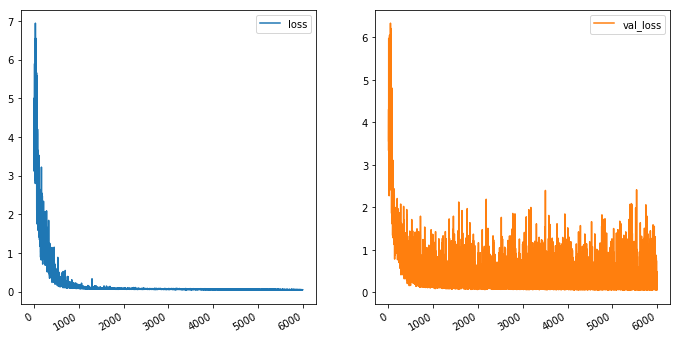

In [28]:
df[["loss","val_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD8E6F3B38>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


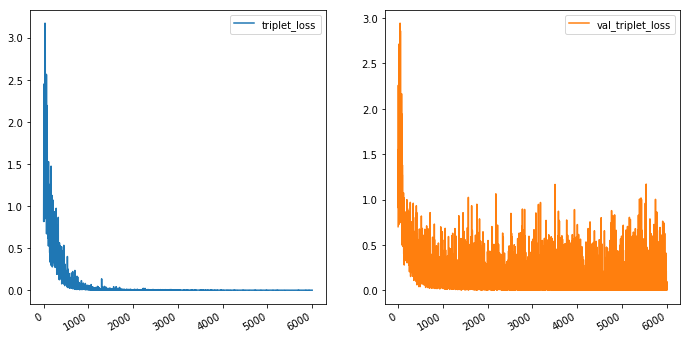

In [29]:
df[["triplet_loss","val_triplet_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD8E775C88>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


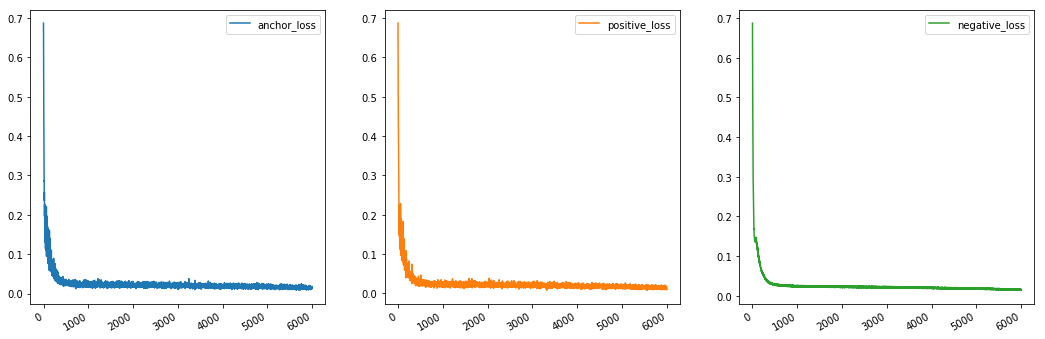

In [30]:
df[["anchor_loss","positive_loss","negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD8EA62DA0>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


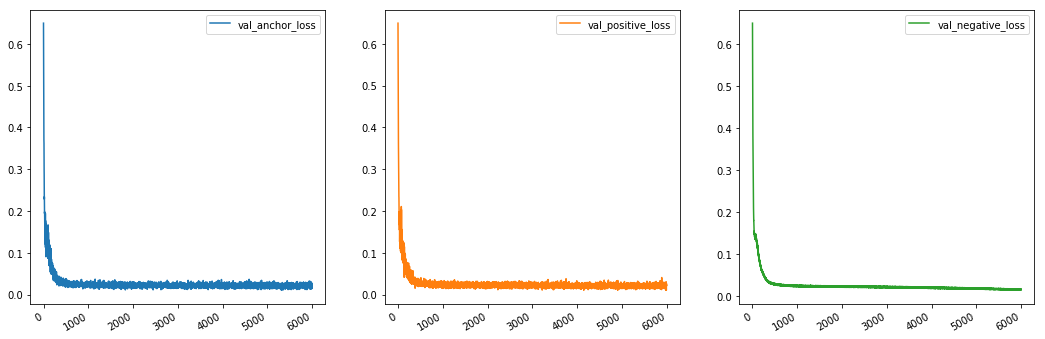

In [31]:
df[["val_anchor_loss","val_positive_loss","val_negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))